# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [241]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path

# Import additionnal packages 
# Utils
from urllib.request import urlretrieve
from itertools import chain
import pandas as pd
# Viz
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [26]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt', encoding='UTF-8') as f:  # Read compressed file directly with the good encoding
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        '''Returns the 1D embedding of a given word.'''
        
        if word not in self.words:
            raise NotImplementedError('Word not found in the vocabulary')
        
        else:
            idx = self.word2id[word]
            return self.embeddings[idx]
    
    def score(self, word1, word2):
        '''Return the cosine similarity between word1 and word2.
        
        Parameters:
            word1: as type string
            word2: as type string
        
        Return:
            Cosine similarity calculated with np.dot & np.linalg.norm
        '''
        
        # Encode word1 & word2
        encode1 = self.encode(word1)
        encode2 = self.encode(word2)
        
        # Compute the cosine similarity
        cosine = np.dot(encode1.T, encode2) / (np.linalg.norm(encode1) * np.linalg.norm(encode2))
        return cosine
    
    def most_similar(self, word, k=5):
        '''Returns the k most similar words: self.score & np.argsort.''' 
        
        # Test if possible
        if k > len(self.words):
            raise NotImplementedError('k too large (greater than the size of the vocabulary)')
        
        # Compute simialrity score of word w.r.t all other words
        scores = []
        similar_words = []
        nbr_nan = 0
        for wrd in self.words:
            # Handling Out-Of-Vocabulary words
            try:
                scr = self.score(word, wrd)
            except NotImplementedError:
                scr = np.NaN
                nbr_nan += 1
                print(wrd + ' not in vocaulary. Score set to NaN.')
            scores.append(scr)
        
        # Identify the index
        idxes = np.argsort(scores)[-(k + 1 + nbr_nan):-(1 + nbr_nan)] # Return all word excluding the same & NaN 
        for idx in idxes:
            similar_words.append(self.id2word[idx])

        return similar_words

In [27]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['dog', 'feline', 'kitten', 'kitty', 'cats']
['pet', 'canine', 'pup', 'puppy', 'dogs']
['pets', 'Dogs', 'puppies', 'cats', 'dog']
['Strasbourg', 'Brussels', 'Marseille', 'Parisian', 'France']
['Bavaria', 'Hamburg', 'Berlin', 'Europe', 'Austria']


In [111]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        '''Build the idf dictionary: associate each word to its idf value
        
        Parameters:
            sentences: list of documents
        
        Return:
            idf = {word: idf_value, ...}
        '''
        
        n_docs = len(sentences)
        idf = defaultdict(float)
        
        # Let's begin with a simple approach. Only the spaces between words are use a separators
        words_sentences = [s.split(' ') for s in sentences]
        all_words = set(chain.from_iterable(words_sentences))
        
        # Iterate over all words and sentences to count the appearance of a specific word
        for wrd in all_words:
            for sent in words_sentences:
                if wrd in sent:
                    idf[wrd] += 1
        
        # Compute the idf value
        f = lambda x: np.log(n_docs/x)
        idf.update({k: f(v) for k, v in idf.items()})
        
        return idf        
    
    def encode(self, sentence, idf=None):
        '''Takes a sentence as input, returns the sentence embedding.'''
        
        if idf is None:
            # mean of word vectors
            embedding = []
            for i, wrd in enumerate(sentence.split()):
                # Handling Out-Of-Vocabulary words
                try:
                    encd = self.word2vec.encode(wrd)
                    embedding.append(encd)
                except NotImplementedError:
                    print(wrd + ' not in vocabulary. Ignored for computing similarity between sentences')

            embedding = np.mean(embedding, axis = 0)
            return embedding
        
        else:
            # idf-weighted mean of word vectors
            embedding = []
            weights = []
            for wrd in sentence.split():
                # Handling Out-Of-Vocabulary words
                try:
                    encd = self.word2vec.encode(wrd)
                    embedding.append(encd)
                    weights.append(idf[wrd])
                except NotImplementedError:
                    print(wrd + ' not in vocabulary. Ignored for computing similarity between sentences')
                    
            embedding = np.average(embedding, axis=0, weights=weights)
            return embedding

    def score(self, sentence1, sentence2, idf=None, is_encoded=False):
        '''Cosine similarity: use np.dot & np.linalg.norm'''

        #Embedding of the sentences if there are not already encoded
        if not is_encoded:
            sentence1 = self.encode(sentence1, idf=idf)
            sentence2 = self.encode(sentence2, idf=idf)
            
        # Compute the cosine similarity
        cosine = np.dot(sentence1.T, sentence2) / (np.linalg.norm(sentence1) * np.linalg.norm(sentence2))
        return cosine
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        '''Return most similar sentences.'''
        
        # Check if possible
        if k > len(sentences):
            raise NotImplementedError('k too large (greater than the size of the vocabulary)')
        
        # Initialize the variables
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])
        scores = []
        similar_sentences = []
        
        for i in range(keys.shape[0]):
            scr = self.score(query, keys[i], idf=idf, is_encoded=True)
            scores.append(scr)
        
        idxes = np.argsort(scores)[-(k+1):-1] # Return all word excluding the same 
        for idx in idxes:
            similar_sentences.append(sentences[idx])

        return similar_sentences
    
    def fit_transform(self, sentences, idf=None):
        '''Return embeddings for a given list of sentences'''
        embeddings = []
        for sent in sentences:
            embeddings.append(self.encode(sent, idf=idf))
        return np.vstack(embeddings)

In [57]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
crosscountry not in vocabulary. Ignored for computing similarity between sentences
0.7065220648251475
iowa not in vocabulary. Ignored for computing similarity between sentences
mini-mart not in vocabulary. Ignored for computing similarity between sentences
crosscountry not in vocabulary. Ignored for computing similarity between sentences
choir. not in vocabulary. Ignored for computing similarity between sentences
archway not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
redheaded not in vocabulary. Ignored for computing similarity between sentences
fc not in vocabulary. Ignored for computing similarity between sentences
snuggling not in vocabulary. Ignored for computing similarity between sentences
gray-haired 

bmx not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
wall-ride not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ign

croatian not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
wristband not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
scantily not in vocabulary. Ignored for computing similarity between sentences
dachshund not in vocabulary. Ignored for computing similarity between sentences
dachshund not in vocabulary. Ignored for computing similarity between sentences
dallas not in vocabulary. Ignored for computing similarity between sentences
dalmatian not in vocabulary. Ignored for computing similarity between sentences
dalmatian not in vocabulary. Ignored for computing similarity between sentences
dalmatian not in vocabulary. Ignored for computing similarity between sentences
dalmation not in vocabulary. Ignored for computing similarity between sentences
dalmation not in vocabulary. Ignored for computin

bicyclist not in vocabulary. Ignored for computing similarity between sentences
meditates not in vocabulary. Ignored for computing similarity between sentences
s.c.u.b.a. not in vocabulary. Ignored for computing similarity between sentences
suv not in vocabulary. Ignored for computing similarity between sentences
cruz not in vocabulary. Ignored for computing similarity between sentences
dept. not in vocabulary. Ignored for computing similarity between sentences
scottish not in vocabulary. Ignored for computing similarity between sentences
bagpipe not in vocabulary. Ignored for computing similarity between sentences
scottish not in vocabulary. Ignored for computing similarity between sentences
kilts not in vocabulary. Ignored for computing similarity between sentences
scottish not in vocabulary. Ignored for computing similarity between sentences
sealife not in vocabulary. Ignored for computing similarity between sentences
sheltie not in vocabulary. Ignored for computing similarity betwe

exersaucer not in vocabulary. Ignored for computing similarity between sentences
tiptoeing not in vocabulary. Ignored for computing similarity between sentences
campflauge not in vocabulary. Ignored for computing similarity between sentences
crawls not in vocabulary. Ignored for computing similarity between sentences
crawls not in vocabulary. Ignored for computing similarity between sentences
rummaging not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
playpen not in vocabulary. Ignored for computing similarity between sentences
coddled not in vocabulary. Ignored for computing similarity between sentences
micky not in vocabulary. Ignored for computing similarity between sentences
sandpit not in vocabulary. Ignored for computing similarity between sentences
bassinet not in vocabulary. Ignored for computing similarity between sentences
terrycloth not in vocabulary. Ignored for computing simi

long-sleeve not in vocabulary. Ignored for computing similarity between sentences
rimmed not in vocabulary. Ignored for computing similarity between sentences
dines not in vocabulary. Ignored for computing similarity between sentences
bald-headed not in vocabulary. Ignored for computing similarity between sentences
balding not in vocabulary. Ignored for computing similarity between sentences
balding not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
cross-legged not in vocabulary. Ignored for computing similarity between sentences
balding not in vocabulary. Ignored for computing similarity between sentences
balding not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
balding not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computi

dimly not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
lakefront not in vocabulary. Ignored for computing similarity between sentences
modest-sized not in vocabulary. Ignored for computing similarity between sentences
percussionist not in vocabulary. Ignored for computing similarity between sentences
wall-sized not in vocabulary. Ignored for computing similarity between sentences
attender not in vocabulary. Ignored for computing similarity between sentences
baltimore not in vocabulary. Ignored for computing similarity between sentences
percussionists not in vocabulary. Ignored for computing similarity between sentences
marriott not in vocabulary. Ignored for computing similarity between sentences
zune not in vocabulary. Ignored for computing similarity between sentences
windowless not in vocabulary. Ignored for computing 

crouches not in vocabulary. Ignored for computing similarity between sentences
mid-swing not in vocabulary. Ignored for computing similarity between sentences
angeles not in vocabulary. Ignored for computing similarity between sentences
aaa not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
mitt not in vocabulary. Ignored for computing similarity between sentences
mid-swing not in vocabulary. Ignored for computing similarity between sentences
fronmt not in vocabulary. Ignored for computing similarity between sentences
mitt not in vocabulary. Ignored for computing similarity between sentences
mitt not in vocabulary. Ignored for computing similarity between sentences
mid-swing not in vocabulary. Ignored for computing similarity between sentences
punting not in vocabulary. Ignored for computing similarity between sentences
recoils not in vocabulary. Ignored for computing similarity between sent

bar-b-q not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
audrey not in vocabulary. Ignored for computing similarity between sentences
hepburn not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
backpackers not in vocabulary. Ignored for computing similarity between sentences
seascape not in vocabulary. Ignored for computing similarity between sentences
mossy not in vocabulary. Ignored for computing similarity between sentences
mardi not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
fuax not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
scottish not in vocabulary. Ignored for computing similarity between s

`` not in vocabulary. Ignored for computing similarity between sentences
rouleur not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
bicyler not in vocabulary. Ignored for computing similarity between sentences
bicylist not in vocabulary. Ignored for computing similarity between sentences
flatbed not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
dandylions not in vocabulary. Ignored for computing similarity between sentences
bares not in vocabulary. Ignored for computing similarity between sentences
corgis not in vocabulary. Ignored for computing similarity between sentences
sniffs not in vocabulary. Ignored for computing similarity between sentences
sniffs not in vocabulary. Ignored for computing similarity between sentences
gold-colored not in vocabulary. Ignored for computing similarity between sen

brown-and-white not in vocabulary. Ignored for computing similarity between sentences
tri-colored not in vocabulary. Ignored for computing similarity between sentences
tug-of-war not in vocabulary. Ignored for computing similarity between sentences
ringed not in vocabulary. Ignored for computing similarity between sentences
romping not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
mid-jump not in vocabulary. Ignored for computing similarity between sentences
circumvents not in vocabulary. Ignored for computing similarity between sentences
fetches not in vocabulary. Ignored for computing similarity between sentences
fetches not in vocabulary. Ignored for computing similarity between sentences
frolics not in vocabulary. Ignored for computing similarity between sentences
dumbbell not in vocabulary. Ignored for computing similarity between sentences
dumbbell not in vocabulary. Ignored for comp

bmx not in vocabulary. Ignored for computing similarity between sentences
single-handed not in vocabulary. Ignored for computing similarity between sentences
hairnets not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
thatched not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
bushel not in vocabulary. Ignored for computing similarity between sentences
beaker not in vocabulary. Ignored for computing similarity between sentences
drum-set not in vocabulary. Ignored for computing similarity between sentences
waring not in vocabulary. Ignored for computing similarity between sentences
smock not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between 

wistfully not in vocabulary. Ignored for computing similarity between sentences
unwraps not in vocabulary. Ignored for computing similarity between sentences
groucho not in vocabulary. Ignored for computing similarity between sentences
marx not in vocabulary. Ignored for computing similarity between sentences
boa not in vocabulary. Ignored for computing similarity between sentences
pursing not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
black-haired not in vocabulary. Ignored for computing similarity between sentences
nylons not in vocabulary. Ignored for computing similarity between sentences
squeamish not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
paintbrush not in vocabulary. Ignored for computing similarity between sentences
headdress not in vocabulary. Ignored for computing simila

blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blon

chevy not in vocabulary. Ignored for computing similarity between sentences
chevy not in vocabulary. Ignored for computing similarity between sentences
tow-truck not in vocabulary. Ignored for computing similarity between sentences
lilypads not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
excavator not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
go-cart not in vocabulary. Ignored for computing similarity between sentences
heron not in vocabulary. Ignored for computing similarity between sentences
outstreached not in vocabulary. Ignored for computing similarity between sentences
heron not in vocabulary. Ignored for computing similarity between sentences
sidecar not in vocabulary. Ignored for computing simila

contorts not in vocabulary. Ignored for computing similarity between sentences
suds not in vocabulary. Ignored for computing similarity between sentences
crawls not in vocabulary. Ignored for computing similarity between sentences
crawls not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
crouching not in vocabulary. Ignored for computing similarity between sentences
buries not in vocabulary. Ignored for computing similarity between sentences
cannonball not in vocabulary. Ignored for computing similarity between sentences
cartwheel not in vocabulary. Ignored for computing similarity between sentences
ranch-style not in vocabulary. Ignored for computing similarity between sentences
sundown not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similar

wetsuit not in vocabulary. Ignored for computing similarity between sentences
tracksuit not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
jungle-gym not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
wields not in vocabulary. Ignored for computing similarity between sentences
squirts not in vocabulary. Ignored for computing similarity between sentences
tilts not in vocabulary. Ignored for computing similarity between sentences
spiderman not in vocabulary. Ignored for computing similarity between sentences
floaties not in vocabulary. Ignored for computing similarity between sentences
admires not in vocabulary. Ignored for computing similarity between sentences
gibbous not in vocabulary. Ignored for computing 

graffiti-marked not in vocabulary. Ignored for computing similarity between sentences
underpass not in vocabulary. Ignored for computing similarity between sentences
jose not in vocabulary. Ignored for computing similarity between sentences
squinting not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
clothesline not in vocabulary. Ignored for computing similarity between sentences
mouthed not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
breaststroke not in vocabulary. Ignored for computing similarity between sentences
pinata not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
wakeboarding not in vocabulary. Ignored for comp

sparkler not in vocabulary. Ignored for computing similarity between sentences
spiderman not in vocabulary. Ignored for computing similarity between sentences
mets not in vocabulary. Ignored for computing similarity between sentences
moter not in vocabulary. Ignored for computing similarity between sentences
yankees not in vocabulary. Ignored for computing similarity between sentences
scottish not in vocabulary. Ignored for computing similarity between sentences
kilt not in vocabulary. Ignored for computing similarity between sentences
nash not in vocabulary. Ignored for computing similarity between sentences
dribbles not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
digger not in vocabulary. Ignored for computing similarity between sentences
tee-shirt not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between

zips not in vocabulary. Ignored for computing similarity between sentences
brindle not in vocabulary. Ignored for computing similarity between sentences
pilings not in vocabulary. Ignored for computing similarity between sentences
waterside not in vocabulary. Ignored for computing similarity between sentences
brindle not in vocabulary. Ignored for computing similarity between sentences
brindle not in vocabulary. Ignored for computing similarity between sentences
brindle not in vocabulary. Ignored for computing similarity between sentences
pitbull not in vocabulary. Ignored for computing similarity between sentences
brindle-coated not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
sniffs not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
yorkie not in vocabulary. Ignored for computing similarity

trotting not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
foal not in vocabulary. Ignored for computing similarity between sentences
galloping not in vocabulary. Ignored for computing similarity between sentences
nuzzling not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
pitbull not in vocabulary. Ignored for computing similarity between sentences
shorthaired not in vocabulary. Ignored for computing similarity between sentences
videotaping not in vocabulary. Ignored for computing similarity between sentences
tuft not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
itches not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for comp

casually-dressed not in vocabulary. Ignored for computing similarity between sentences
blueish not in vocabulary. Ignored for computing similarity between sentences
lidded not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
lei not in vocabulary. Ignored for computing similarity between sentences
heavy-lidded not in vocabulary. Ignored for computing similarity between sentences
waist-length not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
brunette-haired not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bronco not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for co

carver not in vocabulary. Ignored for computing similarity between sentences
chisel not in vocabulary. Ignored for computing similarity between sentences
calvin not in vocabulary. Ignored for computing similarity between sentences
klein not in vocabulary. Ignored for computing similarity between sentences
young-lady not in vocabulary. Ignored for computing similarity between sentences
untied not in vocabulary. Ignored for computing similarity between sentences
casually-dressed not in vocabulary. Ignored for computing similarity between sentences
casually-dressed not in vocabulary. Ignored for computing similarity between sentences
lego not in vocabulary. Ignored for computing similarity between sentences
shrubbery not in vocabulary. Ignored for computing similarity between sentences
flip-flop not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
swatting not in vocabulary. Ignored for compu

wiggles not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing similarity between sentences
oceanside not in vocabulary. Ignored for computing similarity between sentences
pinata not in vocabulary. Ignored for computing similarity between sentences
squirted not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
mrs. not in vocabulary. Ignored for computing similarity between sentences
grimaces not in vocabulary. Ignored for computing similarity between sentences
bared not in vocabulary. Ignored for computing similarity between sentences
heart-shaped not in vocabulary. Ignored for computing similarity between sentences
lollipop not in vocabulary. Ignored for computing similarity between sentences
bale not in vocabulary. Ignored for computing similarity between sentences
p-shaped not in vocabulary. Ignored for computing similarity betw

bleachers not in vocabulary. Ignored for computing similarity between sentences
t-ball not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
gurney not in vocabulary. Ignored for computing similarity between sentences
binocular not in vocabulary. Ignored for computing similarity between sentences
limes not in vocabulary. Ignored for computing similarity between sentences
wonderingly not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
swing-type not in vocabulary. Ignored for computing similarity between sentences
ventilator not in vocabulary. Ignored for computing similarity between sentences
brighton not in vocabulary. Ignored for computing similarity between sentences
cartwheel not in vocabulary. Ignored for computing similarity between sentences
cartwheel not in vocabulary. Ignored for comput

breakdancer not in vocabulary. Ignored for computing similarity between sentences
swathed not in vocabulary. Ignored for computing similarity between sentences
street-lamp not in vocabulary. Ignored for computing similarity between sentences
cable-car not in vocabulary. Ignored for computing similarity between sentences
close-together not in vocabulary. Ignored for computing similarity between sentences
awnings not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
passersby not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
bullhorn not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
double-decker not in vocabulary. Ignored for comp

rollerskates not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
rower not in vocabulary. Ignored for computing similarity between sentences
entertains not in vocabulary. Ignored for computing similarity between sentences
not-so not in vocabulary. Ignored for computing similarity between sentences
lollapalooza not in vocabulary. Ignored for computing similarity between sentences
well-spaced not in vocabulary. Ignored for computing similarity between sentences
abercrombie not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
balling not in vocabulary. Ignored for computing similarity between sentences
pews not in vocabulary. Ignored for computing similarity between sentences
subways not in vocabulary. Ignored for computing similarity between sentences
demolishing not in vocabulary. Ignored for co

scowls not in vocabulary. Ignored for computing similarity between sentences
lip-locked not in vocabulary. Ignored for computing similarity between sentences
strolls not in vocabulary. Ignored for computing similarity between sentences
strolls not in vocabulary. Ignored for computing similarity between sentences
strolls not in vocabulary. Ignored for computing similarity between sentences
triomphe not in vocabulary. Ignored for computing similarity between sentences
mannequin not in vocabulary. Ignored for computing similarity between sentences
folie not in vocabulary. Ignored for computing similarity between sentences
dulcimer not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
dachshund not in vocabulary. Ignored for computing similarity between sentences
hands. not in vocabulary. Ignored for computing similarity between sentences
isles not in vocabulary. Ignored for computing similarity

crouching not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
yong not in vocabulary. Ignored for computing similarity between sentences
univ. not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
batman not in vocabulary. Ignored for computing similarity between sentences
unidentifiable not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
streamers not in vocabulary. Ignored for computing similarity between sentences
whitecaps not in vocabulary. Ignored for computing similarity between sentences
claps not in vocabulary. Ignored for computing similarity between sentences
buzzcock not in vocabulary. Ignored for computing similarity between sentences
storefronts not in vocabulary. Ignored for computing similarity b

attentively not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sentences
bender not in vocabulary. Ignored for computing similarity between sentences
cityscape not in vocabulary. Ignored for computing similarity between sentences
hi-pointe not in vocabulary. Ignored for computing similarity between sentences
d.c not in vocabulary. Ignored for computing similarity between sentences
alleyway not in vocabulary. Ignored for computing similarity between sentences
english-style not in vocabulary. Ignored for computing similarity between sentences
pogo not in vocabulary. Ignored for computing similarity between sentences
remax not in vocabulary. Ignored for computing similarity between sentences
dickens not in vocabulary. Ignored for computing similarity between sentences
twister not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similar

headdress not in vocabulary. Ignored for computing similarity between sentences
regalia not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
bua not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
ukraine not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for computing similarity between sentences
daredevil not in vocabulary. Ignored for computing similarity between sentences
chews not in vocabulary. Ignored for computing similarity between sentences
liebherr not in vocabulary. Ignored for computing similarity between sentences
excavator not in vocabulary. Ignored for computing similarity between sentences


dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-sk

vw not in vocabulary. Ignored for computing similarity between sentences
basset not in vocabulary. Ignored for computing similarity between sentences
nose-deep not in vocabulary. Ignored for computing similarity between sentences
snuggling not in vocabulary. Ignored for computing similarity between sentences
malnourished not in vocabulary. Ignored for computing similarity between sentences
approachs not in vocabulary. Ignored for computing similarity between sentences
barks not in vocabulary. Ignored for computing similarity between sentences
waterboard not in vocabulary. Ignored for computing similarity between sentences
bounding not in vocabulary. Ignored for computing similarity between sentences
buries not in vocabulary. Ignored for computing similarity between sentences
burrowing not in vocabulary. Ignored for computing similarity between sentences
carreis not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similar

rears not in vocabulary. Ignored for computing similarity between sentences
loveseat not in vocabulary. Ignored for computing similarity between sentences
retrieves not in vocabulary. Ignored for computing similarity between sentences
retrieves not in vocabulary. Ignored for computing similarity between sentences
retrieves not in vocabulary. Ignored for computing similarity between sentences
shrubbery not in vocabulary. Ignored for computing similarity between sentences
mucky not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
footbride not in vocabulary. Ignored for computing similarity between sentences
headlong not in vocabulary. Ignored for computing similarity between sentences
deflated not in vocabulary. Ignored for computing similarity between sentences
grss not in vocabulary. Ignored for computing similarity between sentences
overtop not in vocabulary. Ignored for computing similarit

africans not in vocabulary. Ignored for computing similarity between sentences
stepstool not in vocabulary. Ignored for computing similarity between sentences
spongebob not in vocabulary. Ignored for computing similarity between sentences
squarepants not in vocabulary. Ignored for computing similarity between sentences
jenga not in vocabulary. Ignored for computing similarity between sentences
macintosh not in vocabulary. Ignored for computing similarity between sentences
ipads not in vocabulary. Ignored for computing similarity between sentences
sledding not in vocabulary. Ignored for computing similarity between sentences
mountaintop not in vocabulary. Ignored for computing similarity between sentences
redheaded not in vocabulary. Ignored for computing similarity between sentences
famished not in vocabulary. Ignored for computing similarity between sentences
vuvuzela not in vocabulary. Ignored for computing similarity between sentences
fancily not in vocabulary. Ignored for computing

lionist not in vocabulary. Ignored for computing similarity between sentences
long-jumper not in vocabulary. Ignored for computing similarity between sentences
mid-jump not in vocabulary. Ignored for computing similarity between sentences
restrains not in vocabulary. Ignored for computing similarity between sentences
inhales not in vocabulary. Ignored for computing similarity between sentences
mid-stride not in vocabulary. Ignored for computing similarity between sentences
fatigues not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
i.v. not in vocabulary. Ignored for computing similarity between sentences
nimbly not in vocabulary. Ignored for computing similarity between sentences
vaulter not in vocabulary. Ignored for computing similarity between sentences
window-lined not in vocabulary. Ignored for com

firetruck not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
basemen not in vocabulary. Ignored for computing similarity between sentences
pickoff not in vocabulary. Ignored for computing similarity between sentences
baits not in vocabulary. Ignored for computing similarity between sentences
moored not in vocabulary. Ignored for computing similarity between sentences
pelicans not in vocabulary. Ignored for computing similarity between sentences
untangles not in vocabulary. Ignored for computing similarity between sentences
fisheye not in vocabulary. Ignored for computing sim

fully-padded not in vocabulary. Ignored for computing similarity between sentences
well-lit not in vocabulary. Ignored for computing similarity between sentences
wristbands not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
dna not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
furocious not in vocabulary. Ignored for computing similarity between sentences
rump not in vocabulary. Ignored for computing similarity between sentences
gaggle not in vocabulary. Ignored for computing similarity between sentences
carcassonne not in vocabulary. Ignored for computing similarity between sentences
dominoes not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
huppe not in vocabulary. Ignored for computing similarity between sente

pinwheel not in vocabulary. Ignored for computing similarity between sentences
atvs not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
pounces not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
gazes not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
frilly not in vocabulary. Ignored for computing similarity between sentences
ymca not in vocabulary. Ignored for computing similarity between sentences
speedo not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between s

pigtails not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
mustached not in vocabulary. Ignored for computing similarity between sentences
twirls not in vocabulary. Ignored for computing similarity between sentences
tutu not in vocabulary. Ignored for computing similarity between sentences
bar-b-que not in vocabulary. Ignored for computing similarity between sentences
stripey not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
busily not in vocabulary. Ignored for computing similarity between sentences
frowning not in vocabulary. Ignored for computing similarity between sentences
atvs not in vocabulary. Ignored for computing similarity between sentences
water-wear not in vocabulary. Ignored for computing similarity between sentences
razzling not in vocabulary. Ignored for computing similarity

inhaler not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
battery-powered not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
treks not in vocabulary. Ignored for computing similarity between sentences
scythe not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
twirls not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
waterskis not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
hawaiian not in vocabulary. Ignored for computing similarity between sentences
lei not in vocabulary. Ignored for computing similarity 

pigtails not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
streaked not in vocabulary. Ignored for computing similarity between sentences
uggs not in vocabulary. Ignored for computing similarity between sentences
toenail not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
spider-man not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
mid-speach not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing simil

gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not 

asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
dhl not in vocabulary. Ignored for computing similarity between sentences
saxophones not in vocabulary. Ignored for computing similarity between sentences
gondoliers not in vocabulary. Ignored for computing similarity between sentences
propelling not in vocabulary. Ignored for computing similarity

bmw not in vocabulary. Ignored for computing similarity between sentences
tutus not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
harnessed not in vocabulary.

crucifix not in vocabulary. Ignored for computing similarity between sentences
scepter not in vocabulary. Ignored for computing similarity between sentences
closer-to-shore not in vocabulary. Ignored for computing similarity between sentences
haiti not in vocabulary. Ignored for computing similarity between sentences
photo-op not in vocabulary. Ignored for computing similarity between sentences
vespas not in vocabulary. Ignored for computing similarity between sentences
bulldozer not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
bavarian-style not in vocabulary. Ignored for computing similarity between sentences
steins not in vocabulary. Ignored for computing similarity between sentences
corn-looking not in vocabulary. Ignored for computing similarity between sentences
oktoberfest-themed not in vocabulary. Ignored for computing similarity between sentences
steins not in vocabulary. Ignored

lincoln not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sentences
headless not in vocabulary. Ignored for computing similarity between sentences
legless not in vocabulary. Ignored for computing similarity between sentences
mannequin not in vocabulary. Ignored for computing similarity between sentences
off-camera not in vocabulary. Ignored for computing similarity between sentences
tilling not in vocabulary. Ignored for computing similarity between sentences
thatch not in vocabulary. Ignored for computing similarity between sentences
beijing not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
escalators not in vocabulary. Ignored for computing similarity between sentences
congregated not in vocabulary. Ignored for computin

arabian not in vocabulary. Ignored for computing similarity between sentences
headdresses not in vocabulary. Ignored for computing similarity between sentences
plumes not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
hazmat not in vocabulary. Ignored for computing similarity between sentences
rafts not in vocabulary. Ignored for computing similarity between sentences
jobbing not in vocabulary. Ignored for computing similarity between sentences
kilts not in vocabulary. Ignored for computing similarity between sentences
l-sh

crosswalk not in vocabulary. Ignored for computing similarity between sentences
mcdonalds not in vocabulary. Ignored for computing similarity between sentences
vagabond not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
amc not in vocabulary. Ignored for computing similarity between sentences
ornately not in vocabulary. Ignored for computing similarity between sentences
tree-lined not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
scrubland not in vocabulary. Ignored for computing similarity between sentences
amc not in vocabulary. Ignored for computing similarity between sentences
hydrant not in vocabulary. Ignored for computing similarity between sentences
surfboards not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing si

vatican not in vocabulary. Ignored for computing similarity between sentences
twirl not in vocabulary. Ignored for computing similarity between sentences
trendily-dressed not in vocabulary. Ignored for computing similarity between sentences
street-corner not in vocabulary. Ignored for computing similarity between sentences
turbaned not in vocabulary. Ignored for computing similarity between sentences
motorbikes not in vocabulary. Ignored for computing similarity between sentences
twenty-something not in vocabulary. Ignored for computing similarity between sentences
walkathon not in vocabulary. Ignored for computing similarity between sentences
schoolgirls not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
barricade not in vocabulary. Ignored for computing similarity between sentences
rainstorm not in vocabulary. Ignored for

superman not in vocabulary. Ignored for computing similarity between sentences
peddling not in vocabulary. Ignored for computing similarity between sentences
waling not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
wallride not in vocabulary. Ignored for computing similarity between sentences
rollerblading not in vocabulary. Ignored for computing similarity between sentences
waterskiing not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
windowsill not in vocabulary. Ignored for computing similarity between sentences
baltimore not in vocabulary. Ignored for computing similarity between sentences
ravens not in vocabulary. Ignored for computing similarity between sentences
hawaiian not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing

spiky not in vocabulary. Ignored for computing similarity between sentences
bended not in vocabulary. Ignored for computing similarity between sentences
djing not in vocabulary. Ignored for computing similarity between sentences
cinder not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
wineglasses not in vocabulary. Ignored for computing similarity between sentences
briskly not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
stheart not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
stringed not in vocabulary. Ignored for computing similarity between sentences
guitar-like not in vocabulary. Ignored for computing similarity between sentences
hawaiian not in vocabulary. Ignored for computing similarity between

4-wheeler not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
go-cart not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing sim

hiker not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
precipice not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
wades not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
coniferous not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
kfc not in vocabulary. Ignored for computing similarity between sentence

jockeys not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
galloping not in vocabulary. Ignored for computing similarity between sentences
raceway not in vocabulary. Ignored for computing similarity between sentences
mottled not in vocabulary. Ignored for computing similarity between sentences
gallops not in vocabulary. Ignored for computing similarity between sentences
rinding not in vocabulary. Ignored for computing similarity between sentences
stirrups not in vocabulary. Ignored for computing similarity between sentences
trots not in vocabulary. Ignored for computing similarity between sentences
well-toned not in vocabulary. Ignored for computing similarity between sentences
jogger not in vocabulary. Ignored for computing similarity between sentences
jogger not in vocabulary. Ignored for computing similarity between sentences
jogger not in vocabulary. Ignored for computing similarity be

tumbles not in vocabulary. Ignored for computing similarity between sentences
mid-game not in vocabulary. Ignored for computing similarity between sentences
skyward not in vocabulary. Ignored for computing similarity between sentences
victoria not in vocabulary. Ignored for computing similarity between sentences
l. not in vocabulary. Ignored for computing similarity between sentences
megaphone not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
ponchos not in vocabulary. Ignored for computing similarity between sentences
attired not in vocabulary. Ignored for computing similarity between sentences
spools not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
encrusted not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity betwe

red-hair not in vocabulary. Ignored for computing similarity between sentences
bartending not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
briskly not in vocabulary. Ignored for computing similarity between sentences
fogging not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for comp

escalator not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
mcdonald not in vocabulary. Ignored for computing similarity between sentences
mcdonalds not in vocabulary. Ignored for computing similarity between sentences
pro-palestinian not in vocabulary. Ignored for computing similarity between sentences
crosscountry not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
ovals not in vocabulary. Ignored for computing similarity between sentences
applauding not in vocabulary. Ignored for computing similarity between sentences
cellos not in vocabulary. Ignored for computing

overpass not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
fishbowls not in vocabulary. Ignored for computing similarity between sentences
tablecloth not in vocabulary. Ignored for computing similarity between sentences
buggys not in vocabulary. Ignored for computing similarity between sentences
broken-down not in vocabulary. Ignored for computing similarity between sentences
scolded not in vocabulary. Ignored for computing similarity between sentences
motorbikes not in vocabulary. Ignored for computing similarity between sentences
hyatt not in vocabulary. Ignored for computing similarity between sentences
regency not in vocabulary. Ignored for computing similarity between sentences
placards not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing simila

waterpark not in vocabulary. Ignored for computing similarity between sentences
jungle-gym not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
dior not in vocabulary. Ignored for computing similarity between sentences
grownup not in vocabulary. Ignored for computing similarity between sentences
go-karts not in vocabulary. Ignored for computing similarity between sentences
merry-go-round not in vocabulary. Ignored for computing similarity between sentences
elmo not in vocabulary. Ignored for computing similarity between sentences
gidday not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
pinata not in vocabulary. Ignored for computing similarity

hula not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
hula-hooping not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
dora not in vocabulary. Ignored for computing similarity between sentences
snuggling not in vocabulary. Ignored for computing similarity between sentences
lollipop not in vocabulary. Ignored for computing similarity between sentences
lolly not in vocabulary. Ignored for computing similarity between sentences
red-seated not in vocabulary. Ignored for computing similarity between sentences
fleecy not in vocabulary. Ignored for computing similarity between sentences
floury not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
jersy not in vocabulary. Ignored for computing similarity between se

tricycle not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
wheeler not in vocabulary. Ignored for computing similarity between sentences
brighly not in vocabulary. Ignored for computing similarity between sentences
admires not in vocabulary. Ignored for computing similarity between sentences
lunchbox not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computing similarity between sentences
farris not in vocabulary. Ignored for computing similarity between sentences
tassels not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sentences
twisty not in vocabulary. Ignored for computing similarity between sentences
snowsuit not in vocabulary. Ignored for computing similarity between sentences
shrowded not in vocabulary. Ignored for computing similari

highchair not in vocabulary. Ignored for computing similarity between sentences
cold-weather not in vocabulary. Ignored for computing similarity between sentences
sledding not in vocabulary. Ignored for computing similarity between sentences
sledding not in vocabulary. Ignored for computing similarity between sentences
pail not in vocabulary. Ignored for computing similarity between sentences
gamecube not in vocabulary. Ignored for computing similarity between sentences
mcdonald not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computing similarity between sentences
windup not in vocabulary. Ignored for computing similarity between sentences
light-haired not in vocabulary. Ignored for computing similarity between sentences
kilt not in vocabulary. Ignored for computing si

long-haired not in vocabulary. Ignored for computing similarity between sentences
extendable not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
short-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-necked not in vocabulary. Ignored for computing similarity between sentences
long-necked not 

long-sleeved not in vocabulary. Ignored for computing similarity between sentences
mannequin not in vocabulary. Ignored for computing similarity between sentences
mid-lower not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
headdress not in vocabulary. Ignored for computing similarity between sentences
rollerblades not in vocabulary. Ignored for computing similarity between sentences
paramedic not in vocabulary. Ignored for computing similarity between sentences
islamic not in vocabulary. Ignored for computing similarity between sentences
percussionist not in vocabulary. Ignored for computing similarity between sentences
marimba not in vocabulary. Ignored for computing similarity between sentences
breakdancing not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
nikon not in vocabulary. Ignored for 

sprayer not in vocabulary. Ignored for computing similarity between sentences
pomeranian not in vocabulary. Ignored for computing similarity between sentences
undershirt not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
splits. not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
lanyard not in vocabulary. Ignored for computing similarity between sentences
florescent not in vocabulary. Ignored for computing similarity between sentences
florescent not in vocabulary. Ignored for computing similarity between sentences
tuque not in vocabulary. Ignored for computing similarity between sentences
christ not in vocabulary. Ignored for computing similarity between sentences
lungi not in vocabulary. Ignored for computing similarity between sentences
hairnet not in vocabulary. Ignored for computing sim

escalator not in vocabulary. Ignored for computing similarity between sentences
huckabee not in vocabulary. Ignored for computing similarity between sentences
tatooed not in vocabulary. Ignored for computing similarity between sentences
roof-type not in vocabulary. Ignored for computing similarity between sentences
above-ground not in vocabulary. Ignored for computing similarity between sentences
hot-tub not in vocabulary. Ignored for computing similarity between sentences
outside- not in vocabulary. Ignored for computing similarity between sentences
cross-legged not in vocabulary. Ignored for computing similarity between sentences
ziplock not in vocabulary. Ignored for computing similarity between sentences
brulee not in vocabulary. Ignored for computing similarity between sentences
silver-colored not in vocabulary. Ignored for computing similarity between sentences
stonehurst not in vocabulary. Ignored for computing similarity between sentences
red-orange not in vocabulary. Ignored f

kitchenaid not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
suzuki not in vocabulary. Ignored for computing similarity between sentences
rican not in vocabulary. Ignored for computing similarity between sentences
waders not in vocabulary. Ignored for computing similarity between sentences
putters not in vocabulary. Ignored for computing similarity between sentences
animatedly not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
nail-gloss not in vocabulary. Ignored for computing similarity between sentences
redheaded not in vocabulary. Ignored for computing similarity between sentences
flatbreads not in vocabulary. Ignored for computing similarity

boja not in vocabulary. Ignored for computing similarity between sentences
fadaw not in vocabulary. Ignored for computing similarity between sentences
bagpipes not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
acrobatics not in vocabulary. Ignored for computing similarity between sentences
leotard not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity bet

bulldozer not in vocabulary. Ignored for computing similarity between sentences
steers not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
deere not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
four-wheeler not in vocabulary. Ignored for computing similarity between sentences
go-kart not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
rickshaw not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sen

bagpipes not in vocabulary. Ignored for computing similarity between sentences
kilt not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbees not in vocabulary. Ignored for computing similarity between sentences
falcon not in vocabulary. Ignored for computing similarity between sentences
snowbound not in vocabulary. Ignored for computing similarity between sentences
orange-red not in vocabulary. Ignored for computing similarity between sentences
vuvuzela not in vocabulary. Ignored for computing similarity between sentences
beehive not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
sl

dueling not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bronco not in vocabulary. Ignored for computing similarity between sentences
rears not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing similarity between sentences
uncompleted not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
jemima not in vocabulary. Ignored for computing similarity between sentences
pole-vaulting not in vocabulary. Ignored for computing similarity between sentences
weather-beaten not in vocabulary. Ignored for computing similarity between sentences
thorugh not in vocabulary. Ignored for computing simi

slacks not in vocabulary. Ignored for computing similarity between sentences
knick-knacks not in vocabulary. Ignored for computing similarity between sentences
rvs not in vocabulary. Ignored for computing similarity between sentences
repelling not in vocabulary. Ignored for computing similarity between sentences
off-camera not in vocabulary. Ignored for computing similarity between sentences
dolly not in vocabulary. Ignored for computing similarity between sentences
kilt not in vocabulary. Ignored for computing similarity between sentences
black-plaid not in vocabulary. Ignored for computing similarity between sentences
oar not in vocabulary. Ignored for computing similarity between sentences
graffiti-covered not in vocabulary. Ignored for computing similarity between sentences
oxford not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
wineglass not in vocabulary. Ignored for computing simi

carying not in vocabulary. Ignored for computing similarity between sentences
overcoat not in vocabulary. Ignored for computing similarity between sentences
astride not in vocabulary. Ignored for computing similarity between sentences
brightly-colored not in vocabulary. Ignored for computing similarity between sentences
squinting not in vocabulary. Ignored for computing similarity between sentences
collared not in vocabulary. Ignored for computing similarity between sentences
bowtie not in vocabulary. Ignored for computing similarity between sentences
styrofoam not in vocabulary. Ignored for computing similarity between sentences
wheel-well not in vocabulary. Ignored for computing similarity between sentences
chisel not in vocabulary. Ignored for computing similarity between sentences
shire not in vocabulary. Ignored for computing similarity between sentences
shetland not in vocabulary. Ignored for computing similarity between sentences
sheepdog not in vocabulary. Ignored for computing

lanyard not in vocabulary. Ignored for computing similarity between sentences
graffitied not in vocabulary. Ignored for computing similarity between sentences
earmuffs not in vocabulary. Ignored for computing similarity between sentences
chopsticks not in vocabulary. Ignored for computing similarity between sentences
tablecloth not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
shrubbery not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
slicer not in vocabulary. Ignored for computing similarity between sentences
telecaster not in vocabulary. Ignored for computing similarity between sentences
earbuds not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing s

jackhammer not in vocabulary. Ignored for computing similarity between sentences
jackhammer not in vocabulary. Ignored for computing similarity between sentences
carting not in vocabulary. Ignored for computing similarity between sentences
rickshaw not in vocabulary. Ignored for computing similarity between sentences
digger not in vocabulary. Ignored for computing similarity between sentences
louvre not in vocabulary. Ignored for computing similarity between sentences
mannequin not in vocabulary. Ignored for computing similarity between sentences
contraption not in vocabulary. Ignored for computing similarity between sentences
pitchfork not in vocabulary. Ignored for computing similarity between sentences
shrubbery not in vocabulary. Ignored for computing similarity between sentences
ikea not in vocabulary. Ignored for computing similarity between sentences
hitched not in vocabulary. Ignored for computing similarity between sentences
strumming not in vocabulary. Ignored for computing s

hatchet not in vocabulary. Ignored for computing similarity between sentences
joseph not in vocabulary. Ignored for computing similarity between sentences
wields not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
hooping not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
earbuds not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
graffiti-heavy not in vocabulary. Ignored for computing similarity between sentences
videotaping not in vocabulary. Ignored for computing similarity between sentences
gibson not in vocabulary. Ignored for computing similarity between sentences
purplish not in vocabulary. Ignored for computing similarity

rumpled not in vocabulary. Ignored for computing similarity between sentences
stomps not in vocabulary. Ignored for computing similarity between sentences
farm-like not in vocabulary. Ignored for computing similarity between sentences
swampy not in vocabulary. Ignored for computing similarity between sentences
rust-colored not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for computing similarity between sentences
xylophone not in vocabulary. Ignored for computing similarity between sentences
tuba not in vocabulary. Ignored for computing similarity between sentences
sedge not in vocabulary. Ignored for computing similarity between sentences
shiney not in vocabulary. Ignored for computing similarity between sentences
hoisted not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sen

enviorment not in vocabulary. Ignored for computing similarity between sentences
leis not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
prostrate not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
gazes not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
turtleneck not in vocabulary. Ignored for computing similarity between sentences
tutu not in vocabulary. Ignored for computing similarity between sentences
waterskies not in vocabulary. Ignored for computing similarity between

gazes not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
water-filled not in vocabulary. Ignored for computing similarity between sentences
rees.com not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
dunks not in vocabulary. Ignored for computing similarity between sentences
bicyclist not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
seagull not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computing similarity between sentences
caulking not in vocabulary. Ignored for computing similarity between sentences
shish not in vocabulary. Ignored for computing 

onyx not in vocabulary. Ignored for computing similarity between sentences
ostentatiously not in vocabulary. Ignored for computing similarity between sentences
button-down not in vocabulary. Ignored for computing similarity between sentences
pinkie not in vocabulary. Ignored for computing similarity between sentences
handfuls not in vocabulary. Ignored for computing similarity between sentences
mannequin not in vocabulary. Ignored for computing similarity between sentences
off-camera not in vocabulary. Ignored for computing similarity between sentences
mercedes not in vocabulary. Ignored for computing similarity between sentences
ikea not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
piccolo not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similarity be

long-sleeved not in vocabulary. Ignored for computing similarity between sentences
brooms not in vocabulary. Ignored for computing similarity between sentences
mops not in vocabulary. Ignored for computing similarity between sentences
strums not in vocabulary. Ignored for computing similarity between sentences
slacks not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
mostly-barren not in vocabulary. Ignored for computing similarity between sentences
sawing not in vocabulary. Ignored for computing similarity between sentences
repels not in vocabulary. Ignored for computing similarity between sentences
stringed not in vocabulary. Ignored for computing similarity between 

dress-type not in vocabulary. Ignored for computing similarity between sentences
four-wheeler not in vocabulary. Ignored for computing similarity between sentences
ladles not in vocabulary. Ignored for computing similarity between sentences
peeler not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
tug-of-war not in vocabulary. Ignored for computing similarity between sentences
feathery not in vocabulary. Ignored for computing similarity between sentences
banister not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
curtsying not in vocabulary. Ignored for computing similarity between sentences
harnessed not in vocabulary. Ignored for computing similarity between sentences
naples not in vocabulary. Ignored for

escalator not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
belly-smacker not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
rodeos not in vocabulary. Ignored for computing similarity between sentences
parachuting not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
nescafe not in vocabulary. Ignored for computing similarity between sentences
abseiling not in vocabulary. Ignored for computing similarity between sentences
jabbing not in vocabulary. Ignored for computing similarity between sentences
astride not in vocabulary. Ignored for computing similarity between sentences
beanbag not in vocabulary. Ignored for computing similarity between sentences
barbecuing not in vocabulary. Ignored for comp

banister not in vocabulary. Ignored for computing similarity between sentences
flailing not in vocabulary. Ignored for computing similarity between sentences
alon not in vocabulary. Ignored for computing similarity between sentences
paraglider not in vocabulary. Ignored for computing similarity between sentences
water-skiing not in vocabulary. Ignored for computing similarity between sentences
cityscape not in vocabulary. Ignored for computing similarity between sentences
gesturing not in vocabulary. Ignored for computing similarity between sentences
bucked not in vocabulary. Ignored for computing similarity between sentences
bronco not in vocabulary. Ignored for computing similarity between sentences
tepee not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing similarity between sentences
powerpoint not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing s

mitt not in vocabulary. Ignored for computing similarity between sentences
roach not in vocabulary. Ignored for computing similarity between sentences
vons not in vocabulary. Ignored for computing similarity between sentences
bulldozer not in vocabulary. Ignored for computing similarity between sentences
off-screen not in vocabulary. Ignored for computing similarity between sentences
pitbull not in vocabulary. Ignored for computing similarity between sentences
parabola not in vocabulary. Ignored for computing similarity between sentences
ballgame not in vocabulary. Ignored for computing similarity between sentences
thumbs-up not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
mashing not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between senten

shoveling not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
nissan not in vocabulary. Ignored for computing similarity between sentences
altima not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
starfish not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
shucking not in vocabulary. Ignored for computing similarity between sentences
siting not in vocabulary. Ignored for computing similarity between sentences
strumming not in vocabulary. Ignored for computing 

bicyclist not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sentences
hawaii not in vocabulary. Ignored for computing similarity between sentences
camouflaged not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sentences
shined not in vocabulary. Ignored for computing similarity between sentences
orangutan not in vocabulary. Ignored for computing similarity between sentences
tattooing not in vocabulary. Ignored for computing similarity between sentences
ikea not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
freesbies not in vocabulary. Ignored for computing similari

fjord not in vocabulary. Ignored for computing similarity between sentences
handrail not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
fiesty not in vocabulary. Ignored for computing similarity between sentences
foamy not in vocabulary. Ignored for computing similarity between sentences
kayaker not in vocabulary. Ignored for computing similarity between sentences
four-wheeler not in vocabulary. Ignored for computing similarity between sentences
kiyaking not in vocabulary. Ignored for computing similarity between sentences
respirator not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similari

inspects not in vocabulary. Ignored for computing similarity between sentences
rusting not in vocabulary. Ignored for computing similarity between sentences
megaphone not in vocabulary. Ignored for computing similarity between sentences
monocycle not in vocabulary. Ignored for computing similarity between sentences
moored not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
puma not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
silhouetted not in vocabulary. Ignored for computing similarity between 

surfboard not in vocabulary. Ignored for computing similarity between sentences
mini-race not in vocabulary. Ignored for computing similarity between sentences
wakeboarding not in vocabulary. Ignored for computing similarity between sentences
waterskiing not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
jagermeister not in vocabulary. Ignored for computing similarity between sentences
throng not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
picketing not in vocabulary. Ignored for computing similarity between sentences
coconuts not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
tyson not in vocabulary. Ignored for computing similarity between sentences
punchout not in vocabulary. Ignored for 

low-traffic not in vocabulary. Ignored for computing similarity between sentences
shrubbery not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
lasso not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
sidecar not in vocabulary. Ignored for computing similarity between sentences
pinkish not in vocabulary. Ignored for computing similarity between sentences
rickshaw not in vocabulary. Ignored for computing similarity between sentences
beagle not in vocabulary. Ignored for computing similari

hawaiian not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for comput

foldout not in vocabulary. Ignored for computing similarity between sentences
bookbag not in vocabulary. Ignored for computing similarity between sentences
slouched not in vocabulary. Ignored for computing similarity between sentences
slumbers not in vocabulary. Ignored for computing similarity between sentences
slumps not in vocabulary. Ignored for computing similarity between sentences
clinking not in vocabulary. Ignored for computing similarity between sentences
wiggling not in vocabulary. Ignored for computing similarity between sentences
fauxhawk not in vocabulary. Ignored for computing similarity between sentences
cast-iron not in vocabulary. Ignored for computing similarity between sentences
suds not in vocabulary. Ignored for computing similarity between sentences
smithing not in vocabulary. Ignored for computing similarity between sentences
mossy not in vocabulary. Ignored for computing similarity between sentences
snowboards not in vocabulary. Ignored for computing similarity

surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
seascape not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between s

raincoat not in vocabulary. Ignored for computing similarity between sentences
three-wheeled not in vocabulary. Ignored for computing similarity between sentences
leashes not in vocabulary. Ignored for computing similarity between sentences
storefronts not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
stilts not in vocabulary. Ignored for computing similarity between sentences
storefronts not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
adverting not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
grass-covered not in vocabulary. Ignored for comp

slacks not in vocabulary. Ignored for computing similarity between sentences
wristbands not in vocabulary. Ignored for computing similarity between sentences
trotting not in vocabulary. Ignored for computing similarity between sentences
yamaha not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
wields not in vocabulary. Ignored for computing similarity between sentences
slacks not in vocabulary. Ignored for computing similarity between sentences
steadies not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity betwe

suspenders not in vocabulary. Ignored for computing similarity between sentences
underpants not in vocabulary. Ignored for computing similarity between sentences
chipper not in vocabulary. Ignored for computing similarity between sentences
wades not in vocabulary. Ignored for computing similarity between sentences
harlequin not in vocabulary. Ignored for computing similarity between sentences
harley-davidson not in vocabulary. Ignored for computing similarity between sentences
cornfield not in vocabulary. Ignored for computing similarity between sentences
zip-up not in vocabulary. Ignored for computing similarity between sentences
glares not in vocabulary. Ignored for computing similarity between sentences
chisel not in vocabulary. Ignored for computing similarity between sentences
inspects not in vocabulary. Ignored for computing similarity between sentences
overstuffed not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for comp

cross-legged not in vocabulary. Ignored for computing similarity between sentences
sunhat not in vocabulary. Ignored for computing similarity between sentences
rucksack not in vocabulary. Ignored for computing similarity between sentences
superman not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
gnu not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
gigolo not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
verizon not in vocabulary. Ignored for computing similarity between sentences
jake n

chopsticks not in vocabulary. Ignored for computing similarity between sentences
tans not in vocabulary. Ignored for computing similarity between sentences
scooping not in vocabulary. Ignored for computing similarity between sentences
wood-chipping not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
squints not in vocabulary. Ignored for computing similarity between sentences
bulldozer not in vocabulary. Ignored for computing similarity between sentences
jackhammer not in vocabulary. Ignored for computing similarity between sentences
unfastened not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
brooms not in vocabulary. Ignored for computing similarity between sentences
lurching not in vocabulary. Ignored for computing similarity between sentences
parasailing not in vocabulary. Ignored for comp

sand-trap not in vocabulary. Ignored for computing similarity between sentences
leashes not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
slacks not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
parachuting not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
superman not in vocabulary. Ignored for computing similarity between sentences
kneepads not in vocabulary. Ignored for computing similarity between sentences
tank-top not in vocabulary. Ignored for computing similarity between sentences
chiseled not in vocabulary. Ignored for computing

beret not in vocabulary. Ignored for computing similarity between sentences
cadillac not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
cityscape not in vocabulary. Ignored for computing similarity between sentences
israel not in vocabulary. Ignored for computing similarity between sentences
pensively not in vocabulary. Ignored for computing similarity between sentences
riffle not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
smock not in vocabulary. Ignored for computing similarity between sentences
sombrero not in vocabulary. Ignored for computing similarity between sentences
droney not in vocabulary. Ignored for computing similarity between sentences
bangle not in vocabulary. Ignored for computing similarity between sentences

mallet not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
megaphone not in vocabulary. Ignored for computing similarity between sentences
bicyclist not in vocabulary. Ignored for computing similarity between sentences
tubas not in vocabulary. Ignored for computing similarity between sentences
mo-hawk not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
detroit not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
pained not in vocabulary. Ignored for computing similarity between sentences


tailcoat not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similarity between sentences
thermos not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
tuba not in vocabulary. Ignored for computing similarity between sentences
spiky not in vocabulary. Ignored for computing similarity between sentences
videotaping not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
wakeboard not in vocabulary. Ignored for computing similarity between sentences
gesturing not in vocabulary. Ignored for computing similarity between sentences
antique-looking not in vocabulary. Ignored for computing similarity between sentences
yamaha not in vocabulary. Ignored for computing similarity be

button-down not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
capri not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
collared not in vocabulary. Ignored for computing similarity between sentences
button-up not in vocabulary. Ignored for computing similarity between sentences
graying not in vocabulary. Ignored for computing similarity between sentences
graying not in vocabulary. Ignored for computing similarity between sentences
graying not in vocabulary. Ignored for computing similarity between sentences
shaves not in vocabulary. Ignored for computing similarity between sentences
consternation not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
creamer not in vocabulary. Ignored for computing s

mountaintop not in vocabulary. Ignored for computing similarity between sentences
chiseling not in vocabulary. Ignored for computing similarity between sentences
chisel not in vocabulary. Ignored for computing similarity between sentences
edwards not in vocabulary. Ignored for computing similarity between sentences
waterskiing not in vocabulary. Ignored for computing similarity between sentences
windsurfing not in vocabulary. Ignored for computing similarity between sentences
teeter-totter not in vocabulary. Ignored for computing similarity between sentences
riverbank not in vocabulary. Ignored for computing similarity between sentences
rollerblading not in vocabulary. Ignored for computing similarity between sentences
flagger not in vocabulary. Ignored for computing similarity between sentences
workbench not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for comput

assembles not in vocabulary. Ignored for computing similarity between sentences
attired not in vocabulary. Ignored for computing similarity between sentences
cozily not in vocabulary. Ignored for computing similarity between sentences
polka-dotted not in vocabulary. Ignored for computing similarity between sentences
in-focus not in vocabulary. Ignored for computing similarity between sentences
vac not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
sva not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
satchel not in vocabulary. Ignored for computing similarity between sentences
breakwater not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
middle-eastern not in vocabulary. Ignored for computing similarity b

barreling not in vocabulary. Ignored for computing similarity between sentences
motorbiker not in vocabulary. Ignored for computing similarity between sentences
motorboat not in vocabulary. Ignored for computing similarity between sentences
venice not in vocabulary. Ignored for computing similarity between sentences
polbru not in vocabulary. Ignored for computing similarity between sentences
daredevil not in vocabulary. Ignored for computing similarity between sentences
swerves not in vocabulary. Ignored for computing similarity between sentences
swerves not in vocabulary. Ignored for computing similarity between sentences
sidecar not in vocabulary. Ignored for computing similarity between sentences
siting not in vocabulary. Ignored for computing similarity between sentences
hot-line not in vocabulary. Ignored for computing similarity between sentences
crosswalks not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing simil

mohawk not in vocabulary. Ignored for computing similarity between sentences
six-string not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
odd-shaped not in vocabulary. Ignored for computing similarity between sentences
pyrotechnic not in vocabulary. Ignored for computing similarity between sentences
xylophone not in vocabulary. Ignored for computing similarity between sentences
gesturing not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
stringed not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
islamic not in vocabulary. Ignored for computing similarity between sentences
earphone not in vocabulary. Ignored for computing similarity between sentences
mustached not in vocabulary. Ignored for com

huskies not in vocabulary. Ignored for computing similarity between sentences
pugs not in vocabulary. Ignored for computing similarity between sentences
bibbed not in vocabulary. Ignored for computing similarity between sentences
burros not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
boarder not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
paintballer not in vocabulary. Ignored for computing similarity between sentences
ducking not in vocabulary. Ignored for computing similarity between sentences
oxford not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
oars not in vocabulary. Ignored for computing similarity between sentences
necked not in vocabulary. Ignored for computing similarity betw

cliffside not in vocabulary. Ignored for computing similarity between sentences
crawls not in vocabulary. Ignored for computing similarity between sentences
crosscountry not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
tree-lined not in vocabulary. Ignored for computing similarity between sentences
dirtbikes not in vocabulary. Ignored for computing similarity between sentences
sailboats not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for c

midair not in vocabulary. Ignored for computing similarity between sentences
starbucks not in vocabulary. Ignored for computing similarity between sentences
contorting not in vocabulary. Ignored for computing similarity between sentences
raincoat not in vocabulary. Ignored for computing similarity between sentences
raincoat not in vocabulary. Ignored for computing similarity between sentences
yellow-floral not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
reflectors not in vocabulary. Ignored for computing similarity between sentences
parka not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
fish- not in vocabulary. Ignored for computi

unicycle not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
rollerblading not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
cohered not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
skijoring not in vocabulary. Ignored for computing similarity between sentences
skydiving not in vocabulary. Ignored for computing similarity between sentences
sledding not in vocabulary. Ignored for computing similarity between sentences
snowblowing not in vocabulary. Ignored for com

rappelling not in vocabulary. Ignored for computing similarity between sentences
rappels not in vocabulary. Ignored for computing similarity between sentences
rappels not in vocabulary. Ignored for computing similarity between sentences
dole not in vocabulary. Ignored for computing similarity between sentences
repelling not in vocabulary. Ignored for computing similarity between sentences
ridding not in vocabulary. Ignored for computing similarity between sentences
elaborately not in vocabulary. Ignored for computing similarity between sentences
four-wheeler not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
motorcrossing not in vocabulary. Ignored for computing similarity between sentences
trike not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing simi

hunched not in vocabulary. Ignored for computing similarity between sentences
gravestone not in vocabulary. Ignored for computing similarity between sentences
ball-cap not in vocabulary. Ignored for computing similarity between sentences
mingling not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
splays not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
dungarees not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
handrails not in vocabulary. Ignored for computing simil

midair not in vocabulary. Ignored for computing similarity between sentences
detroit not in vocabulary. Ignored for computing similarity between sentences
oklahoma not in vocabulary. Ignored for computing similarity between sentences
sooners not in vocabulary. Ignored for computing similarity between sentences
punts not in vocabulary. Ignored for computing similarity between sentences
mlb not in vocabulary. Ignored for computing similarity between sentences
oakland not in vocabulary. Ignored for computing similarity between sentences
dribbles not in vocabulary. Ignored for computing similarity between sentences
cameramen not in vocabulary. Ignored for computing similarity between sentences
sox not in vocabulary. Ignored for computing similarity between sentences
vaulter not in vocabulary. Ignored for computing similarity between sentences
vaulter not in vocabulary. Ignored for computing similarity between sentences
vaulter not in vocabulary. Ignored for computing similarity between sen

corrals not in vocabulary. Ignored for computing similarity between sentences
rasta not in vocabulary. Ignored for computing similarity between sentences
dreads not in vocabulary. Ignored for computing similarity between sentences
re-enactment not in vocabulary. Ignored for computing similarity between sentences
brandishing not in vocabulary. Ignored for computing similarity between sentences
flintlocks not in vocabulary. Ignored for computing similarity between sentences
leotard not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
goodyear not in vocabulary. Ignored for computing similarity between sentences
skidded not in vocabulary. Ignored for computing similarity between sentences
flatbed not in vocabulary. Ignored for computing similarity between sentences
plne not in vocabulary. Ignored for computing similarity between sentences
elisabeth not in vocabulary. Ignored for computing sim

taiwan not in vocabulary. Ignored for computing similarity between sentences
robed not in vocabulary. Ignored for computing similarity between sentences
motorboat not in vocabulary. Ignored for computing similarity between sentences
dremel not in vocabulary. Ignored for computing similarity between sentences
pinstripe not in vocabulary. Ignored for computing similarity between sentences
rescuer not in vocabulary. Ignored for computing similarity between sentences
coca not in vocabulary. Ignored for computing similarity between sentences
korea not in vocabulary. Ignored for computing similarity between sentences
tablecloths not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
macbook not in vocabulary. Ignored for computing similarity between sentences
air- not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between se

outplay not in vocabulary. Ignored for computing similarity between sentences
punts not in vocabulary. Ignored for computing similarity between sentences
rumpled-looking not in vocabulary. Ignored for computing similarity between sentences
c103 not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
cresting not in vocabulary. Ignored for computing similarity between sentences
well-aimed not in vocabulary. Ignored for computing similarity between sentences
cathcer not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
scrambles not in vocabulary. Ignored for computing similarity between sentences
tacklers not in vocabulary. Ignored for computing similarity between

shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy-haired not in vocabulary. Ignored for computing similarity between se

skateboards not in vocabulary. Ignored for computing similarity between sentences
worn-out not in vocabulary. Ignored for computing similarity between sentences
shiner not in vocabulary. Ignored for computing similarity between sentences
shoe-less not in vocabulary. Ignored for computing similarity between sentences
shoeless not in vocabulary. Ignored for computing similarity between sentences
shoeless not in vocabulary. Ignored for computing similarity between sentences
shoeless not in vocabulary. Ignored for computing similarity between sentences
shoeless not in vocabulary. Ignored for computing similarity between sentences
shoeless not in vocabulary. Ignored for computing similarity between sentences
shoeless not in vocabulary. Ignored for computing similarity between sentences
shoeshine not in vocabulary. Ignored for computing similarity between sentences
newspaper-reading not in vocabulary. Ignored for computing similarity between sentences
shoeshine not in vocabulary. Ignored for

skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
half-pipe not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
ollie not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not

dingy-looking not in vocabulary. Ignored for computing similarity between sentences
crisscrossing not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
sk

injects not in vocabulary. Ignored for computing similarity between sentences
mondesi not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
hydrant not in vocabulary. Ignored for computing similarity between sentences
barbell not in vocabulary. Ignored for computing similarity between sentences
squints not in vocabulary. Ignored for computing similarity between sentences
rowers not in vocabulary. Ignored for computing similarity between sentences
sky-view not in vocabulary. Ignored for computing similarity between sentences
sky-view not in vocabulary. Ignored for computing similarity between sentences
skydiver not in vocabulary. Ignored for computing similarity between sentences
skydiver not in vocabulary. Ignored for computing similarity between sentences
undercarriage not in vocabulary. Ignored for computing similarity between sentences
skydiver not in vocabulary. Ignored for computing 

long-sleeved not in vocabulary. Ignored for computing similarity between sentences
snowsuit not in vocabulary. Ignored for computing similarity between sentences
paintbrush not in vocabulary. Ignored for computing similarity between sentences
seagulls not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for computing similarity between sentences
distended not in vocabulary. Ignored for computing similarity between sentences
pacifier not in vocabulary. Ignored for computing similarity between sentences
unfocused not in vocabulary. Ignored for computing similarity between sentences
sea-horse not in vocabulary. Ignored for computing similarity between sentences
dior not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for co

sledgehammer not in vocabulary. Ignored for computing similarity between sentences
rainbow-colored not in vocabulary. Ignored for computing similarity between sentences
marchers not in vocabulary. Ignored for computing similarity between sentences
kebab not in vocabulary. Ignored for computing similarity between sentences
cradling not in vocabulary. Ignored for computing similarity between sentences
chipper not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
brightly-colored not in vocabulary. Ignored for computing similarity between sentences
roping not in vocabulary. Ignored for computing similarity between sentences
ashtray not in vocabulary. Ignored for computing similarity between sentences
slightly-untidy not in vocabulary. Ignored for computing similarity between sentences
keyboarding not in vocabulary. Ignored for computing similarity between sentences
manhole not in vocabulary. 

snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabu

eik not in vocabulary. Ignored for computing similarity between sentences
high-five not in vocabulary. Ignored for computing similarity between sentences
aig not in vocabulary. Ignored for computing similarity between sentences
fending not in vocabulary. Ignored for computing similarity between sentences
headbutting not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
mid-kick not in vocabulary. Ignored for computing similarity between sentences
slays not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
high-five not in vocabulary. Ignored for computing similarity between sentences
huddle not in vocabulary. Ignored for computing similarity between sentences
huddling not in vocabulary. Ignored for computing similarity between sentences
fatigues not in vocabulary. Ignored for computing similarity between 

uncrowded not in vocabulary. Ignored for computing similarity between sentences
twirling not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
stilts not in vocabulary. Ignored for computing similarity between sentences
gold-covered not in vocabulary. Ignored for computing similarity between sentences
xylophone not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similarity between sentences
harlequin not in vocabulary. Ignored for computing similarity between sentences
harlequin not in vocabulary. Ignored for computing similarity between sentences
strumming not in vocabulary. Ignored for computing similarity between sentences
entertains not in vocabulary. Ignored for computing similarity between sentences
juggler not in vocabulary. Ignored for computing similarity between sentences
entertains not in vocabulary. Ignored for comput

surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for com

fondue not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing similarity between sentences
beaker not in vocabulary. Ignored for computing similarity between sentences
hand-railing not in vocabulary. Ignored for computing similarity between sentences
columned not in vocabulary. Ignored for computing similarity between sentences
rollerskate not in vocabulary. Ignored for computing similarity between sentences
handrail not in vocabulary. Ignored for computing similarity between sentences
anticipatory not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
handrail not in vocabulary. Ignored for computing similarity between sentences
catapult not in vocabulary. Ignored for computing similarity between sentences
over-sized not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for c

onesie not in vocabulary. Ignored for computing similarity between sentences
pacifier not in vocabulary. Ignored for computing similarity between sentences
prion not in vocabulary. Ignored for computing similarity between sentences
cacti not in vocabulary. Ignored for computing similarity between sentences
elmo not in vocabulary. Ignored for computing similarity between sentences
elmo not in vocabulary. Ignored for computing similarity between sentences
orange-sashed not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
emblazoned not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
cross-legged not in vocabulary. Ignored for computing similarity

pagoda not in vocabulary. Ignored for computing similarity between sentences
u.s. not in vocabulary. Ignored for computing similarity between sentences
endorsement-covered not in vocabulary. Ignored for computing similarity between sentences
rewinding not in vocabulary. Ignored for computing similarity between sentences
surfboards not in vocabulary. Ignored for computing similarity between sentences
surfboards not in vocabulary. Ignored for computing similarity between sentences
rough-houses not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
off-camera not in vocabulary. Ignored for computing similarity between sentences
nintendo not in vocabulary. Ignored for computing similarity between sentences
dses not in vocabulary. Ignored for computing similarity between sentences
tablecloths not in vocabulary. Ignored for computing similarity between sentences
large-brimmed not in vocabulary. Ign

wetsuits not in vocabulary. Ignored for computing similarity between sentences
seagulls not in vocabulary. Ignored for computing similarity between sentences
waveboarder not in vocabulary. Ignored for computing similarity between sentences
skims not in vocabulary. Ignored for computing similarity between sentences
shirt-stained not in vocabulary. Ignored for computing similarity between sentences
passersby not in vocabulary. Ignored for computing similarity between sentences
onlooking not in vocabulary. Ignored for computing similarity between sentences
groomsmen not in vocabulary. Ignored for computing similarity between sentences
weimaraner not in vocabulary. Ignored for computing similarity between sentences
weiner not in vocabulary. Ignored for computing similarity between sentences
weird-looking not in vocabulary. Ignored for computing similarity between sentences
hawaiian not in vocabulary. Ignored for computing similarity between sentences
welds not in vocabulary. Ignored for co

spongebob not in vocabulary. Ignored for computing similarity between sentences
coveralls not in vocabulary. Ignored for computing similarity between sentences
jamaican not in vocabulary. Ignored for computing similarity between sentences
goatee not in vocabulary. Ignored for computing similarity between sentences
megaphone not in vocabulary. Ignored for computing similarity between sentences
afl not in vocabulary. Ignored for computing similarity between sentences
johannesburg not in vocabulary. Ignored for computing similarity between sentences
collared not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
earpiece not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between

burqa not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
emt not in vocabulary. Ignored for computing similarity between sentences
javelin not in vocabulary. Ignored for computing similarity between sentences
acrobatically not in vocabulary. Ignored for computing similarity between sentences
dangles not in vocabulary. Ignored for computing similarity between sentences
admires not in vocabulary. Ignored for computing similarity between sentences
admires not in vocabulary. Ignored for computing similarity between sentences
sledgehammer not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
sprinklers not in vocabulary. Ignored for computing similarity between sentences
arab not in vocabulary. Ignored for computing si

video-game not in vocabulary. Ignored for computing similarity between sentences
writhing not in vocabulary. Ignored for computing similarity between sentences
derssed not in vocabulary. Ignored for computing similarity between sentences
extolling not in vocabulary. Ignored for computing similarity between sentences
spiderman not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
somersault not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
backstroke not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for co

headdress not in vocabulary. Ignored for computing similarity between sentences
blue-shirted not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
carrot-shaped not in vocabulary. Ignored for computing similarity between sentences
squeezes not in vocabulary. Ignored for computing similarity between sentences
mitt not in vocabulary. Ignored for computing similarity between sentences
seesaw not in vocabulary. Ignored for computing similarity between sentences
batik not in vocabulary. Ignored for computing similarity between sentences
batman not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
orhtophonie not in vocabulary. Ignored for computing similarity between sentences
satchel not in vocabulary. Ignored for computing similarity between sentences
sunbathes not in vocabulary. Ignored for computing si

chrismas not in vocabulary. Ignored for computing similarity between sentences
reclines not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
lego-built not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
harold not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
cow-patterned not in vocabulary. Ignored for computing similarity between sentences
t-short not in vocabulary. Ignored for computing similarity between sentences
gazes not in vocabulary. Ignored for computing similarity between sentences
creme-colored not in vocabulary. Ignored for computing similarity between sentences
off-camera not in vocabulary. Ignored for computing sim

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
colby not in vocabulary. Ignored for computing similarity between sentences
lasso not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
pensive not in vocabulary. Ignored for computing similarity between sentences
windbreaker not in vocabulary. Ignored for computing similarity between sentences
turtleneck not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
kilt not in vocabulary. Ignored for computing similarity between sentences
park-like not in vocabulary. Ignored for computing similarity between sentences
polka-dot not in vocabulary. Ignored for computing similarity between sentences
port-a-potty not in vocabulary. Ignored for computing similarit

collared not in vocabulary. Ignored for computing similarity between sentences
sunhat not in vocabulary. Ignored for computing similarity between sentences
ipods not in vocabulary. Ignored for computing similarity between sentences
pouting not in vocabulary. Ignored for computing similarity between sentences
sheaf not in vocabulary. Ignored for computing similarity between sentences
collared not in vocabulary. Ignored for computing similarity between sentences
trapeze not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
tiara not in vocabulary. Ignored for computing similarity between sentences
motioning not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing simila

turban not in vocabulary. Ignored for computing similarity between sentences
yawns not in vocabulary. Ignored for computing similarity between sentences
polka-dot not in vocabulary. Ignored for computing similarity between sentences
bare-shouldered not in vocabulary. Ignored for computing similarity between sentences
strolls not in vocabulary. Ignored for computing similarity between sentences
asian-inspired not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
capri not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
knee-highs not in vocabulary. Ignored for computing similarity between sentences
henna not in vocabulary. Ignored for computing similarity between sentences
bagpipe not in vocabulary. Ignored for computing similarity between sentences
curlers not in vocabulary. Ignored for computing sim

trashcan not in vocabulary. Ignored for computing similarity between sentences
excersizing not in vocabulary. Ignored for computing similarity between sentences
hulk not in vocabulary. Ignored for computing similarity between sentences
womn not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
flinging not in vocabulary. Ignored for computing similarity between sentences
frowning not in vocabulary. Ignored for computing similarity between sentences
shined not in vocabulary. Ignored for computing similarity between sentences
clothesline not in vocabulary. Ignored for computing similarity between sentences
clothesline not in vocabulary. Ignored for computing similarity between sentences
shepard not in vocabulary. Ignored for computing similarity between sentences
run-down not in vocabulary. Ignored for computing similarity betwe

coca-cola not in vocabulary. Ignored for computing similarity between sentences
hewn not in vocabulary. Ignored for computing similarity between sentences
undergarments not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
straddling not in vocabulary. Ignored for computing similarity between sentences
spaulding not in vocabulary. Ignored for computing similarity between sentences
swordfighting not in vocabulary. Ignored for computing similarity between sentences
tacking not in vocabulary. Ignored for computing similarity between sentences
gladiator not in vocabulary. Ignored for computing similarity between sentences
brooklyn not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored f

pats not in vocabulary. Ignored for computing similarity between sentences
over-sized not in vocabulary. Ignored for computing similarity between sentences
beagle not in vocabulary. Ignored for computing similarity between sentences
mannequins not in vocabulary. Ignored for computing similarity between sentences
flip-flop not in vocabulary. Ignored for computing similarity between sentences
acrobatic not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
take-down not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
hopscotch not in vocabulary. Ignored for computing similarity between sentences
mini-golf not in vocabulary. Ignored for computing similarity between sentences
checkers not in vocabulary. Ignored for computing similarity b

crosswalk not in vocabulary. Ignored for computing similarity between sentences
expressionless not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
nathalie not in vocabulary. Ignored for computing similarity between sentences
dollhouse not in vocabulary. Ignored for computing similarity between sentences
fastens not in vocabulary. Ignored for computing similarity between sentences
perla not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
tinkerbell not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similar

red-hair not in vocabulary. Ignored for computing similarity between sentences
1102 not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
bismarckstrabe not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
kneading not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
high-heeled not in vocabulary. Ignored for computing similarity between sentences
button-up not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
sari not in vocabulary. Ignored for computing similarity between sentences
browses not in vocabulary. Ignored for compu

sundress not in vocabulary. Ignored for computing similarity between sentences
sunhat not in vocabulary. Ignored for computing similarity between sentences
overcoat not in vocabulary. Ignored for computing similarity between sentences
serape not in vocabulary. Ignored for computing similarity between sentences
sombrero not in vocabulary. Ignored for computing similarity between sentences
serape not in vocabulary. Ignored for computing similarity between sentences
sari not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
shhh not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
overcoat not in vocabulary. Ignored for computing similarity between sentences
kilt not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
be

bandanna not in vocabulary. Ignored for computing similarity between sentences
kabobs not in vocabulary. Ignored for computing similarity between sentences
sweatband not in vocabulary. Ignored for computing similarity between sentences
camouflaged not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
on- not in vocabulary. Ignored for computing similarity between sentences
side- not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
headdress not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
weightlifting not in vocabulary. Ignored for computing similari

blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
gesturing not in vocabulary. Ignored for computing similarity between sentences
blue-green not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for 

blond-hair not in vocabulary. Ignored for computing similarity between sentences
pink-striped not in vocabulary. Ignored for computing similarity between sentences
spiky not in vocabulary. Ignored for computing similarity between sentences
pinkish not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
regalia not in vocabulary. Ignored for computing similarity between sentences
eclectically not in vocabulary. Ignored for computing similarity between sentences
leashes not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
ornately not in vocabulary. Ignored for computing similarity between sentences
red-brown not in vocabulary. Ignored for compu

pitchfork not in vocabulary. Ignored for computing similarity between sentences
hard-hat not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
steadying not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
xylophonist not in vocabulary. Ignored for computing simil

cross-legged not in vocabulary. Ignored for computing similarity between sentences
buddhist not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
elvis not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
legos not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
leafs not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
chopsticks not in vocabulary. Ignored for computing similarity between sentences
rehearses not in vocabulary. Ignored for computin

t-ball not in vocabulary. Ignored for computing similarity between sentences
galloping not in vocabulary. Ignored for computing similarity between sentences
riverfront not in vocabulary. Ignored for computing similarity between sentences
rollerskates not in vocabulary. Ignored for computing similarity between sentences
hunched not in vocabulary. Ignored for computing similarity between sentences
heads-up not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
anvil not in vocabulary. Ignored for computing similarity between sentences
sniffs not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for co

pinata not in vocabulary. Ignored for computing similarity between sentences
buckled not in vocabulary. Ignored for computing similarity between sentences
draping not in vocabulary. Ignored for computing similarity between sentences
pedal-powered not in vocabulary. Ignored for computing similarity between sentences
sheared not in vocabulary. Ignored for computing similarity between sentences
harnessed not in vocabulary. Ignored for computing similarity between sentences
manmade not in vocabulary. Ignored for computing similarity between sentences
pinata not in vocabulary. Ignored for computing similarity between sentences
gettnig not in vocabulary. Ignored for computing similarity between sentences
playstation not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
radeo not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity betwee

spider-patterned not in vocabulary. Ignored for computing similarity between sentences
tank-top not in vocabulary. Ignored for computing similarity between sentences
brick-paved not in vocabulary. Ignored for computing similarity between sentences
brightly-painted not in vocabulary. Ignored for computing similarity between sentences
legos not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
tigger not in vocabulary. Ignored for computing similarity between sentences
ducky not in vocabulary. Ignored for computing similarity between sentences
pinstriped not in vocabulary. Ignored for computing similarity between sentences
tee-shirt not in vocabulary. Ignored for computing similarity between sentences
floaties not in vocabulary. Ignored for computing similarity between sentences
over-sized not in vocabulary. Ignored for computin

freckles not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
ringlet not in vocabulary. Ignored for computing similarity between sentences
dandelion not in vocabulary. Ignored for computing similarity between sentences
legos not in vocabulary. Ignored for computing similarity between sentences
bronc not in vocabulary. Ignored for computing similarity between sentences
knoll not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
squinting not in vocabulary. Ignored for computing similarity between sentences
jenga not in vocabulary. Ignored for computing similarity between sentences
consults not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similari

gazes not in vocabulary. Ignored for computing similarity between sentences
rollerblades not in vocabulary. Ignored for computing similarity between sentences
hand-drawn not in vocabulary. Ignored for computing similarity between sentences
barbie not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
mickey not in vocabulary. Ignored for computing similarity between sentences
spider-man not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
wheeler not in vocabulary. Ignored for computing similarity between sentences
hollister not in vocabulary. Ignored for computing similarity between sentences
sledding not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity 

peek-a-boo not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
playhouse not in vocabulary. Ignored for computing similarity between sentences
ponders not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
shies not in vocabulary. Ignored for computing similarity between sentences
sips not in vocabulary. Ignored for computing similarity between sentences
puncturing not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computing similarity between sentences
pummel not in vocabulary. Ignored for computing similarity bet

begonias not in vocabulary. Ignored for computing similarity between sentences
hogtying not in vocabulary. Ignored for computing similarity between sentences
scroll-like not in vocabulary. Ignored for computing similarity between sentences
bustier not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
admires not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
innertube not in vocabulary. Ignored for computing similarity between sentences
contently not in vocabulary. Ignored for computing similarity between sentences
blue-striped not in vocabulary. Ignored for computing similarity between sentences
fenced-in not in vocabulary. Ignored for computing similarity between sentences
motorboat not in vocabulary. Ignored fo

breakdances not in vocabulary. Ignored for computing similarity between sentences
wheeler not in vocabulary. Ignored for computing similarity between sentences
crouching not in vocabulary. Ignored for computing similarity between sentences
dachshund not in vocabulary. Ignored for computing similarity between sentences
graffiti-covered not in vocabulary. Ignored for computing similarity between sentences
playboy not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
bricked not in vocabulary. Ignored for computing similarity between sentences
caulk not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
ollie not in vocabulary. Ignored for computing similarity between sentences
hotdogs not in vocabulary. Ignored for computin

bandanna not in vocabulary. Ignored for computing similarity between sentences
leotard not in vocabulary. Ignored for computing similarity between sentences
gazes not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
tracksuit not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
road.an not in vocabulary. Ignored for computing similarity between sentences
yarmulke not in vocabulary. Ignored for computing similarity between sentences
yarmulke not in vocabulary. Ignored for computing similarity between sentences
woolen not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
ozzy not in vocabulary. Ignored for computing similarity between sentences
'

clings not in vocabulary. Ignored for computing similarity between sentences
suds not in vocabulary. Ignored for computing similarity between sentences
tows not in vocabulary. Ignored for computing similarity between sentences
hopscotch not in vocabulary. Ignored for computing similarity between sentences
brazilian not in vocabulary. Ignored for computing similarity between sentences
balding not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
snowsuit not in vocabulary. Ignored for computing similarity between sentences
wide-eyed not in vocabulary. Ignored for computing similarity between sentences
scantily not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
mellon not in vocabulary. Ignored for computing similarity between sentences
caresses not in vocabulary. Ignored for computing similarity bet

mirthlessly not in vocabulary. Ignored for computing similarity between sentences
strum not in vocabulary. Ignored for computing similarity between sentences
sunbathes not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
slingshot not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
stoops not in vocabulary. Ignored for computing similarity between sentences
brick-paved not in vocabulary. Ignored for computing similarity between sentences
pyrex not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
vibrantly not in vocabulary. Ignored for computing similarity between sentences
frolicking not in vocabulary. Ignored for computing 

midair not in vocabulary. Ignored for computing similarity between sentences
silhouetted not in vocabulary. Ignored for computing similarity between sentences
polka-dotted not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
mows not in vocabulary. Ignored for computing similarity between sentences
rooming not in vocabulary. Ignored for computing similarity between sentences
nintendos not in vocabulary. Ignored for computing similarity between sentences
portables not in vocabulary. Ignored for computing similarity between sentences
nintendo not in vocabulary. Ignored for computing similarity between sentences
frolic not in vocabulary. Ignored for computing similarity between sentences
slatted not in vocabulary. Ignored for computing similarity between sentences
spongebob not in vocabulary. Ignored for computing similarity between sentences
squarepants not in vocabulary. Ignored for computi

amish not in vocabulary. Ignored for computing similarity between sentences
clydesdale not in vocabulary. Ignored for computing similarity between sentences
amish not in vocabulary. Ignored for computing similarity between sentences
amish not in vocabulary. Ignored for computing similarity between sentences
amish not in vocabulary. Ignored for computing similarity between sentences
amish not in vocabulary. Ignored for computing similarity between sentences
clothesline not in vocabulary. Ignored for computing similarity between sentences
amish not in vocabulary. Ignored for computing similarity between sentences
amish not in vocabulary. Ignored for computing similarity between sentences
arab not in vocabulary. Ignored for computing similarity between sentences
arab not in vocabulary. Ignored for computing similarity between sentences
arab not in vocabulary. Ignored for computing similarity between sentences
arab not in vocabulary. Ignored for computing similarity between sentences
arabi

olympics not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
atlanta not in vocabulary. Ignored for computing similarity between sentences
braves not in vocabulary. Ignored for computing similarity between sentences
atlanta not in vocabulary. Ignored for computing similarity between sentences
australian not in vocabulary. Ignored for computing similarity between sentences
australian not in vocabulary. Ignored for computing similarity between sentences
emt not in vocabulary. Ignored for computing similarity between sentences
paramedic not in vocabulary. Ignored for computing similarity between sentences
salmon-colored not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
shish not in vocabulary. Ignored for computing sim

congo not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
cradles not in vocabulary. Ignored for computing similarity between sentences
hand-rolled not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
contemplates not in vocabulary. Ignored for computing similarity between sentences
drumstick not in vocabulary. Ignored for computing similarity between sentences
crossbones not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocab

waterskis not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
kickboxing not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
rust-colored not in vocabulary. Ignored for computing similarity between sentences
javelin not in vocabulary. Ignored for computing similarity between sentences
cameramen not in vocabulary. Ignored for computing similarity between sentences
athletically not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
middle-eastern not in vocabulary. Ignored for computing similarity between sentences
coops not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
barricades not in vocabulary. Ignored for

gingerly not in vocabulary. Ignored for computing similarity between sentences
caressing not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
unwraps not in vocabulary. Ignored for computing similarity between sentences
brimmed not in vocabulary. Ignored for computing similarity between sentences
peruses not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
stonework not in vocabulary. Ignored for computing similarity between sentences
squinting not in vocabulary. Ignored for computing similarity between sentences
graffiti-covered not in vocabulary. Ignored for computing similarity between sentences
bakes not in vocabulary. Ignored for computing similar

shined not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
otuside not in vocabulary. Ignored for computing similarity between sentences
inflating not in vocabulary. Ignored for computing similarity between sentences
carves not in vocabulary. Ignored for computing similarity between sentences
carves not in vocabulary. Ignored for computing similarity between sentences
coiling not in vocabulary. Ignored for computing similarity between sentences
dozes not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
wintry not in vocabulary. Ignored for computing similarity between sentences
bagpipe not in vocabulary. Ignored for computing similarity between sentences
med-evil not in vocabulary. Ignored for computing similarity between sentences
go-cart not in vocabulary. Ignored for computing similarity between

cooper not in vocabulary. Ignored for computing similarity between sentences
hitched not in vocabulary. Ignored for computing similarity between sentences
tiki not in vocabulary. Ignored for computing similarity between sentences
two-monitored not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
peruses not in vocabulary. Ignored for computing similarity between sentences
siting not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
strums not in vocabulary. Ignored for computing similarity between sentences
cityscape not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
headdress not in vocabulary. Ignored for computing similarity between sentences
disheveled not in vocabulary. Ignored for computing similarity

off-camera not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
hunched not in vocabulary. Ignored for computing similarity between sentences
graying not in vocabulary. Ignored for computing similarity between sentences
peirced not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
in-ground not in vocabulary. Ignored for computing similarity between sentences
regalia not in vocabulary. Ignored for computing similarity between sentences
glowing-hot not in vocabulary. Ignored for computing similarity between sentences
steadied not in vocabulary. Ignored for computing similarity between sentences
anvil not in vocabulary. Ignored for computing similarity between sentences
motorbikes not in vocabulary. Ignored for computing simi

two-seat not in vocabulary. Ignored for computing similarity between sentences
orating not in vocabulary. Ignored for computing similarity between sentences
3-wheeled not in vocabulary. Ignored for computing similarity between sentences
crouching not in vocabulary. Ignored for computing similarity between sentences
gabardine not in vocabulary. Ignored for computing similarity between sentences
dressy not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
orthodontist not in vocabulary. Ignored for computing similarity between sentences
out-of-shape not in vocabulary. Ignored for computing similarity between sentences
braun not in vocabulary. Ignored for computing similarity between sentences
robed not in vocabulary. Ignored for computing similarity between sentences
minutemen not in vocabulary. Ignored for computing 

mops not in vocabulary. Ignored for computing similarity between sentences
gleaning not in vocabulary. Ignored for computing similarity between sentences
asian-american not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
aurora not in vocabulary. Ignored for computing similarity between s

barbers not in vocabulary. Ignored for computing similarity between sentences
barbers not in vocabulary. Ignored for computing similarity between sentences
chested not in vocabulary. Ignored for computing similarity between sentences
chested not in vocabulary. Ignored for computing similarity between sentences
overhanging not in vocabulary. Ignored for computing similarity between sentences
bare-chested not in vocabulary. Ignored for computing similarity between sentences
laborer not in vocabulary. Ignored for computing similarity between sentences
barechested not in vocabulary. Ignored for computing similarity between sentences
saris not in vocabulary. Ignored for computing similarity between sentences
barefooted not in vocabulary. Ignored for computing similarity between sentences
barefooted not in vocabulary. Ignored for computing similarity between sentences
barefooted not in vocabulary. Ignored for computing similarity between sentences
barefooted not in vocabulary. Ignored for co

prancing not in vocabulary. Ignored for computing similarity between sentences
swampy not in vocabulary. Ignored for computing similarity between sentences
lunges not in vocabulary. Ignored for computing similarity between sentences
heavyset not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
puma not in vocabulary. Ignored for computing similarity between sentences
flatulence not in vocabulary. Ignored for computing similarity between sentences
islanders not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
suds not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
fo

midair not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
bagging not in vocabulary. Ignored for computing similarity between sentences
uno not in vocabulary. Ignored for computing similarity between sentences
farward not in vocabulary. Ignored for computing similarity between sentences
dunks not in vocabulary. Ignored for computing similarity between sentences
pelican not in vocabulary. Ignored for computing similarity between sentences
tugs not in vocabulary. Ignored for computing similarity between sentences
hotdog not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
bale not in vocabulary. Ignored for computing similarity between sentences
snokel not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences

handstand not in vocabulary. Ignored for computing similarity between sentences
awnings not in vocabulary. Ignored for computing similarity between sentences
squints not in vocabulary. Ignored for computing similarity between sentences
mickey not in vocabulary. Ignored for computing similarity between sentences
tigger not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
alotment not in vocabulary. Ignored for computing similarity between sentences
doll-like not in vocabulary. Ignored for computing similarity between sentences
stethoscope not in vocabulary. Ignored for computing similarity between sentences
post-throw not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing s

coeds not in vocabulary. Ignored for computing similarity between sentences
elmo not in vocabulary. Ignored for computing similarity between sentences
coeds not in vocabulary. Ignored for computing similarity between sentences
twister not in vocabulary. Ignored for computing similarity between sentences
kegger not in vocabulary. Ignored for computing similarity between sentences
college-age not in vocabulary. Ignored for computing similarity between sentences
collie not in vocabulary. Ignored for computing similarity between sentences
collie not in vocabulary. Ignored for computing similarity between sentences
collie not in vocabulary. Ignored for computing similarity between sentences
collie not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
concourse not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between

sightseers not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
shuffles not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
breakdancing not in vocabulary. Ignored for computing similarity between sentences
cinder not in vocabulary. Ignored for computing similarity between sentences
sledgehammer not in vocabulary. Ignored for computing similarity between sentences
parasols not in vocabulary. Ignored for computing similarity between sentences
escalators not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
home-canned not in vocabulary. Ignored for computing similarit

leashes not in vocabulary. Ignored for computing similarity between sentences
muzzles not in vocabulary. Ignored for computing similarity between sentences
dogsled not in vocabulary. Ignored for computing similarity between sentences
dour not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
dr. not in vocabulary. Ignored for computing similarity between sentences
nava not in vocabulary. Ignored for computing similarity between sentences
blackboard not in vocabulary. Ignored for computing similarity between sentences
labrador not in vocabulary. Ignored for computing similarity between sentences
spain not in vocabulary. Ignored for computing similarity between sentences
passersby not in vocabulary. Ignored for computing similarity between sentences
high-waisted not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between

firetrucks not in vocabulary. Ignored for computing similarity between sentences
snowbank not in vocabulary. Ignored for computing similarity between sentences
fisher not in vocabulary. Ignored for computing similarity between sentences
inspects not in vocabulary. Ignored for computing similarity between sentences
poncho not in vocabulary. Ignored for computing similarity between sentences
fisheye not in vocabulary. Ignored for computing similarity between sentences
rollerblades not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
microscopes not in vocabulary. Ignored for computing similarity between sentences
applauding not in vocabulary. Ignored for computing similarity between sentences
leaf-covered not in vocabulary. Ignored for computing similarity between sentences
pensive not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing

laura not in vocabulary. Ignored for computing similarity between sentences
cuomo not in vocabulary. Ignored for computing similarity between sentences
richardson not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
buddhist not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
mormons not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity betwee

kayakers not in vocabulary. Ignored for computing similarity between sentences
canoers not in vocabulary. Ignored for computing similarity between sentences
kayakers not in vocabulary. Ignored for computing similarity between sentences
brightly-colored not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
kayakers not in vocabulary. Ignored for computing similarity between sentences
moutain not in vocabulary. Ignored for computing similarity between sentences
rollerblade not in vocabulary. Ignored for computing similarity between sentences
hunched not in vocabulary. Ignored for computing similarity between sentences
backstand not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
foreheads not in vocabulary. Ignored for computing

dimmly not in vocabulary. Ignored for computing similarity between sentences
blenders not in vocabulary. Ignored for computing similarity between sentences
tablecloths not in vocabulary. Ignored for computing similarity between sentences
lightly-wooded not in vocabulary. Ignored for computing similarity between sentences
bystander not in vocabulary. Ignored for computing similarity between sentences
fargo not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
barricade not in vocabulary. Ignored for computing similarity between sentences
skydiving not in vocabulary. Ignored for computing similarity between sentences
sunhats not in vocabulary. Ignored for computing similarity between sentences
sledding not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
upclose not in vocabulary. Ignored for com

gymnastic not in vocabulary. Ignored for computing similarity between sentences
mustang not in vocabulary. Ignored for computing similarity between sentences
regains not in vocabulary. Ignored for computing similarity between sentences
slinging not in vocabulary. Ignored for computing similarity between sentences
knoll not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
hooping not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
sleve not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
trumped not in vocabulary. Ignored for computing similarity between sentences
rollerskates not in vocabulary. Ignored for computing similarity between sentences
boa not in vocabulary. Ignored for computing similarity 

videotaping not in vocabulary. Ignored for computing similarity between sentences
pineapples not in vocabulary. Ignored for computing similarity between sentences
nintendo not in vocabulary. Ignored for computing similarity between sentences
rollerskate not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
spongebob not in vocabulary. Ignored for computing similarity between sentences
squarepants not in vocabulary. Ignored for computing similarity between sentences
coney not in vocabulary. Ignored for computing similarity between sentences
overpass not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
port-o-potties not in vocabulary. Ignored for computing similarity between sentences
blindfold not in vocabulary. Ignored for computing similarity between sentences
pinata not in vocabulary. Ignored f

swat not in vocabulary. Ignored for computing similarity between sentences
boutonniere not in vocabulary. Ignored for computing similarity between sentences
doo-rags not in vocabulary. Ignored for computing similarity between sentences
nigerians not in vocabulary. Ignored for computing similarity between sentences
tug-of-war not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
easterners not in vocabulary. Ignored for computing similarity between sentences
playhouse not in vocabulary. Ignored for computing similarity between sentences
madden not in vocabulary. Ignored for computing similarity between sentences
ashtray not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
sawing not in vocabulary. Ignored for computing similari

tank-top not in vocabulary. Ignored for computing similarity between sentences
barefooted not in vocabulary. Ignored for computing similarity between sentences
mid-jump not in vocabulary. Ignored for computing similarity between sentences
penney not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
spectating not in vocabulary. Ignored for computing similarity between sentences
rolled-up not in vocabulary. Ignored for computing similarity between sentences
clothesline not in vocabulary. Ignored for computing similarity between sentences
concrete-block not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
gulch not in vocabulary. Ignored for computing similarity between sentences
francisco not in vocabulary. Ignored for computing similarity between sentences
rollerskates not in vocabulary. Ignor

jockeys not in vocabulary. Ignored for computing similarity between sentences
jockeys not in vocabulary. Ignored for computing similarity between sentences
jockeys not in vocabulary. Ignored for computing similarity between sentences
joggers not in vocabulary. Ignored for computing similarity between sentences
joggers not in vocabulary. Ignored for computing similarity between sentences
joggers not in vocabulary. Ignored for computing similarity between sentences
joggers not in vocabulary. Ignored for computing similarity between sentences
deere not in vocabulary. Ignored for computing similarity between sentences
mccain not in vocabulary. Ignored for computing similarity between sentences
jokey not in vocabulary. Ignored for computing similarity between sentences
juggler not in vocabulary. Ignored for computing similarity between sentences
betty not in vocabulary. Ignored for computing similarity between sentences
boop not in vocabulary. Ignored for computing similarity between senten

claus not in vocabulary. Ignored for computing similarity between sentences
hispanic not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
gladstone not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
rummaging not in vocabulary. Ignored for computing similarity between sentences
flip-flop not in vocabulary. Ignored for computing similarity between sentences
latino not in vocabulary. Ignored for computing similarity between sentences
latino not in vocabulary. Ignored for computing similarity between sentences
latino not in vocabulary. Ignored for computing similarity between sentences
laura not in vocabulary. Ignored for computing similarity between sentences
thailand not in vocabulary. Ignored for computing similarity between sentences
ikea not in vocabulary. Ignored for computing similarity between sentence

glassy not in vocabulary. Ignored for computing similarity between sentences
benchtops not in vocabulary. Ignored for computing similarity between sentences
microscopes not in vocabulary. Ignored for computing similarity between sentences
magpie not in vocabulary. Ignored for computing similarity between sentences
necked not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ig

saber not in vocabulary. Ignored for computing similarity between sentences
hawaiian not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
jeepney not in vocabulary. Ignored for computing similarity between sentences
coca-cola not in vocabulary. Ignored for computing similarity between sentences
skydiving not in vocabulary. Ignored for computing similarity between sentences
entertains not in vocabulary. Ignored for computing similarity between sentences
straitjacket not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
tightrope not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
filiming not in vocabulary. Ignored for computing similarity between sentences
gallops not in vocabulary. Ignored for computing s

charcoals not in vocabulary. Ignored for computing similarity between sentences
hula-hoop not in vocabulary. Ignored for computing similarity between sentences
bowtie not in vocabulary. Ignored for computing similarity between sentences
button-down not in vocabulary. Ignored for computing similarity between sentences
ducked not in vocabulary. Ignored for computing similarity between sentences
gesturing not in vocabulary. Ignored for computing similarity between sentences
tama not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
khakis not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
puerto not in vocabulary. Ignored for computing similarity betwee

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
starbuck not in vocabulary. Ignored for computing similarity between sentences
alpaca not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
repainting not in vocabulary. Ignored for computing similarity between sentences
upturned not in vocabulary. Ignored for computing similarity between sentences
grimacing not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
segway not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bronco not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity bet

blond-hair not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
twirling not in vocabulary. Ignored for computing similarity between sentences
batons not in vocabulary. Ignored for computing similarity between sentences
duffel not in vocabulary. Ignored for computing similarity between sentences
lathered not in vocabulary. Ignored for computing similarity between sentences
palestinian not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing simil

busily not in vocabulary. Ignored for computing similarity between sentences
footbridge not in vocabulary. Ignored for computing similarity between sentences
tree-covered not in vocabulary. Ignored for computing similarity between sentences
conga not in vocabulary. Ignored for computing similarity between sentences
parading not in vocabulary. Ignored for computing similarity between sentences
lincoln not in vocabulary. Ignored for computing similarity between sentences
lincoln not in vocabulary. Ignored for computing similarity between sentences
oxford not in vocabulary. Ignored for computing similarity between sentences
pagoda not in vocabulary. Ignored for computing similarity between sentences
realign not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
rafts not in vocabulary. Ignored for computing similarity 

bowties not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
mannequin not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
red-dressed not in vocabulary. Ignored for computing similarity between sentences
placards not in vocabulary. Ignored for computing similarity between sentences
scottish not in vocabulary. Ignored for computing similarity between sentences
bagpipes not in vocabulary. Ignored for computing similarity between sentences
turbans not in vocabulary. Ignored for computing similarity between sentences
turbans not in vocabulary. Ignored for computing similarity between sentences
tuxedos not in vocabulary. Ignored for computing similarity between sentences
sashes not in vocabulary. Ignored for computing similarity between sentences
dragster not in vocabulary. Ignored for computing

ducati not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
kawasaki-branded not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vo

octopus-like not in vocabulary. Ignored for computing similarity between sentences
mid-step not in vocabulary. Ignored for computing similarity between sentences
barrows not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
oklahoma not in vocabulary. Ignored for computing similarity between sentences
oklahoma not in vocabulary. Ignored for computing similarity between sentences
sooners not in vocabulary. Ignored for computing similarity between sentences
oklahoma not in vocabulary. Ignored for computing similarity between sentences
sooners not in vocabulary. Ignored for computing similarity between sentences
oklahoma not in vocabulary. Ignored for computing similarity between sentences
oklahoma not in vocabulary. Ignored for computing similarity between sentences
wisconsin not in vocabulary. Ignored for computing similarity between sentences
oklahoma not in vocabulary. Ignored for computi

african-american not in vocabulary. Ignored for computing similarity between sentences
shaver not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
hispanic not in vocabulary. Ignored for computing similarity between sentences
karateka not in vocabulary. Ignored for computing similarity between sentences
parries not in vocabulary. Ignored for computing similarity between sentences
mma not in vocabulary. Ignored for computing similarity between sentences
parasols not in vocabulary. Ignored for computing similarity between sentences
button-down not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for computing similarity between sentences
lunges not in vocabulary. Ignored for computing similarity between sentences
dunking not in vocabulary. Ignored for com

motorcyclist not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
mountaineer not in vocabulary. Ignored for computing similarity between sentences
mountaineer not in vocabulary. Ignored for computing similarity between sentences
tambourine not in vocabulary. Ignored for computing similarity between sentences
tsa not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
linea not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
irish not in vocabulary. Ignored for computing similarity between sentenc

lyppens not in vocabulary. Ignored for computing similarity between sentences
schipper not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
bombard not in vocabulary. Ignored for computing similarity between sentences
mcdonalds not in vocabulary. Ignored for computing similarity between sentences
heineken not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
gardened not in vocabulary. Ignored for computing similarity between sente

stoplight not in vocabulary. Ignored for computing similarity between sentences
roma not in vocabulary. Ignored for computing similarity between sentences
gyro not in vocabulary. Ignored for computing similarity between sentences
sailboats not in vocabulary. Ignored for computing similarity between sentences
dishing not in vocabulary. Ignored for computing similarity between sentences
parading not in vocabulary. Ignored for computing similarity between sentences
tunics not in vocabulary. Ignored for computing similarity between sentences
mardis not in vocabulary. Ignored for computing similarity between sentences
suggestively not in vocabulary. Ignored for computing similarity between sentences
stilts not in vocabulary. Ignored for computing similarity between sentences
prancing not in vocabulary. Ignored for computing similarity between sentences
martinis not in vocabulary. Ignored for computing similarity between sentences
seagull not in vocabulary. Ignored for computing similarity b

atv not in vocabulary. Ignored for computing similarity between sentences
off-camera not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
segways not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
escalators not in vocabulary. Ignored for computing similarity between sentences
cyclothon not in vocabulary. Ignored for computing similarity between sentences
mopeds not in vocabulary. Ignored for computing similarit

puss not in vocabulary. Ignored for computing similarity between sentences
mcdonalds not in vocabulary. Ignored for computing similarity between sentences
brightly-colored not in vocabulary. Ignored for computing similarity between sentences
collard not in vocabulary. Ignored for computing similarity between sentences
francisco not in vocabulary. Ignored for computing similarity between sentences
hyatt not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
stilts not in vocabulary. Ignored for computing similarity between sentences
berlin not in vocabulary. Ignored for computing similarity between sentences
riverbank not in vocabulary. Ignored for computing similarity between sentences
pizzeria not in vocabulary. Ignored for computing similarity bet

12pk not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
surfboards not in vocabulary. Ignored for computing similarity between sentences
male- not in vocabulary. Ignored for computing similarity between sentences
promenade-like not in vocabulary. Ignored for computing similarity between sentences
cradles not in vocabulary. Ignored for computing similarity between sentences
pillowcase not in vocabulary. Ignored for computing similarity between sentences
shirted not in vocabulary. Ignored for computing similarity between sentences
pink-haired not in vocabulary. Ignored for computing similarity between sentences
pitbull not in vocabulary. Ignored for computing similarity between sentences
portly not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing similarity between sentences
plum-colored not in vocabulary. Ignored for computing s

unfunny not in vocabulary. Ignored for computing similarity between sentences
mini-van not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
picker not in vocabulary. Ignored for computing similarity between sentences
rescuer not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
respol not in vocabulary. Ignored for computing similarity between sentences
revelers not in vocabulary. Ignored for computing similarity between sentences
re-enactors not in vocabulary. Ignored for computing similarity between sentences
gymnasts not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
biplane not in vocabulary. Ignored for computing similarity between 

bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
excersise not in vocabulary. Ignored for computing similarity between sentences
tablecloth not in vocabulary. Ignored for computing similarity between sentences
chins not in vocabulary. Ignored for computing similarity between sentences
tug-of-war not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing s

garish not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
holing not in vocabulary. Ignored for computing similarity between sentences
parachutes not in vocabulary. Ignored for computing similarity between sentences
snowmobiling not in vocabulary. Ignored for computing similarity between sentences
mid-jump not in vocabulary. Ignored for computing similarity between sentences
alleyway not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
handrail not in vocabulary. Ignored for computing similarity between sentences
mime not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
ostrich not in vocabulary. Ignored for computing similarity between sentences
berlin not in vocabulary. Ignored for computing similarit

shadowed not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
spelunkers not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
shane not in vocabulary. Ignored for computing similarity between sentences
battier not in vocabulary. Ignored for computing similarity between sentences
davonik not in vocabulary. Ignored for computing similarity between sentences
nastavowich not in vocabulary. Ignored for computing similarity between sentences
miami not in vocabulary. Ignored for computing similarity between sentences
nba not in vocabulary. Ignored for computing similarity between sentences
floaties not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
shier not in vocabulary. Ignored for computing similarity

skateboarder not in vocabulary. Ignored for computing similarity between sentences
fishscales not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
ollie not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
zips not in vocabulary. Ignored for computing similarity between sentences
preps not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Igno

snowmobiler not in vocabulary. Ignored for computing similarity between sentences
kayakers not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
scuffle not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
solders not in vocabulary. Ignored for computing similarity between sentences
brats not in vocabulary. Ignored for computing similarity between sentences
mcdonald not in vocabulary. Ignored for computing similarity between sentences
bayonets not in vocabulary. Ignored for computing similarity between sentences
wwii not in vocabulary. Ignored for computing similarity between sentences
boater not in vocabulary. Ignored for computing similarity between sentences
solider not in vocabulary. Ignored for computing similarity between sentences
semi-truck not in vocabulary. Ignored for computing similar

snowbank not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
somersaulting not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
vaulting not in vocabulary. Ignored for computing similarity between sentences
thin-metal not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
dowel not in vocabulary. Ignored for computing similarity between sentences
foot- not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
parachuting not in vocabulary. Ignored for computing similarity between sentences
hoisting not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for com

resurface not in vocabulary. Ignored for computing similarity between sentences
passersby not in vocabulary. Ignored for computing similarity between sentences
stilts not in vocabulary. Ignored for computing similarity between sentences
tuba not in vocabulary. Ignored for computing similarity between sentences
mini-skirt not in vocabulary. Ignored for computing similarity between sentences
rear-facing not in vocabulary. Ignored for computing similarity between sentences
skywalk not in vocabulary. Ignored for computing similarity between sentences
shuttered not in vocabulary. Ignored for computing similarity between sentences
passer-by not in vocabulary. Ignored for computing similarity between sentences
nescafe not in vocabulary. Ignored for computing similarity between sentences
orient not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing 

knicks not in vocabulary. Ignored for computing similarity between sentences
madison not in vocabulary. Ignored for computing similarity between sentences
mets not in vocabulary. Ignored for computing similarity between sentences
overeager not in vocabulary. Ignored for computing similarity between sentences
yankees not in vocabulary. Ignored for computing similarity between sentences
spokeswomen not in vocabulary. Ignored for computing similarity between sentences
oklahoma not in vocabulary. Ignored for computing similarity between sentences
sooners not in vocabulary. Ignored for computing similarity between sentences
oklahoma not in vocabulary. Ignored for computing similarity between sentences
olde not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
orient not in vocabulary. Ignored for computing similarity between sentences
oxford not in vocabulary. Ignored for computing similarity betw

multicolored not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
slipper not in vocabulary. Ignored for computing similarity between sentences
galloping not in vocabulary. Ignored for computing similarity between sentences
pail not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
trots not in vocabulary. Ignored for computing similarity between sentences
muzzled not in vocabulary. Ignored for computing similarity between sentences
crouching not in vocabulary. Ignored for computing similarity between sentences
pouncing not in vocabulary. Ignored for computing similarity between sentences
knoll not in vocabulary. Ignored for computing similarity between sentences
swampy not in vocabulary. Ignored for computing similari

trashcan not in vocabulary. Ignored for computing similarity between sentences
daredevil not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
exhibt not in vocabulary. Ignored for computing similarity between sentences
doberman not in vocabulary. Ignored for computing similarity between sentences
pincer not in vocabulary. Ignored for computing similarity between sentences
barks not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for

powerpoint not in vocabulary. Ignored for computing similarity between sentences
wagamama not in vocabulary. Ignored for computing similarity between sentences
tipsy not in vocabulary. Ignored for computing similarity between sentences
mardi not in vocabulary. Ignored for computing similarity between sentences
ollie not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
light-skinned not in vocabulary. Ignored for computing similarity between sentences
newlywed not in vocabulary. Ignored for computing similarity between sentences
hapy not in vocabulary. Ignored for computing similarity between sentences
hatted not in vocabulary. Ignored for computing similarity between sentences
swoops not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity be

sabre not in vocabulary. Ignored for computing similarity between sentences
readying not in vocabulary. Ignored for computing similarity between sentences
gold-colored not in vocabulary. Ignored for computing similarity between sentences
peach-colored not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
kneading not in vocabulary. Ignored for computing similarity between sentences
propelling not in vocabulary. Ignored for computing similarity between sentences
snoopy not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
jousting not in vocabulary. Ignored for computing similarity between sentences
birdcage not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computi

blond-hair not in vocabulary. Ignored for computing similarity between sentences
pedaling not in vocabulary. Ignored for computing similarity between sentences
onlooking not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
starbucks not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
triuneo not in vocabulary. Ignored for computing similarity between sentences
yumyumbowls not in vocabulary. Ignored for computing similarity between sentences
deflated not in vocabulary. Ignored for computing similarity between sentences
parachutist not in vocabulary. Ignored for computing similarity between sentences
parachutist not in vocabulary. Ignored for computing similarity between sentences
unfurled not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored fo

skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skat

frisbee not in vocabulary. Ignored for computing similarity between sentences
seashore not in vocabulary. Ignored for computing similarity between sentences
blindfolds not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
suds not in vocabulary. Ignored for computing similarity between sentences
sippy not in vocabulary. Ignored for computing similarity between sentences
seine not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
four-wheel not in vocabulary. Ignored for computing similarity between sentences
two-wheel not in vocabulary. Ignored for computing similarity between sentences
bicyclist not in vocabulary. Ignored for computing similarity be

strolls not in vocabulary. Ignored for computing similarity between sentences
acrobatic not in vocabulary. Ignored for computing similarity between sentences
acura not in vocabulary. Ignored for computing similarity between sentences
burgle not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
lei not in vocabulary. Ignored for computing similarity between sentences
redheaded not in vocabulary. Ignored for computing similarity between sentences
teeter not in vocabulary. Ignored for computing similarity between sentences
totter not in vocabulary. Ignored for computing similarity between sentences
grandmas not in vocabulary. Ignored for computing similarity between sentences
leotard not in vocabulary. Ignored for computing similarity between sentences
broncos not in vocabulary. Ignored for computing similarity between sentences
mops not in vocabulary. Ignored for computing similarity between se

bmx not in vocabulary. Ignored for computing similarity between sentences
barbecuing not in vocabulary. Ignored for computing similarity between sentences
stilts not in vocabulary. Ignored for computing similarity between sentences
saxaphone not in vocabulary. Ignored for computing similarity between sentences
off-screen not in vocabulary. Ignored for computing similarity between sentences
antelope not in vocabulary. Ignored for computing similarity between sentences
jogger not in vocabulary. Ignored for computing similarity between sentences
cots not in vocabulary. Ignored for computing similarity between sentences
tgi not in vocabulary. Ignored for computing similarity between sentences
fridays not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
bienvenue not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentence

turbans not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
mountaintop not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
oars not in vocabulary. Ignored for computing similarity between sentences
giorgio not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
wiccans not in vocabulary. Ignored for computing similarity between sentences
caffeinated not in vocabulary. Ignored for computing similarity between sentences
ice-hockey not in vocabulary. Ignored for computing similarity between sentences
thie not in vocabulary. Ignored for computing similarity between sentences
parka not in vocabulary. Ignored for computing similarity between sentences
bindi not in vocabulary. Ignored for computing similarity 

barack not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
spyder not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
punted not in vocabulary. Ignored for computing similarity between sentences
hitching not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
tree-lined not in vocabulary. Ignored for computing similarity between sentences
intertube not in vocabulary. Ignored for computing similarity between sentences
go-cart not in vocabulary. Ignored for computing similarity be

lifevests not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
sailboats not in vocabulary. Ignored for computing similarity between sentences
robed not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
brunettes not in vocabulary. Ignored for computing similarity between sentences
silhouetted not in vocabulary. Ignored for computing similarity between sentences
caucasians not in vocabulary. Ignored for computing similarity between sentences
casually-dressed not in vocabulary. Ignored for computing similarity between sentences
catamaran not in vocabulary. Ignored for computing similarity between sentences
brunettes not in vocabulary. Ignored for computing similarity between sentences
mannequin not in vocabulary

bicyclist not in vocabulary. Ignored for computing similarity between sentences
helmet-wearing not in vocabulary. Ignored for computing similarity between sentences
roller-blading not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
schoolgirls not in vocabulary. Ignored for computing similarity between sentences
astroturf not in vocabulary. Ignored for computing similarity between sentences
inspects not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
cold-weather not in vocabulary. Ignored for computing similarity between sentences
hispanic not in vocabulary. Ignored for computing similarity between sentences
silhouetted not in vocabulary. Ignored for computing similarity between sentences
silhouetted not in vocabulary. Ignored for computing similarity between sentences
jockeys not in vocabu

button-up not in vocabulary. Ignored for computing similarity between sentences
huddle not in vocabulary. Ignored for computing similarity between sentences
suited-man not in vocabulary. Ignored for computing similarity between sentences
seagull not in vocabulary. Ignored for computing similarity between sentences
jumpsuits not in vocabulary. Ignored for computing similarity between sentences
fedex not in vocabulary. Ignored for computing similarity between sentences
bucked not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
drumsticks not in vocabulary. Ignored for computing similarity between sentences
saxophones not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
mahjong not in vocabulary. Ignored for computing s

push-ups not in vocabulary. Ignored for computing similarity between sentences
leotards not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing similarity between sentences
atvs not in vocabulary. Ignored for computing similarity between sentences
pie-filling not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
vietnam not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
skydiving not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
delicatessen not in vocabulary. Ignored for computing similarity 

vikings not in vocabulary. Ignored for computing similarity between sentences
vikings not in vocabulary. Ignored for computing similarity between sentences
violinists not in vocabulary. Ignored for computing similarity between sentences
violinists not in vocabulary. Ignored for computing similarity between sentences
violinists not in vocabulary. Ignored for computing similarity between sentences
well-dressed not in vocabulary. Ignored for computing similarity between sentences
lego not in vocabulary. Ignored for computing similarity between sentences
llama not in vocabulary. Ignored for computing similarity between sentences
microscopes not in vocabulary. Ignored for computing similarity between sentences
windsurfers not in vocabulary. Ignored for computing similarity between sentences
windsurfers not in vocabulary. Ignored for computing similarity between sentences
parc not in vocabulary. Ignored for computing similarity between sentences
stationnement not in vocabulary. Ignored for c

exuberance not in vocabulary. Ignored for computing similarity between sentences
basketballs not in vocabulary. Ignored for computing similarity between sentences
tug-of-war not in vocabulary. Ignored for computing similarity between sentences
santa-hats not in vocabulary. Ignored for computing similarity between sentences
pogo not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
riverbank not in vocabulary. Ignored for computing similarity between sentences
chapping not in vocabulary. Ignored for computing similarity between sentences
leotards not in vocabulary. Ignored for computing similarity between sentences
interpretative not in vocabulary. Ignored for computing similarity between sentences
amphitheater not in vocabulary. Ignored for computing similarity between sentences
gymnasts not in vocabulary. Ignored for computing similarity between sentences
leotards not in vocabulary. Igno

suv not in vocabulary. Ignored for computing similarity between sentences
swanky not in vocabulary. Ignored for computing similarity between sentences
kimonos not in vocabulary. Ignored for computing similarity between sentences
kimonos not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
aurora not in vocabulary. Ignored for computing similarity between sentences
aurora not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
bmx

athletic-looking not in vocabulary. Ignored for computing similarity between sentences
highchairs not in vocabulary. Ignored for computing similarity between sentences
highchairs not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computing similarity between sentences
playpen not in vocabulary. Ignored for computing similarity between sentences
playmat not in vocabulary. Ignored for computing similarity between sentences
highchairs not in vocabulary. Ignored for computing similarity between sentences
backpackers not in vocabulary. Ignored for computing similarity between sentences
backpackers not in vocabulary. Ignored for computing similarity between sentences
bagpipers not in vocabulary. Ignored for computing similarity between sentences
darker-skinned not in vocabulary. Ignored for computing similarity between sentences
tussle not in vocabulary.

rackets not in vocabulary. Ignored for computing similarity between sentences
rafts not in vocabulary. Ignored for computing similarity between sentences
button-up not in vocabulary. Ignored for computing similarity between sentences
kakhis not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
spar not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
swimsuits not in vocabulary. Ignored for computing similarity between sentences
tent-like not in vocabulary. Ignored for computing similarity between sentences
mid-distance not in vocabulary. Ignored for computing similarity between sentences
bagging not in vocabulary. Ignored for computing similarity between sentences
crosscountry not in vocabulary. Ignored for computing similarity between sentences
oppsite not in vocabulary. Ignored for computing simi

jack-o-laterns not in vocabulary. Ignored for computing similarity between sentences
surfboards not in vocabulary. Ignored for computing similarity between sentences
silhouetted not in vocabulary. Ignored for computing similarity between sentences
pail not in vocabulary. Ignored for computing similarity between sentences
jenga not in vocabulary. Ignored for computing similarity between sentences
dora not in vocabulary. Ignored for computing similarity between sentences
bunk-bed not in vocabulary. Ignored for computing similarity between sentences
polka-dot not in vocabulary. Ignored for computing similarity between sentences
unspooled not in vocabulary. Ignored for computing similarity between sentences
above-ground not in vocabulary. Ignored for computing similarity between sentences
ballgame not in vocabulary. Ignored for computing similarity between sentences
checkers not in vocabulary. Ignored for computing similarity between sentences
swatters not in vocabulary. Ignored for comput

mowed not in vocabulary. Ignored for computing similarity between sentences
scrubland not in vocabulary. Ignored for computing similarity between sentences
backsides not in vocabulary. Ignored for computing similarity between sentences
whist not in vocabulary. Ignored for computing similarity between sentences
urinating not in vocabulary. Ignored for computing similarity between sentences
hydrant not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
flower-covered not in vocabulary. Ignored for computing similarity between sentences
mowed not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similari

firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
picker not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
bangrak not in vocabulary. Ignored for comp

overpass not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
grayish not in vocabulary. Ignored for computing similarity between sentences
grayish-brown not in vocabulary. Ignored for computing similarity between sentences
hi-five not in vocabulary. Ignored for computing similarity between sentences
shirted not in vocabulary. Ignored for computing similarity between sentences
shirted not in vocabulary. Ignored for computing similarity between sentences
greyhounds not in vocabulary. Ignored for computing similarity between sentences
greyhounds not in vocabulary. Ignored for computing similarity between sentences
greyhounds not in vocabulary. Ignored for computing similarity between sentences
greyhounds not in vocabulary. Ignore

bleachers not in vocabulary. Ignored for computing similarity between sentences
motorbikes not in vocabulary. Ignored for computing similarity between sentences
marble-floored not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
jacketed not in vocabulary. Ignored for computing similarity between sentences
double-barreled not in vocabulary. Ignored for computing similarity between sentences
janitors not in vocabulary. Ignored for computing similarity between sentences
jockeys not in vocabulary. Ignored for computing similarity between sentences
jockeys not in vocabulary. Ignored for computing similarity between sentences
jockeys not in vocabulary. Ignored for computing similarity between sentences
jockeys not in vocabulary. Ignored for compu

atv not in vocabulary. Ignored for computing similarity between sentences
twirl not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
legos not in vocabulary. Ignored for computing similarity between sentences
hartman not in vocabulary. Ignored for computing similarity between sentences
unicef not in vocabulary. Ignored for computing similarity between sentences
lollipops not in vocabulary. Ignored for computing similarity between sentences
climing not in vocabulary. Ignored for computing similarity between sentences
capes not in vocabulary. Ignored for computing similarity between sentences
tree-lined not in vocabulary. Ignored for computing similarity between sentences
polos not in vocabulary. Ignored for computing similarity between sentences
tuxedos not in vocabulary. Ignored for computing similarity between sentences
sprinklers not in vocabulary. Ignored for computing similarity between 

legos not in vocabulary. Ignored for computing similarity between sentences
sunhat not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
baks not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
beaker not in vocabulary. Ignored for computing similarity between sentences
wineglass not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
gray-haired not in vocabulary. Ignored for computing similarity between sentences
two-person not in vocabulary. Ignored for computing similarity between se

rollerblading not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
sawing not in vocabulary. Ignored for computing similarity between sentences
equpitment not in vocabulary. Ignored for computing similarity between sentences
sparkler not in vocabulary. Ignored for computing similarity between sentences
rosebuds not in vocabulary. Ignored for computing similarity between sentences
prow not in vocabulary. Ignored for computing similarity between sentences
yellow-colored not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
papasan not in vocabulary. Ignored for computing similarity between sentences
serenading not in vocabulary. Ignored for computing similarity between sentences
elaborately not in vocabulary. Ignored

button-down not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
handstands not in vocabulary. Ignored for computing similarity between sentences
collared not in vocabulary. Ignored for computing similarity between sentences
wetsuits not in vocabulary. Ignored for computing similarity between sentences
wetsuits not in vocabulary. Ignored for computing similarity between sentences
rafts not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
jumpsuits not in vocabulary. Ignored for computing similarity between sentences
bandaged not in vocabulary. Ignored for computing similarity between sentences
briefcases not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
acrobatics not in vocabulary. Ignored for comput

bagpipes not in vocabulary. Ignored for computing similarity between sentences
bagpipes not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
neckties not in vocabulary. Ignored for computing similarity between sentences
beaters not in vocabulary. Ignored for computing similarity between sentences
wintry not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
jumpsuits not in vocabulary. Ignored for computing similarity between sentences
speedboat not in vocabulary. Ignored for computing similarity between sentences
zip-up not in vocabulary. Ignored for computing similarity between sentences
headgear not in vocabulary. Ignored for computing similarity between sentences
headgear not in vocabulary. Ignored for computing similarity between sentences
lillypads not in vocabulary. Ignored for computing sim

extinguishes not in vocabulary. Ignored for computing similarity between sentences
cresting not in vocabulary. Ignored for computing similarity between sentences
scantily-clad not in vocabulary. Ignored for computing similarity between sentences
alleyway not in vocabulary. Ignored for computing similarity between sentences
partially-opened not in vocabulary. Ignored for computing similarity between sentences
ledges not in vocabulary. Ignored for computing similarity between sentences
imam not in vocabulary. Ignored for computing similarity between sentences
porta not in vocabulary. Ignored for computing similarity between sentences
johns not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
spiking not in vocabulary. Ignored for computing similarity between sentences
mannequin not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for comp

midair not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
motor-cross not in vocabulary. Ignored for computing similarity between sentences
florescent not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
neck-to-neck not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
motorcyclists not in vocabulary. Ignored for computing similarity between sentences
motorcyclists not in voc

roping not in vocabulary. Ignored for computing similarity between sentences
roger not in vocabulary. Ignored for computing similarity between sentences
sleds not in vocabulary. Ignored for computing similarity between sentences
hunched not in vocabulary. Ignored for computing similarity between sentences
rappelling not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
desert-like not in vocabulary. Ignored for computing similarity between sentences
cabana not in vocabulary. Ignored for computing similarity between sentences
genie not in vocabulary. Ignored for computing similarity between sentences
leashed not in vocabulary. Ignored for computing similarity between sentences
llama not in vocabulary. Ignored for computing similarity between sentences
snoozing not in vocabulary. Ignored for computing similarity between sentences
djing not in vocabulary. Ignored for computing similarity betwee

riverbank not in vocabulary. Ignored for computing similarity between sentences
lifeguard not in vocabulary. Ignored for computing similarity between sentences
lifeguard not in vocabulary. Ignored for computing similarity between sentences
obscuring not in vocabulary. Ignored for computing similarity between sentences
rackets not in vocabulary. Ignored for computing similarity between sentences
snowsuits not in vocabulary. Ignored for computing similarity between sentences
swimsuits not in vocabulary. Ignored for computing similarity between sentences
lifesavers not in vocabulary. Ignored for computing similarity between sentences
jetskiing not in vocabulary. Ignored for computing similarity between sentences
waterside not in vocabulary. Ignored for computing similarity between sentences
jousting not in vocabulary. Ignored for computing similarity between sentences
lances not in vocabulary. Ignored for computing similarity between sentences
well-lit not in vocabulary. Ignored for compu

mime not in vocabulary. Ignored for computing similarity between sentences
waists not in vocabulary. Ignored for computing similarity between sentences
cooper not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
headgear not in vocabulary. Ignored for computing similarity between sentences
cataloging not in vocabulary. Ignored for computing similarity between sentences
bandaged not in vocabulary. Ignored for computing similarity between sentences
leashes not in vocabulary. Ignored for computing similarity between sentences
poodles not in vocabulary. Ignored for computing similarity between sentences
leashes not in vocabulary. Ignored for computing similarity between sentences
pitbulls not in vocabulary. Ignored for computing similarity between sentences
ice-hockey not in vocabulary. Ignored for computing similarity between sentences
yankees not in vocabulary. Ignored for computing similarity b

steeplechase not in vocabulary. Ignored for computing similarity between sentences
stewardesses not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
hydrant not in vocabulary. Ignored for computing similarity between sentences
bongo not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
tightrope not in vocabulary. Ignored for computing similarity between sentences
saharan not in vocabulary. Ignored for computing similarity between sentences
fencers not in vocabulary. Ignored for computing similarity between sentences
sumo not in vocabulary. Ignored for computing similarity between sentences
sumo not in vocabulary. Ignored for computing similarity between sentences
sumo not in vocabulary. Ignored for computing similarity between sentences
sumo not in vocabulary. Ignored for computing similarity betw

`` not in vocabulary. Ignored for computing similarity between sentences
babys not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
white-rimmed not in vocabulary. Ignored for computing similarity between sentences
britain not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
spiking not in vocabulary. Ignored for computing similarity between sentences
green-blue not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
advertizing not in vocabulary. Ignored for computing simila

footrest not in vocabulary. Ignored for computing similarity between sentences
pabst not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
mud-wrestle not in vocabulary. Ignored for computing similarity between sentences
wading-pool not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
ogle not in vocabulary. Ignored for computing similarity between sentences
pasties not in vocabulary. Ignored for computing similarity between sentences
dachshund not in vocabulary. Ignored for computing similarity between sentences
gingerly not in vocabulary. Ignored for computing similarity between sentences
three-wheeled not in vocabulary. Ignored for computing similarity between sentences
rollerskates not in vocabulary. Ignored for computing similarity between sentences
rollerskates not in vocabulary. Ignor

escalator not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
play-fighting not in vocabulary. Ignored for computing similarity between sentences
yong not in vocabulary. Ignored for computing similarity between sentences
youn not in vocabulary. Ignored for computing similarity between sentences
barefooted not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
spar not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
mcdonald not in vocabulary. Ignored for computing simi

tinsel not in vocabulary. Ignored for computing similarity between sentences
seagulls not in vocabulary. Ignored for computing similarity between sentences
retriever not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
sloth not in vocabulary. Ignored for computing similarity between sentences
huddle not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
hooping not in vocabulary. Ignored for computing similarity between sentences
frilly not in vocabulary. Ignored for computing similarity between sentences
swimsuits not in vocabulary. Ignored for computing similarity between sentences
uproariously not in vocabulary. Ignored for computing similarity between sentences
puckering not in vocabulary. Ignored for computing similarity between sentences
daffodils not in vocabulary. Ignored for computing similarity be

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
well-stocked not in vocabulary. Ignored for computing similarity between sentences
middle-eastern-style not in vocabulary. Ignored for computing similarity between sentences
headscarves not in vocabulary. Ignored for computing similarity between sentences
vials not in vocabulary. Ignored for computing similarity between sentences
baskin not in vocabulary. Ignored for computing similarity between sentences
robbins not in vocabulary. Ignored for computing similarity between sentences
milkshake not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
microscopes not in vocabulary. Ignored for computing similarity between sentences
disbelieving not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing s

seagulls not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
henry not in vocabulary. Ignored for computing similarity between sentences
side-view not in vocabulary. Ignored for computing similarity between sentences
hispanic not in vocabulary. Ignored for computing similarity between sentences
kewpie-doll not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
hairnet not in vocabulary. Ignored for computing similarity between sentences
pout not in vocabulary. Ignored for computing similarity between sentences
cistern not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
muffling not in vocabulary. Ignored for computin

carves not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
cupping not in vocabulary. Ignored for computing similarity between sentences
curler not in vocabulary. Ignored for computing similarity between sentences
bodysuit not in vocabulary. Ignored for computing similarity between sentences
go-kart not in vocabulary. Ignored for computing similarity between sentences
chopsticks not in vocabulary. Ignored for computing similarity between sentences
expressively not in vocabulary. Ignored for computing similarity between sentences
curtained not in vocabulary. Ignored for computing similarity between sentences
faints not in vocabulary. Ignored for computing similarity between sentences
rollerblades not in vocabulary. Ignored for computin

n't not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
shoppe not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
obamacondoms.com not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
headwear not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
corn-rows not in vocabulary. Ignored for computing simila

martins not in vocabulary. Ignored for computing similarity between sentences
louisiana not in vocabulary. Ignored for computing similarity between sentences
setting-up not in vocabulary. Ignored for computing similarity between sentences
robbins not in vocabulary. Ignored for computing similarity between sentences
starbucks not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
bullfighting not in vocabulary. Ignored for computing similarity between sentences
bullfighter not in vocabulary. Ignored for computing similarity between sentences
pizzeria not in vocabulary. Ignored for computing similarity between sentences
coveralls not in vocabulary. Ignored for computing similarity between sentences
jumpsuits not in vocabulary. Ignored for computing similarity between sentences
multistory not in vocabulary. Ignored for computing similarity between sentences
thatched not in vocabulary. Ignored fo

spalding not in vocabulary. Ignored for computing similarity between sentences
basketballs not in vocabulary. Ignored for computing similarity between sentences
basketballs not in vocabulary. Ignored for computing similarity between sentences
xylophone not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
breakdancer not in vocabulary. Ignored for computing similarity between sentences
sippy not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
hurtle not in vocabulary. Ignored for computing similarity between sentences
mouthguards not in vocabulary. Ignored for computing similarity between sentences
cadillac not in vocabulary. Ignored for computing similarity between sentences
reclined not in vocabulary. Ignored

youngle not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
loitering not in vocabulary. Ignored for computing similarity between sentences
kickball not in vocabulary. Ignored for computing similarity between sentences
ypoung not in vocabulary. Ignored for computing similarity between sentences
zoey not in vocabulary. Ignored for computing similarity between sentences
dashnell not in vocabulary. Ignored for computing similarity between sentences
tambourine not in vocabulary. Ignored for computing similarity between sentences
parading not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between se

soled not in vocabulary. Ignored for computing similarity between sentences
spiderman not in vocabulary. Ignored for computing similarity between sentences
armbands not in vocabulary. Ignored for computing similarity between sentences
necktie not in vocabulary. Ignored for computing similarity between sentences
broen not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
pitbull not in vocabulary. Ignored for computing similarity between sentences
stony not in vocabulary. Ignored for computing similarity between sentences
hillock not in vocabulary. Ignored for computing similarity between sentences
standind not in vocabulary. Ignored for computing similarity between sentences
stoney not in vocabulary. Ignored for computing similarity between sentences
bloe not in vocabulary. Ignored for computing similarity between sentences
retrieves not in vocabulary. Ignored for computing similarity between 

convienance not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
cruisship not in vocabulary. Ignored for computing similarity between sentences
wands not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
balck not in vocabulary. Ignored for computing similarity between sentences
spongebob not in vocabulary. Ignored for computing similarity between sentences
groupe not in vocabulary. Ignored for computing similarity between sentences
grungy not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
gnarly not in vocabulary. Ignored for computing similarity between sentences
spiky not in vocabulary. Ignored for computing similarity between sentences
leotard not in vocabulary. Ignored for computing similarity 

inspects not in vocabulary. Ignored for computing similarity between sentences
carves not in vocabulary. Ignored for computing similarity between sentences
headfirst not in vocabulary. Ignored for computing similarity between sentences
rollskating not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
panhandler not in vocabulary. Ignored for computing similarity between sentences
caribbean not in vocabulary. Ignored for computing similarity between sentences
batman not in vocabulary. Ignored for computing similarity between sentences
bucked not in vocabulary. Ignored for computing similarity between sentences
shrimps not in vocabulary. Ignored for computing similarity between sentences
powerpoint not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
frowns not in vocabulary. Ignored for computing simila

greyhound not in vocabulary. Ignored for computing similarity between sentences
muzzled not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
muzzled not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
muzzled not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
muzzled not in vocabulary. Ignored for computing similarity between sentences
onesie not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
newlywed not in vocabulary. Ignored for computing similarity between sentences
hotdog not in vocabulary. Ignored for computing similarity between sentences
uncrowded not in vocabulary. Ignored for computing simila

wetsuit not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
gnarly not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
oar not in vocabulary. Ignored for computing similarity between sentences
backstroke not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity bet

noy not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
redheaded not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
folkloric not in vocabulary. Ignored for computing similarity between sentences
acrobat not in vocabulary. Ignored for computing similarity between sentences
acrobats not in vocabulary. Ignored for computing similarity between sentences
dangle not in vocabulary. Ignored for computing similarity between sentences
acrobat not in vocabulary. Ignored for computin

pinstriped not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
collared not in vocabulary. Ignored for computing similarity between sentences
backflip not in vocabulary. Ignored for computing similarity between sentences
parachuting not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
teepee not in vocabulary. Ignored for computing similarity between sentences
expectantly not in vocabulary. Ignored for computing similarity between sentences
4-wheeled not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
afro not in vocabulary. Ignored for computing similarity between sentences
roadwork not in vocabulary. Ignored for computing similarity between sentences
motorcyclists not in vocabulary. Ignored for compu

headscarves not in vocabulary. Ignored for computing similarity between sentences
ghostbuster not in vocabulary. Ignored for computing similarity between sentences
impersonators not in vocabulary. Ignored for computing similarity between sentences
newsmen not in vocabulary. Ignored for computing similarity between sentences
rafts not in vocabulary. Ignored for computing similarity between sentences
kayakers not in vocabulary. Ignored for computing similarity between sentences
snowcapped not in vocabulary. Ignored for computing similarity between sentences
cartwheel not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
wheelhouse not in vocabulary. Ignored for computing similarity between sentences
crevice not in vocabulary. Ignored for computing similarity between sentences
dingy not in vocabulary. Ignored for computing similarity between sentences
tuxedos not in vocabulary. Ignored for co

checkers not in vocabulary. Ignored for computing similarity between sentences
rif=ding not in vocabulary. Ignored for computing similarity between sentences
sleds not in vocabulary. Ignored for computing similarity between sentences
corndogs not in vocabulary. Ignored for computing similarity between sentences
doorway- not in vocabulary. Ignored for computing similarity between sentences
htting not in vocabulary. Ignored for computing similarity between sentences
bonnets not in vocabulary. Ignored for computing similarity between sentences
ridding not in vocabulary. Ignored for computing similarity between sentences
merry-go-round not in vocabulary. Ignored for computing similarity between sentences
promting not in vocabulary. Ignored for computing similarity between sentences
violinists not in vocabulary. Ignored for computing similarity between sentences
refworkss not in vocabulary. Ignored for computing similarity between sentences
twos not in vocabulary. Ignored for computing simi

footballs not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
ucla not in vocabulary. Ignored for computing similarity between sentences
sleds not in vocabulary. Ignored for computing similarity between sentences
brown-skinned not in vocabulary. Ignored for computing similarity between sentences
sensei not in vocabulary. Ignored for computing similarity between sentences
yellow-clad not in vocabulary. Ignored for computing similarity between sentences
firetrucks not in vocabulary. Ignored for computing similarity between sentences
volkswagon not in vocabulary. Ignored for computing similarity between sentences
ski-divers not in vocabulary. Ignored for computing similarity between sentences
mid-flight not in vocabulary. Ignored for computing similarity between sentences
helmets- not in vocabulary. Ignored for computing similarity between sentences
twister not in vocabulary. Ignored for computi

'' not in vocabulary. Ignored for computing similarity between sentences
cirque not in vocabulary. Ignored for computing similarity between sentences
solei not in vocabulary. Ignored for computing similarity between sentences
cleveland not in vocabulary. Ignored for computing similarity between sentences
indians not in vocabulary. Ignored for computing similarity between sentences
coca-cola not in vocabulary. Ignored for computing similarity between sentences
collie not in vocabulary. Ignored for computing similarity between sentences
springer not in vocabulary. Ignored for computing similarity between sentences
spaniel not in vocabulary. Ignored for computing similarity between sentences
corgi not in vocabulary. Ignored for computing similarity between sentences
corona not in vocabulary. Ignored for computing similarity between sentences
ashtray not in vocabulary. Ignored for computing similarity between sentences
stilted not in vocabulary. Ignored for computing similarity between sen

burka not in vocabulary. Ignored for computing similarity between sentences
teepee not in vocabulary. Ignored for computing similarity between sentences
pow not in vocabulary. Ignored for computing similarity between sentences
servicewoman not in vocabulary. Ignored for computing similarity between sentences
mets not in vocabulary. Ignored for computing similarity between sentences
yankee not in vocabulary. Ignored for computing similarity between sentences
yankees not in vocabulary. Ignored for computing similarity between sentences
newlywed not in vocabulary. Ignored for computing similarity between sentences
nigerian not in vocabulary. Ignored for computing similarity between sentences
norfolk not in vocabulary. Ignored for computing similarity between sentences
dribbles not in vocabulary. Ignored for computing similarity between sentences
notre not in vocabulary. Ignored for computing similarity between sentences
dame not in vocabulary. Ignored for computing similarity between sent

highchair not in vocabulary. Ignored for computing similarity between sentences
snowsuit not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computing similarity between sentences
legos not in vocabulary. Ignored for computing similarity between sentences
playpen not in vocabulary. Ignored for computing similarity between sentences
flip-style not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
crawls not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
mouthing not in vocabulary. Ignored for computing similarity between 

toga not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
hotdog not in vocabulary. Ignored for computing similarity between sentences
off-screen- not in vocabulary. Ignored for computing similarity between sentences
shaver not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
demonstarting not in vocabulary. Ignored for computing similarity between sentences
dribbles not in vocabulary. Ignored for computing similarity between sentences
miami not in vocabulary. Ignored for computing similarity between sentences
encircling not in vocabulary. Ignored for computing similarity between sentences
stringed not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for comput

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
leotard not in vocabulary. Ignored for computing similarity between sentences
tutu not in vocabulary. Ignored for computing similarity between sentences
tutu not in vocabulary. Ignored for computing similarity between sentences
decorates not in vocabulary. Ignored for computing similarity between sentences
pensive not in vocabulary. Ignored for computing similarity between sentences
leotard not in vocabulary. Ignored for computing similarity between sentences
back-bend not in vocabulary. Ignored for computing similarity between sentences
tutu not in vocabulary. Ignored for computing similarity between sentences
mid-leap not in vocabulary. Ignored for computing similarity between sentences
swaetshirt not in vocabulary. Ignored for computing similarity between sentences
wetsuits not in vocabulary. Ignored for computing similarity between senten

yankees not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
mid-swing not in vocabulary. Ignored for computing similarity between sentences
angeles not in vocabulary. Ignored for computing similarity between sentences
aaa not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
mitt not in vocabulary. Ignored for computing similarity between sentences
mid-swing not in vocabulary. Ignored for computing similarity between sentences
fronmt not in vocabulary. Ignored for computing similarity between sentences
mitt not in vocabulary. Ignored for computing similarity between sentences
mitt not in vocabulary. Ignored for computing similarity between sentences
mid-swing not in vocabulary. Ignored for computing similarity between se

three-cornered not in vocabulary. Ignored for computing similarity between sentences
rimmed not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
hawaiian not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
tutu not in vocabulary. Ignored for computing similarity between sentences
bernard not in vocabulary. Ignored for computing similarity between sentences
bar-b-q not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
audrey not in vocabulary. Ignored for computing similarity between sentences
hepburn not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
backpackers not in vocabulary. Ignored for computing 

bares not in vocabulary. Ignored for computing similarity between sentences
corgis not in vocabulary. Ignored for computing similarity between sentences
sniffs not in vocabulary. Ignored for computing similarity between sentences
sniffs not in vocabulary. Ignored for computing similarity between sentences
gold-colored not in vocabulary. Ignored for computing similarity between sentences
weeded not in vocabulary. Ignored for computing similarity between sentences
bicyclist not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing similarity between sentences
tri-colored not in vocabulary. Ignored for computing similarity between sentences
sweatband not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
halfpipe not in vocabulary. Ignored for computing similar

tug-of-war not in vocabulary. Ignored for computing similarity between sentences
ringed not in vocabulary. Ignored for computing similarity between sentences
romping not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
mid-jump not in vocabulary. Ignored for computing similarity between sentences
circumvents not in vocabulary. Ignored for computing similarity between sentences
fetches not in vocabulary. Ignored for computing similarity between sentences
fetches not in vocabulary. Ignored for computing similarity between sentences
frolics not in vocabulary. Ignored for computing similarity between sentences
dumbbell not in vocabulary. Ignored for computing similarity between sentences
dumbbell not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
dumbbell not in vocabulary. Ignored for computing simil

stratocaster not in vocabulary. Ignored for computing similarity between sentences
verizon not in vocabulary. Ignored for computing similarity between sentences
frowning not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
saxaphone not in vocabulary. Ignored for computing similarity between sentences
dreads not in vocabulary. Ignored for computing similarity between sentences
button-down not in vocabulary. Ignored for computing similarity between sentences
steadying not in vocabulary. Ignored for computing similarity between sentences
bedazzled not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
mixed-race not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored fo

plywood-paneled not in vocabulary. Ignored for computing similarity between sentences
kerry not in vocabulary. Ignored for computing similarity between sentences
velveeta not in vocabulary. Ignored for computing similarity between sentences
wistfully not in vocabulary. Ignored for computing similarity between sentences
unwraps not in vocabulary. Ignored for computing similarity between sentences
groucho not in vocabulary. Ignored for computing similarity between sentences
marx not in vocabulary. Ignored for computing similarity between sentences
boa not in vocabulary. Ignored for computing similarity between sentences
pursing not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
black-haired not in vocabulary. Ignored for computing similarity between sentences
nylons not in vocabulary. Ignored for computing similarity between sentences
squeamish not in vocabulary. Ignored for computing sim

gazes not in vocabulary. Ignored for computing similarity between sentences
modern-looking not in vocabulary. Ignored for computing similarity between sentences
claus not in vocabulary. Ignored for computing similarity between sentences
fingerless not in vocabulary. Ignored for computing similarity between sentences
tugs not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
short-sleeve not in vocabulary. Ignored for computing similarity between sentences
snowcapped not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored 

go-cart not in vocabulary. Ignored for computing similarity between sentences
heron not in vocabulary. Ignored for computing similarity between sentences
outstreached not in vocabulary. Ignored for computing similarity between sentences
heron not in vocabulary. Ignored for computing similarity between sentences
sidecar not in vocabulary. Ignored for computing similarity between sentences
collides not in vocabulary. Ignored for computing similarity between sentences
blue-colored not in vocabulary. Ignored for computing similarity between sentences
grass-covered not in vocabulary. Ignored for computing similarity between sentences
blue-eyed not in vocabulary. Ignored for computing similarity between sentences
elmo not in vocabulary. Ignored for computing similarity between sentences
off-camera not in vocabulary. Ignored for computing similarity between sentences
blue-eyed not in vocabulary. Ignored for computing similarity between sentences
blue-eyed not in vocabulary. Ignored for comput

sundown not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
spiderman not in vocabulary. Ignored for computing similarity between sentences
four-legged not in vocabulary. Ignored for computing similarity between sentences
glares not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
snowsuit not in vocabulary. Ignored for computing similarity between sentences
coveralls not in vocabulary. Ignored for computing similarity between sentences
khakis not in vocabulary. Ignored for computing similarity between sentences
trojan not in vocabulary. Ignored for computing similarity between sentences
winnie not in vocabulary. Ignored for computing sim

bookbag not in vocabulary. Ignored for computing similarity between sentences
kilt not in vocabulary. Ignored for computing similarity between sentences
bagpipes not in vocabulary. Ignored for computing similarity between sentences
legos not in vocabulary. Ignored for computing similarity between sentences
drainpipe not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
over-sized not in vocabulary. Ignored for computing similarity between sentences
cartwheel not in vocabulary. Ignored for computing similarity between sentences
hand. not in vocabulary. Ignored for computing similarity between sentences
rollerskates not in vocabulary. Ignored for computing similarity between sentences
dustpan not in vocabulary. Ignored for computing similarity between sentences
bulldozer not in vocabulary. Ignored for computing similarity between sentences
repelling not in vocabulary. Ignored for computing sim

medatative not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
handrail not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
phone-car not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
rollerblades not in vocabulary. Ignored for computing similarity between sentences
ballgame not in vocabulary. Ignored for computing similarity between sentences
high-flying not in vocabulary. Ignored for computing similarity between sentences
one-handed not in vocabulary. Ignored for computing similarity between sentences
rollerblades not in vocabulary. Ignored for computing similarity between sentences
playes not in vocabulary. Ignored f

headfirst not in vocabulary. Ignored for computing similarity between sentences
crocs not in vocabulary. Ignored for computing similarity between sentences
yo-yo not in vocabulary. Ignored for computing similarity between sentences
yo-yo not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
slowly-moving not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
igloo not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
trouser not in vocabulary. Ignored for computing similarity between sentences
wields not in vocabulary. Ignored for computing similarity between sentences
windsurfs not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity be

frolicking not in vocabulary. Ignored for computing similarity between sentences
squabble not in vocabulary. Ignored for computing similarity between sentences
brush-land not in vocabulary. Ignored for computing similarity between sentences
bounding not in vocabulary. Ignored for computing similarity between sentences
bares not in vocabulary. Ignored for computing similarity between sentences
barks not in vocabulary. Ignored for computing similarity between sentences
barks not in vocabulary. Ignored for computing similarity between sentences
barks not in vocabulary. Ignored for computing similarity between sentences
mitten not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity betwe

brown-haired not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
jewelery not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
brown-ha

mingling not in vocabulary. Ignored for computing similarity between sentences
ferris not in vocabulary. Ignored for computing similarity between sentences
jeeps not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
bunchh not in vocabulary. Ignored for computing similarity between sentences
bundled-up not in vocabulary. Ignored for computing similarity between sentences
burly not in vocabulary. Ignored for computing similarity between sentences
experimenter not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
busboy not in vocabulary. Ignored for computing similarity between sentences
shined not in vocabulary. Ignored for computing similarity between sentences
powerpoint not in vocabulary. Ignored for computing similarity between sentences
infineon not in vocabulary. Ignored for computing similar

pepperoni not in vocabulary. Ignored for computing similarity between sentences
one-fourths not in vocabulary. Ignored for computing similarity between sentences
concocted not in vocabulary. Ignored for computing similarity between sentences
cooktop not in vocabulary. Ignored for computing similarity between sentences
pizzeria not in vocabulary. Ignored for computing similarity between sentences
eyeballing not in vocabulary. Ignored for computing similarity between sentences
chidl not in vocabulary. Ignored for computing similarity between sentences
chihuahua not in vocabulary. Ignored for computing similarity between sentences
chihuahua not in vocabulary. Ignored for computing similarity between sentences
holing not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
blueish not in vocabulary. Ignored for computing similarity between sentences
raincoat not in vocabulary. Ignored for computing si

bouncer not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
bodyboard not in vocabulary. Ignored for computing similarity between sentences
flyre not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
cartwheel not in vocabulary. Ignored for computing similarity between sentences
merry-go-round not in vocabulary. Ignored for computing similarity between sentences
dior not in vocabulary. Ignored for computing similarity between sentences
larch not in vocabulary. Ignored for computing similarity between sentences
lego not in vocabulary. Ignored for computing similarity between sentences
grownups not in vocabulary. Ignored for computing similar

blindfold not in vocabulary. Ignored for computing similarity between sentences
bluish not in vocabulary. Ignored for computing similarity between sentences
pink-bottomed not in vocabulary. Ignored for computing similarity between sentences
crawls not in vocabulary. Ignored for computing similarity between sentences
soled not in vocabulary. Ignored for computing similarity between sentences
headfirst not in vocabulary. Ignored for computing similarity between sentences
rollerblades not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
pacifier not in vocabulary. Ignored for computing similarity between sentences
floatation not in vocabulary. Ignored for computing similarity between sentences
pacifier not in vocabulary. Ignored for computing similarity

colorfully not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
sculpts not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
rickshaw not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
hula-hooping not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
colorfully-dressed not in vocabulary. Ignored for computing similarity between sentences
colourfully not in vocabu

upraised not in vocabulary. Ignored for computing similarity between sentences
bullfighting not in vocabulary. Ignored for computing similarity between sentences
rummage not in vocabulary. Ignored for computing similarity between sentences
billowing not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
chair-swing not in vocabulary. Ignored for computing similarity between sentences
stockcar not in vocabulary. Ignored for computing similarity between sentences
jenga not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
snowboards not in vocabulary. Ignored for computing similarity between sentences
snowboards not in vocabulary. Ignored for computing similarity between sentences
weir not in vocabulary. Ignored for computing sim

bucking not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
wrangle not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
wrangles not in vocabulary. Ignored for computing similarity between sentences
wrangling not in vocabulary. Ignored for computing similarity between sentences
wrangling not in vocabulary. Ignored for computing similarity between sentences
cowboy-looking not in vocabulary. Ignored for computing similarity between sentences
slings not in vocabulary. Ignored for computing similarity between sentences
lasso not in vocabulary. Ignored for computing similarity between sentences
lassoing not in vocabulary. Ignored for computing similarity between sentences
crackhead not in vocabulary. Ignored for computing sim

asian-style not in vocabulary. Ignored for computing similarity between sentences
archway not in vocabulary. Ignored for computing similarity between sentences
lincoln not in vocabulary. Ignored for computing similarity between sentences
rollerskater not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
pagoda not in vocabulary. Ignored for computing similarity between sentences
oxford not in vocabulary. Ignored for computing similarity between sentences
barb not in vocabulary. Ignored for computing similarity between sentences
every-day not in vocabulary. Ignored for computing similarity between sentences
raincoats not in vocabulary. Ignored for computing similarity between sentences
acrobatic not in vocabulary. Ignored for computing similarity between sentences
alleyway not in vocabulary. Ignored for computing similarity between sentences
winter-gear not in vocabulary. Ignored for computi

dachshund not in vocabulary. Ignored for computing similarity between sentences
dachshund not in vocabulary. Ignored for computing similarity between sentences
dachshund not in vocabulary. Ignored for computing similarity between sentences
legos not in vocabulary. Ignored for computing similarity between sentences
dalmatian not in vocabulary. Ignored for computing similarity between sentences
afghan-hound not in vocabulary. Ignored for computing similarity between sentences
excavator not in vocabulary. Ignored for computing similarity between sentences
comcast not in vocabulary. Ignored for computing similarity between sentences
spotlighted not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing similarity between sentences
backgound not in vocabulary. Ignored for computing similarity between sentences
twirling not in vocabulary. Ignored for computi

dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
sunbathes not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
tablecloth not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in 

soars not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
off-screen not in vocabulary. Ignored for computing similarity between sentences
dirt-bike not in vocabulary. Ignored for computing similarity between sentences
onlooker not in vocabulary. Ignored for computing similarity between sentences
dirt-blonde not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
juggles not in vocabulary. Ignored for computing similarity between sentences
chiseling not in vocabulary. Ignored for computing similarity between sentences
hebrew not in vocabulary. Ignored for computing similarity between sentences
dirty-blonde not in vocabulary. Ignored for computing similarity between sentences
dandelions not in vocabulary. Ignored for computing similarity between sentences
hotdogs not in vocabulary. Ignored for comp

frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
leashed not in vocabulary. Ignored for computing similarity between sentences
nipping not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
pawing not in vocabulary. Ignored for computing similarity between sentences
pinestraw not in vocabulary. Ignored for computing similarity between sentences
plling not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
low-cut not in vocabulary. Ignored for computing similarity between sentences
alertly not in vocabulary. Ignored for computing similarity betw

yawning not in vocabulary. Ignored for computing similarity between sentences
fanny not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
scampers not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between s

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
bodysuit not in vocabulary. Ignored for computing similarity between sentences
barcelona not in vocabulary. Ignored for computing similarity between sentences
tutu not in vocabulary. Ignored for computing similarity between sentences
arm-in-arm not in vocabulary. Ignored for computing similarity between sentences
columned not in vocabulary. Ignored for computing similarity between sentences
barista not in vocabulary. Ignored for computing similarity between sentences
barista not in vocabulary. Ignored for computing similarity between sentences
floral-print not in vocabulary. Ignored for computing similarity between sentences
barista not in vocabulary. Ignored for computing similarity between sentences
barista not in vocabulary. Ignored for computing similarity between sentences
jack-o-lantern not in vocabulary. Ignored for computing similarit

seagulls not in vocabulary. Ignored for computing similarity between sentences
golds not in vocabulary. Ignored for computing similarity between sentences
buss not in vocabulary. Ignored for computing similarity between sentences
brick-paved not in vocabulary. Ignored for computing similarity between sentences
tree-lined not in vocabulary. Ignored for computing similarity between sentences
mountaintop not in vocabulary. Ignored for computing similarity between sentences
pews not in vocabulary. Ignored for computing similarity between sentences
crucifix not in vocabulary. Ignored for computing similarity between sentences
silhouetted not in vocabulary. Ignored for computing similarity between sentences
port-a-potties not in vocabulary. Ignored for computing similarity between sentences
mcdonald not in vocabulary. Ignored for computing similarity between sentences
high-altitude not in vocabulary. Ignored for computing similarity between sentences
olympic-size not in vocabulary. Ignored f

freckled not in vocabulary. Ignored for computing similarity between sentences
freckled not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frowning not in vocabulary. Ignored for computing similarity between sentences
frowning not in vocabulary. Ignored for computing similarity between sentences
frowning not in vocabulary. Ignored for computing similarity between sentences
frowning not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
frowning not in vocabulary. Ignored for computing similarity between sentences
artichokes not in vocabulary. Ignored for computing similarity between sentences
entertains not in vocabulary. Ignored for compu

leotard not in vocabulary. Ignored for computing similarity between sentences
somersault not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
pinwheel not in vocabulary. Ignored for computing similarity between sentences
atvs not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
pounces not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
gazes not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
frilly not in vocabulary. Ignored for computing similarity between sentences
ymca not in vocabulary. Ignored for computing similarity betwe

stripey not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
busily not in vocabulary. Ignored for computing similarity between sentences
frowning not in vocabulary. Ignored for computing similarity between sentences
atvs not in vocabulary. Ignored for computing similarity between sentences
water-wear not in vocabulary. Ignored for computing similarity between sentences
razzling not in vocabulary. Ignored for computing similarity between sentences
innertube not in vocabulary. Ignored for computing similarity between sentences
dandelion not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
glaad not in vocabulary. Ignored for computing similarity between sentences
ereader not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for computing similarit

frisbee not in vocabulary. Ignored for computing similarity between sentences
battery-powered not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
treks not in vocabulary. Ignored for computing similarity between sentences
scythe not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
twirls not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
waterskis not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
hawaiian not in vocabulary. Ignored for computing similarity between sentences
lei not in vocabulary. Ignored for computing similarity between sentences
rock-bottomed not in vocabulary. Ignored for computing simil

toenail not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
spider-man not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
mid-speach not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
swimmies not in vocabulary. Ignored for computing similarity between sentences
vibrantly not in vocabulary. Ignored for computing similarity between sentences
javelin not in vocabulary. Ignored for compu

freckled not in vocabulary. Ignored for computing similarity between sentences
felt-covered not in vocabulary. Ignored for computing similarity between sentences
mallard not in vocabulary. Ignored for computing similarity between sentences
shirted not in vocabulary. Ignored for computing similarity between sentences
unoccupied not in vocabulary. Ignored for computing similarity between sentences
green-shirted not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored 

chaotically not in vocabulary. Ignored for computing similarity between sentences
trumpeters not in vocabulary. Ignored for computing similarity between sentences
unicef not in vocabulary. Ignored for computing similarity between sentences
rafts not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
bohemians not in vocabulary. Ignored for computing similarity between sentences
on-looking not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
croquet not in vocabulary. Ignored for computing similarity between sentences
brightly-colored not in vocabulary. Ignored for computing similarity between sentences
bushy not in vocabulary. Ignored for computing similarity between sentences
eiffel not in vocabulary. Ignored 

riverbank not in vocabulary. Ignored for computing similarity between sentences
indians not in vocabulary. Ignored for computing similarity between sentences
streetlight not in vocabulary. Ignored for computing similarity between sentences
wieners not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
instrumentalists not in vocabulary. Ignored for computing similarity between sentences
jacketed not in vocabulary. Ignored for computing similarity between sentences
jockeys not in vocabulary. Ignored for computing similarity between sentences
racehorses not in vocabulary. Ignored for computing similarity between sentences
jockeys not in vocabulary. Ignored for computing similarity between sentences
joggers not in vocabulary. Ignored for computing similarity between sentences
kayakers not in vocabulary. Ignored for computing similarity between sentences
kayakers not in vocabulary. Ignored for c

marine-life-themed not in vocabulary. Ignored for computing similarity between sentences
squirted not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
orange-clad not in vocabulary. Ignored for computing similarity between sentences
parachuters not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
party-goers not in vocabulary. Ignored for computing similarity between sentences
lei not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
neckties not in vocabulary. Ignored for computing similarity between sentences
netherlands not in vocabulary. Ignored for computing similarity between sentences
wineglasses not in vocabulary. Ignored for computing similarity between sentences
congregating not in vocabulary.

cybercafe not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
dominoes not in vocabulary. Ignored for computing similarity between sentences
roofed not in vocabulary. Ignored for computing similarity between sentences
seesaw not in vocabulary. Ignored for computing similarity between sentences
sierra not in vocabulary. Ignored for computing similarity between sentences
ventana not in vocabulary. Ignored for computing similarity between sentences
barbecued not in vocabulary. Ignored for computing similarity between sentences
pepsi not in vocabulary. Ignored for computing similarity between sentences
rollerskate not in vocabulary. Ignored for computing similarity between sentences
sledding not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between

fancily not in vocabulary. Ignored for computing similarity between sentences
storefronts not in vocabulary. Ignored for computing similarity between sentences
pabst not in vocabulary. Ignored for computing similarity between sentences
turbans not in vocabulary. Ignored for computing similarity between sentences
dominican not in vocabulary. Ignored for computing similarity between sentences
igloo not in vocabulary. Ignored for computing similarity between sentences
hyatt not in vocabulary. Ignored for computing similarity between sentences
regency not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
portly not in vocabulary. Ignored for computing similarity between s

simpsons not in vocabulary. Ignored for computing similarity between sentences
joyfully not in vocabulary. Ignored for computing similarity between sentences
gallop not in vocabulary. Ignored for computing similarity between sentences
classic-style not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
mariachi not in vocabulary. Ignored for computing similarity between sentences
violinists not in vocabulary. Ignored for computing similarity between sentences
huddle not in vocabulary. Ignored for computing similarity between sentences
uno not in vocabulary. Ignored for computing similarity between sentences
columnar not in vocabulary. Ignored for computing similarity between sentences
unloads not in vocabulary. Ignored for computing similarity between sentences
horse-drawn not in vocabulary. Ignored for computing si

claus not in vocabulary. Ignored for computing similarity between sentences
guitar-playing not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
guitar-playing not in vocabulary. Ignored for computing similarity between sentences
saxophonists not in vocabulary. Ignored for computing similarity between sentences
busks not in vocabulary. Ignored for computing similarity between sentences
hawaiian not in vocabulary. Ignored for computing similarity between sentences
hula-hoops not in vocabulary. Ignored for computing similarity between sentences
superman not in vocabulary. Ignored for computing similarity between sentences
peddling not in vocabulary. Ignored for computing similarity between sentences
waling not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
wallride not in vocabulary. Ignored for com

toboggan not in vocabulary. Ignored for computing similarity between sentences
afro not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
bluejacket not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
parasailing not in vocabulary. Ignored for computing similarity between sentences
spiky not in vocabulary. Ignored for computing similarity between sentences
bended not in vocabulary. Ignored for computing similarity between sentences
djing not in vocabulary. Ignored for computing similarity between sentences
cinder not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
wineglasses not in vocabulary. Ignored for computing similarity between sentences
briskly not in vocabulary. Ignored for computing simi

aerobatics not in vocabulary. Ignored for computing similarity between sentences
helmet-clad not in vocabulary. Ignored for computing similarity between sentences
4-wheeler not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
go-cart not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computin

hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
snowcapped not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
pompom not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
mountaintop not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sen

galloping not in vocabulary. Ignored for computing similarity between sentences
raceway not in vocabulary. Ignored for computing similarity between sentences
mottled not in vocabulary. Ignored for computing similarity between sentences
gallops not in vocabulary. Ignored for computing similarity between sentences
rinding not in vocabulary. Ignored for computing similarity between sentences
stirrups not in vocabulary. Ignored for computing similarity between sentences
trots not in vocabulary. Ignored for computing similarity between sentences
well-toned not in vocabulary. Ignored for computing similarity between sentences
jogger not in vocabulary. Ignored for computing similarity between sentences
jogger not in vocabulary. Ignored for computing similarity between sentences
jogger not in vocabulary. Ignored for computing similarity between sentences
jogger not in vocabulary. Ignored for computing similarity between sentences
jogger not in vocabulary. Ignored for computing similarity betwe

kiteboarder not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
hunches not in vocabulary. Ignored for computing similarity between sentences
headpiece not in vocabulary. Ignored for computing similarity between sentences
reenact not in vocabulary. Ignored for computing similarity between sentences
pipette not in vocabulary. Ignored for computing similarity between sentences
laborer not in vocabulary. Ignored for computing similarity between sentences
chisel not in vocabulary. Ignored for computing similarity between sentences
underfoot not in vocabulary. Ignored for computing similarity between sentences
lacross not in vocabulary. Ignored for computing similarity between sentences
oppenents not in vocabulary. Ignored for computing similarity between sentences
tumbles not in vocabulary. Ignored for computing similarity between sentences
mid-game not in vocabulary. Ignored for computing s

turtleneck not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
mart not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
satchel not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
walkie not in vocabulary. Ignored for computing similarity between sentences
talkie not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
bartending not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computin

suspenders not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
segway not in vocabulary. Ignored for computing similarity between sentences
mistletoe not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
disinterest not in vocabulary. Ignored for computing similarity between sentences
day-glo not in vocabulary. Ignored for computing similarity between sentences
brightly-colored not in vocabulary. Ignored for computing similarity between sentences
sinkhole not in vocabulary. Ignored for computing similarity between sentences
brick-paved not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored fo

tupperware not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
croquet not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
winnie not in vocabulary. Ignored for computing similarity between sentences
bicyclist not in vocabulary. Ignored for computing similarity between sentences
waterskis not in vocabulary. Ignored for computing similarity between sentences
excitingly not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
capris not in vocabulary. Ignored for computing similarity between sentences
parka not in vocabulary. Ignored for computing similarity between sentences
wintry not in vocabulary. Ignored for computing similarity between

sparkler not in vocabulary. Ignored for computing similarity between sentences
stethoscope not in vocabulary. Ignored for computing similarity between sentences
spurting not in vocabulary. Ignored for computing similarity between sentences
inground not in vocabulary. Ignored for computing similarity between sentences
nintendo not in vocabulary. Ignored for computing similarity between sentences
gamecube not in vocabulary. Ignored for computing similarity between sentences
mcdonald not in vocabulary. Ignored for computing similarity between sentences
pail not in vocabulary. Ignored for computing similarity between sentences
prestends not in vocabulary. Ignored for computing similarity between sentences
puckers not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
uniquely-shaped not in vocabulary. Ignored for computing similarity between sentences
merry-go-round not in vocabulary. Ignored for 

playhouse not in vocabulary. Ignored for computing similarity between sentences
cuddles not in vocabulary. Ignored for computing similarity between sentences
disapproves not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
hopscotch not in vocabulary. Ignored for computing similarity between sentences
graveled not in vocabulary. Ignored for computing similarity between sentences
cadillac not in vocabulary. Ignored for computing similarity between sentences
cheerios not in vocabulary. Ignored for computing similarity between sentences
hotdog not in vocabulary. Ignored for computing similarity between sentences
lollipop not in vocabulary. Ignored for computing similarity between sentences
mantis not in vocabulary. Ignored for computing similarity between sentences
merry-go-round not in vocabulary. Ignored for computing

corks not in vocabulary. Ignored for computing similarity between sentences
bouncey not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
sidwalk not in vocabulary. Ignored for computing similarity between sentences
patting not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing similarity between sentences
croquet not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
pounces not in vocabulary. Ignored for computing similarity between sentences
merry-go-round not in vocabulary. Ignored for computing similarity between sentences
ee not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity betwee

hiker not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
treks not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
stony not in vocabulary. Ignored for computing similarity between sen

jenga not in vocabulary. Ignored for computing similarity between sentences
loitering not in vocabulary. Ignored for computing similarity between sentences
and- not in vocabulary. Ignored for computing similarity between sentences
danging not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
rollerskaters not in vocabulary. Ignored for computing similarity between sentences
vials not in vocabulary. Ignored for computing similarity between sentences
windowed not in vocabulary. Ignored for computing similarity between sentences
sweatband not in vocabulary. Ignored for computing similarity between sentences
shuttlecock not in vocabulary. Ignored for computing s

surfboard not in vocabulary. Ignored for computing similarity between sentences
felling not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
speedo not in vocabulary. Ignored for computing similarity between sentences
somersault not in vocabulary. Ignored for computing similarity between sentences
swimsuits not in vocabulary. Ignored for computing similarity between sentences
swallower not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for comput

footbridge not in vocabulary. Ignored for computing similarity between sentences
foreheads not in vocabulary. Ignored for computing similarity between sentences
acrobatic not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
flower-bed not in vocabulary. Ignored for computing similarity between sentences
rolled-up not in vocabulary. Ignored for computing similarity between sentences
white-walled not in vocabulary. Ignored for computing similarity between sentences
dishwashing not in vocabulary. Ignored for computing similarity between sentences
rowboat not in vocabulary. Ignored for computing similarity between sentences
gondolieri not in vocabulary. Ignored for computing similarity between sentences
stringed not in vocabulary. Ignored for computing similarity between sentences
daisies not in vocabulary. Ignored for computing similarity between sentences
spectating not in vocabulary. Ignored

patronizing not in vocabulary. Ignored for computing similarity between sentences
lifeguard not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
bungee-type not in vocabulary. Ignored for computing similarity between sentences
apparantly not in vocabulary. Ignored for computing similarity between sentences
birdwatching not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
brulee not in vocabulary. Ignored for computing similarity between sentences
easels not in vocabulary. Ignored for computing similarity between sentences
rowboat not in vocabulary. Ignored for computing similarity between sentences
suzuki not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similar

pout not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
kebap not in vocabulary. Ignored for computing similarity between sentences
haus not in vocabulary. Ignored for computing similarity between sentences
gesticulates not in vocabulary. Ignored for computing similarity between sentences
chevy not in vocabulary. Ignored for computing similarity between sentences
dustpan not in vocabulary. Ignored for computing similarity between sentences
silhouetted not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
coca-cola not in vocabulary. Ignored for computing similarity between sentences
lumberyard not in vocabulary. Ignored for computing similarity between sentences
eiffel not in vocabulary. Ignored for computing similari

handstand not in vocabulary. Ignored for computing similarity between sentences
headstand not in vocabulary. Ignored for computing similarity between sentences
barricades not in vocabulary. Ignored for computing similarity between sentences
waterskiing not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
videotaped not in vocabulary. Ignored for computing similarity between sentences
wakeboard not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
acrobatic not in vocabulary. Ignored for computing similarity between sentences
seashore not in vocabulary. Ignored for computing

wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
eyepieces not in vocabulary. Ignored for computing similarity between sentences
hotdog not in vocabulary. Ignored for computing similarity between sentences
excavating not in vocabulary. Ignored for computing similarity between sentences
weightlifted not in vocabulary. Ignored for computing similarity between sentences
parasailing not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
entertains not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computi

hunched not in vocabulary. Ignored for computing similarity between sentences
hunches not in vocabulary. Ignored for computing similarity between sentences
hurdling not in vocabulary. Ignored for computing similarity between sentences
hurls not in vocabulary. Ignored for computing similarity between sentences
brazil not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
kimora not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
ray-ban not in vocabulary. Ignored for computing similarity between sentences
v-neck not in vocabulary. Ignored for computing similarity between sentences
stringed not in vocabulary. Ignored for computing similarity between sentences
carhart not in vocabulary. Ignored for computing similarity between sentences
denver not in vocabulary. Ignored for computing similarity between sentences


juggles not in vocabulary. Ignored for computing similarity between sentences
koosh not in vocabulary. Ignored for computing similarity between sentences
eiffel not in vocabulary. Ignored for computing similarity between sentences
pinstripe not in vocabulary. Ignored for computing similarity between sentences
khakis not in vocabulary. Ignored for computing similarity between sentences
powerpoint not in vocabulary. Ignored for computing similarity between sentences
gelateria not in vocabulary. Ignored for computing similarity between sentences
clenches not in vocabulary. Ignored for computing similarity between sentences
sundress not in vocabulary. Ignored for computing similarity between sentences
splatter not in vocabulary. Ignored for computing similarity between sentences
splattered not in vocabulary. Ignored for computing similarity between sentences
wands not in vocabulary. Ignored for computing similarity between sentences
crawls not in vocabulary. Ignored for computing similarit

long-sleeved not in vocabulary. Ignored for computing similarity between sentences
pinstriped not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
rainstorm not in vocabulary. Ignored for computing similarity between sentences
raincoat not in vocabulary. Ignored for computing similarity between sentences
neckless not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
hookah not in vocabulary. Ignored for computing similarity between sentences
blindfold not in vocabulary. Ignored for computing similarity between sentences
pinata not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
strolls not in vocabulary. Ignored for computing similarity between sentences
irish not in vocabulary. Ignored for computing si

squinting not in vocabulary. Ignored for computing similarity between sentences
collared not in vocabulary. Ignored for computing similarity between sentences
bowtie not in vocabulary. Ignored for computing similarity between sentences
styrofoam not in vocabulary. Ignored for computing similarity between sentences
wheel-well not in vocabulary. Ignored for computing similarity between sentences
chisel not in vocabulary. Ignored for computing similarity between sentences
shire not in vocabulary. Ignored for computing similarity between sentences
shetland not in vocabulary. Ignored for computing similarity between sentences
sheepdog not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
chanel not in vocabulary. Ignored for computing similarity between sentences
mends not in vocabulary. Ignored for computing similarit

headscarf not in vocabulary. Ignored for computing similarity between sentences
shrubbery not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
slicer not in vocabulary. Ignored for computing similarity between sentences
telecaster not in vocabulary. Ignored for computing similarity between sentences
earbuds not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
bemused not in vocabulary. Ignored for computing similarity between sentences
stratego not in vocabulary. Ignored for computing similarity between sentences
kuala not in vocabulary. Ignored for computing similarity between sentences
lumpar not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity 

bandanna not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
tiara not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
sheers not in vocabulary. Ignored for computing similarity between sentences
rakes not in vocabulary. Ignored for computing similarity between sentences
reclines not in vocabulary. Ignored for computing similarity between sentences
roping not in vocabulary. Ignored for computing similarity between sentences
scowls not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
strums not in vocabulary. Ignored for computing similarity between sentences
snowboarders not in vocabulary. Ignored for computing similarity between sentences
jenga not in vocabulary. Ignored for computing simila

lariat not in vocabulary. Ignored for computing similarity between sentences
converses not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
pinstriped not in vocabulary. Ignored for computing similarity between sentences
rickshaw not in vocabulary. Ignored for computing similarity between sentences
carves not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
coconuts not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
pinstripe not in vocabulary. Ignored for computing similarity between sentences
brooms not in vocabulary. Ignored for computing similarity between sentences
terracotta not in vocabulary. Ignored for computing

khakis not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
eddie not in vocabulary. Ignored for computing similarity between sentences
picker not in vocabulary. Ignored for computing similarity between sentences
tee-shirt not in vocabulary. Ignored for computing similarity between sentences
steers not in vocabulary. Ignored for computing similarity between sentences
bicycle-like not in vocabulary. Ignored for computing similarity between sentences
santo not in vocabulary. Ignored for computing similarity between sentences
domingo not in vocabulary. Ignored for computing similarity between sentences
stilts not in vocabulary. Ignored for computing similarity between sentences
tracksuit not in vocabulary. Ignored for computing similarity between sentences
tracksuit not in vocabulary. Ignored for computing similarity between sentences
tracksuit not in vocabulary. Ignored for computing similar

superman not in vocabulary. Ignored for computing similarity between sentences
superman not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
seesaw not in vocabulary. Ignored for computing similarity between sentences
viking not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
flotation not in vocabulary. Ignored for computing similarity between sentences
tightrope not in vocabulary. Ignored for computing similarity between sentences
s.w.a.t. not in vocabulary. Ignored for computing similarity between senten

reclines not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
hoisted not in vocabulary. Ignored for computing similarity between sentences
pvc not in vocabulary. Ignored for computing similarity between sentences
seagulls not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
rollerblades not in vocabulary. Ignored for computing similarity between sentences
clings not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
dbs not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sente

welds not in vocabulary. Ignored for computing similarity between sentences
parachuting not in vocabulary. Ignored for computing similarity between sentences
negotiates not in vocabulary. Ignored for computing similarity between sentences
raincoat not in vocabulary. Ignored for computing similarity between sentences
seagulls not in vocabulary. Ignored for computing similarity between sentences
raincoat not in vocabulary. Ignored for computing similarity between sentences
lassos not in vocabulary. Ignored for computing similarity between sentences
crouch not in vocabulary. Ignored for computing similarity between sentences
javelin not in vocabulary. Ignored for computing similarity between sentences
pulleys not in vocabulary. Ignored for computing similarity between sentences
baits not in vocabulary. Ignored for computing similarity between sentences
barnsdall not in vocabulary. Ignored for computing similarity between sentences
dozes not in vocabulary. Ignored for computing similarity 

headgear not in vocabulary. Ignored for computing similarity between sentences
wields not in vocabulary. Ignored for computing similarity between sentences
black-yellow not in vocabulary. Ignored for computing similarity between sentences
speedos not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
browses not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
taekwondo not in vocabulary. Ignored for computing similarity between sentences
coveralls not in vocabulary. Ignored for computing similarity between sentences
coveralls not in vocabulary. Ignored for computing similarity between sentences
wristband not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing si

bulldozer not in vocabulary. Ignored for computing similarity between sentences
crocs not in vocabulary. Ignored for computing similarity between sentences
peugeot not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
dress-type not in vocabulary. Ignored for computing similarity between sentences
four-wheeler not in vocabulary. Ignored for computing similarity between sentences
ladles not in vocabulary. Ignored for computing similarity between sentences
peeler not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
tug-of-war not in vocabulary. Ignored for computing similarity between sentences
feathery not in vocabulary. Ignored for computing similarity between sentences
banister not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for comput

harnessed not in vocabulary. Ignored for computing similarity between sentences
djing not in vocabulary. Ignored for computing similarity between sentences
smirnoff not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
underpass not in vocabulary. Ignored for computing similarity between sentences
smoke-pot not in vocabulary. Ignored for computing similarity between sentences
inspects not in vocabulary. Ignored for computing similarity between sentences
inspects not in vocabulary. Ignored for computing similarity between sentences
inspects not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing s

melanie not in vocabulary. Ignored for computing similarity between sentences
mementos not in vocabulary. Ignored for computing similarity between sentences
cut-up not in vocabulary. Ignored for computing similarity between sentences
goofing not in vocabulary. Ignored for computing similarity between sentences
kebabs not in vocabulary. Ignored for computing similarity between sentences
gutting not in vocabulary. Ignored for computing similarity between sentences
anvil not in vocabulary. Ignored for computing similarity between sentences
hawking not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
rappel not in vocabulary. Ignored for computing similarity between sentences
mountaintop not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similar

peddling not in vocabulary. Ignored for computing similarity between sentences
peddling not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
acrobatics not in vocabulary. Ignored for computing similarity between sentences
budweiser not in vocabulary. Ignored for computing similarity between sentences
speedway not in vocabulary. Ignored for computing similarity between sentences
verdant not in vocabulary. Ignored for computing similarity between sentences
extravagantly-haired not in vocabulary. Ignored for computing similarity between sentences
stiffly-posed not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
stringed not in vocabulary. Ignored for computing similarity between sentences
saxaphone not in vocabulary. Ignore

jerry not in vocabulary. Ignored for computing similarity between sentences
readies not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
buddist not in vocabulary. Ignored for computing similarity between sentences
harpsichord not in vocabulary. Ignored for computing similarity between sentences
panelling not in vocabulary. Ignored for computing similarity between sentences
amsterdam not in vocabulary. Ignored for computing similarity between sentences
three-wheeled not in vocabulary. Ignored for computing similarity between sentences
rickshaw not in vocabulary. Ignored for computing similarity between sentences
bannister not in vocabulary. Ignored for computing similarity between sentences
bannister not in vocabulary. Ignored for computing similar

tightrope not in vocabulary. Ignored for computing similarity between sentences
lathered not in vocabulary. Ignored for computing similarity between sentences
fairground not in vocabulary. Ignored for computing similarity between sentences
outcropping not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
ball-thrower not in vocabulary. Ignored for computing similarity between sentences
blowtorch not in vocabulary. Ignored for computing similarity between sentences
blowtorch not in vocabulary. Ignored for computing similarity between sentences
chisel not in vocabulary. Ignored for computing similarity between sentences
chisel not in vocabulary. Ignored for computing similarity between sentences
jackhammer not in vocabulary. Ignored for computing similarity between sentences
leaf-blower not in vocabulary. Ignored for computing similarity between sentences
pro-saw not in vocabulary. Ignored for

lama not in vocabulary. Ignored for computing similarity between sentences
tuba not in vocabulary. Ignored for computing similarity between sentences
mcdonald not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
sudan not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
hells not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
re-loads not in vocabulary. Ignored for computing similarity between sentences
roomful not in vocabulary. Ignored for computing similarity between sentences
suv not in vocabulary. Ignored for computing similarity between sentences
dragster not in vocabulary. Ignored for computing similarity between sentenc

scissor not in vocabulary. Ignored for computing similarity between sentences
bodysuit not in vocabulary. Ignored for computing similarity between sentences
ollies not in vocabulary. Ignored for computing similarity between sentences
overpass not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
navigates not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
ten-foot not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computin

single-person not in vocabulary. Ignored for computing similarity between sentences
streetlights not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
ollie not in vocabulary. Ignored for computing similarity between sentences
gymnastic not in vocabulary. Ignored for computing similarity between sentences
pommel not in vocabulary. Ignored for computing similarity between sentences
wakeboard not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
stoppie not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
mini-race not in vocabulary. Ignored for computing similarit

houseplant not in vocabulary. Ignored for computing similarity between sentences
trashcans not in vocabulary. Ignored for computing similarity between sentences
autographing not in vocabulary. Ignored for computing similarity between sentences
tonka not in vocabulary. Ignored for computing similarity between sentences
placard not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
recreates not in vocabulary. Ignored for computing similarity between sentences
joust not in vocabulary. Ignored for computing similarity between sentences
mid-evil not in vocabulary. Ignored for computing similarity between sentences
croquet not in vocabulary. Ignored for computing similarity between sentences
mallet not in vocabulary. Ignored for computing similarity between 

guinness not in vocabulary. Ignored for computing similarity between sentences
burrow not in vocabulary. Ignored for computing similarity between sentences
colorfully not in vocabulary. Ignored for computing similarity between sentences
hand-drawn not in vocabulary. Ignored for computing similarity between sentences
spanish-language not in vocabulary. Ignored for computing similarity between sentences
pin-wheels not in vocabulary. Ignored for computing similarity between sentences
dragster not in vocabulary. Ignored for computing similarity between sentences
sparkler not in vocabulary. Ignored for computing similarity between sentences
sews not in vocabulary. Ignored for computing similarity between sentences
sews not in vocabulary. Ignored for computing similarity between sentences
mannequin not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarit

rickshaw not in vocabulary. Ignored for computing similarity between sentences
housewares not in vocabulary. Ignored for computing similarity between sentences
gazes not in vocabulary. Ignored for computing similarity between sentences
windowsill not in vocabulary. Ignored for computing similarity between sentences
headless not in vocabulary. Ignored for computing similarity between sentences
carves not in vocabulary. Ignored for computing similarity between sentences
fanning not in vocabulary. Ignored for computing similarity between sentences
watermelons not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored 

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
horse-drawn not in vocabulary. Ignored for computing similarity between sentences
wharfs not in vocabulary. Ignored for computing similarity between sentences
tubas not in vocabulary. Ignored for computing similarity between sentences
outcropping not in vocabulary. Ignored for computing similarity between sentences
tarpaulin not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
nearly-identical not in vocabulary. Ignored for computing similarity between sentences
four-wheeled not in vocabulary. Ignored for computing similarity between sentences
mountaintop not in vocabulary. Ignored for computing similarity between sentences
mountaintop not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for co

crampons not in vocabulary. Ignored for computing similarity between sentences
blowtorch not in vocabulary. Ignored for computing similarity between sentences
bulldozer not in vocabulary. Ignored for computing similarity between sentences
bulldozer not in vocabulary. Ignored for computing similarity between sentences
bobcat not in vocabulary. Ignored for computing similarity between sentences
contraption not in vocabulary. Ignored for computing similarity between sentences
tuba not in vocabulary. Ignored for computing similarity between sentences
clippers not in vocabulary. Ignored for computing similarity between sentences
crouching not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
chisel not in vocabulary. Ignored for computing similarity between sentences
shaves not in vocabulary. Ignored for computing similarity between sentences
broiling not in vocabulary. Ignored for computing si

beret not in vocabulary. Ignored for computing similarity between sentences
strums not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
clown-like not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
ball-cap not in vocabulary. Ignored for computing similarity between sentences
beanbag not in vocabulary. Ignored for computing similarity between sentences
acura not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
andre not in vocabulary. Ignored for computing similarity between senten

bucking not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
graffiti-covered not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
swaddled not in vocabulary. Ignored for computing similarity between sentences
yawning not in vocabulary. Ignored for computing similarity between sentences
frowns not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
doo-rag not in vocabulary. Ignored for computing similarity between sentences
fanny not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing s

short-sleeve not in vocabulary. Ignored for computing similarity between sentences
khakis not in vocabulary. Ignored for computing similarity between sentences
crowbar not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
raincoat not in vocabulary. Ignored for computing similarity between sentences
fez not in vocabulary. Ignored for computing similarity between sentences
mingles not in vocabulary. Ignored for computing similarity between sentences
trailer-load not in vocabulary. Ignored for computing similarity between sentences
headgear not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
fez not in vocabulary. Ignored for computing similarity between sentences
stringed not in vocabulary. Ignored for computing similarity between s

yarmulke not in vocabulary. Ignored for computing similarity between sentences
acrobatics not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
mopping not in vocabulary. Ignored for computing similarity between sentences
javelin not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
roasts not in vocabulary. Ignored for computing similarity between sentences
hotdog not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
marbleized not in vocabulary. Ignored for computing simil

earmuffs not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
wakeboard not in vocabulary. Ignored for computing similarity between sentences
beaker not in vocabulary. Ignored for computing similarity between sentences
headgear not in vocabulary. Ignored for computing similarity between sentences
bespectacled not in vocabulary. Ignored for computing similarity between sentences
grapevines not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
dribbles not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
inspects not in vocabulary. Ignored for computing similarity between sentences
whacker not in vocabulary. Ignored for computing similarity between sentences
welds not in vocabulary. Ignored for computing

bandannas not in vocabulary. Ignored for computing similarity between sentences
entertains not in vocabulary. Ignored for computing similarity between sentences
black-bound not in vocabulary. Ignored for computing similarity between sentences
dr. not in vocabulary. Ignored for computing similarity between sentences
coveralls not in vocabulary. Ignored for computing similarity between sentences
bagpipes not in vocabulary. Ignored for computing similarity between sentences
wildflower not in vocabulary. Ignored for computing similarity between sentences
reclines not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
cadillac not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
cityscape not in vocabulary. Ignored for computing similarity between sentences
israel not in vocabulary. Ignored for computing simi

grimaced not in vocabulary. Ignored for computing similarity between sentences
chopsticks not in vocabulary. Ignored for computing similarity between sentences
taxicabs not in vocabulary. Ignored for computing similarity between sentences
hankerchief not in vocabulary. Ignored for computing similarity between sentences
raincoat not in vocabulary. Ignored for computing similarity between sentences
harnessed not in vocabulary. Ignored for computing similarity between sentences
wets not in vocabulary. Ignored for computing similarity between sentences
dark-rimmed not in vocabulary. Ignored for computing similarity between sentences
bookbag not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
cornfields not in vocabulary. Ignored for computing similarity between sentences
silo not in vocabulary. Ignored for computing similarity between sentences
frisbees not in vocabulary. Ignored for computin

button-up not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
deleon not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
sledgehammer not in vocabulary. Ignored for computing similarity between sentences
hairdo not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
kerchief not in vocabulary. Ignored for computing similarity between sentences
irate not in vocabulary. Ignored for computing similarity between sentences
buckling not in vocabulary. Ignored for computing similarity between sentences
paddington not in vocabulary. Ignored for computing similarity between sentences


off-camera not in vocabulary. Ignored for computing similarity between sentences
dirtied not in vocabulary. Ignored for computing similarity between sentences
disheveled not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. 

balding not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similarity between sentences
poofy not in vocabulary. Ignored for computing similarity between sentences
surfs not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
contraption not in vocabulary. Ignored for computing similarity between sentences
blowtorch not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing

watermelons not in vocabulary. Ignored for computing similarity between sentences
puller not in vocabulary. Ignored for computing similarity between sentences
coveralls not in vocabulary. Ignored for computing similarity between sentences
hooked-up not in vocabulary. Ignored for computing similarity between sentences
gurney not in vocabulary. Ignored for computing similarity between sentences
stilts not in vocabulary. Ignored for computing similarity between sentences
streaked not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
zz not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
2x4 not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
cavaliers not in vocabulary. Ignored for computing similarity 

sylvester not in vocabulary. Ignored for computing similarity between sentences
stallone not in vocabulary. Ignored for computing similarity between sentences
risque not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
rey not in vocabulary. Ignored for computing similarity between sentences
palomitas not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
seesaw not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
checkers not in vocabulary. Ignored for computing similarity between sentences
winter.` not in vocabulary. Ignored for computing similarity between sentences
disney-themed not in vocabulary. Ignored for computing similarity betw

leathers not in vocabulary. Ignored for computing similarity between sentences
ducati not in vocabulary. Ignored for computing similarity between sentences
gesturing not in vocabulary. Ignored for computing similarity between sentences
kawasaki not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between

speedo not in vocabulary. Ignored for computing similarity between sentences
wife-beater not in vocabulary. Ignored for computing similarity between sentences
sweatpants not in vocabulary. Ignored for computing similarity between sentences
machete not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
armband not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
oar not in vocabulary. Ignored for computing similarity between sentences
rowboat not in vocabulary. Ignored for computing similarity between sentences
musher not in vocabulary. Ignored for computing similarity between sentences
adorning not in vocabulary. Ignored for computing similarity 

hydrant not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
mustached not in vocabulary. Ignored for computing similarity between sentences
strums not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing similarity between sentences
one-armed not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
robed not in vocabulary. Ignored for computing similarity between sentences
buddhist not in vocabulary. Ignored for computing similarity between sentences
huskies not in vocabulary. Ignored for computing similarity between sentences
pugs not in vocabulary. Ignored for computing similarity between sentences
bibbed not in vocabulary. Ignored for computing simila

crawls not in vocabulary. Ignored for computing similarity between sentences
crosscountry not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
tree-lined not in vocabulary. Ignored for computing similarity between sentences
dirtbikes not in vocabulary. Ignored for computing similarity between sentences
sailboats not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for co

colorfully not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
sicking not in vocabulary. Ignored for computing similarity between sentences
onrushing not in vocabulary. Ignored for computing similarity between sentences
nordic not in vocabulary. Ignored for computing similarity between sentences
exclaiming not in vocabulary. Ignored for computing similarity between sentences
hill-side not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
forrest not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
beatles not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity b

bucking not in vocabulary. Ignored for computing similarity between sentences
oxen not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
rollerblading not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
cohered not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing si

rollerblading not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
knee-pads not in vocabulary. Ignored for computing similarity between sentences
wrist-guards not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
c103 not in vocabulary. Ignored for computing similarity between sentences
birmingham not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
kelp not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
siting not in vocabulary. Ignored for computing similarity between sentences
snowbank not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing simil

surfboard not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
reclined not in vocabulary. Ignored for computing similarity between sentences
gazes not in vocabulary. Ignored for computing similarity between sentences
hunched not in vocabulary. Ignored for computing similarity between sentences
gravestone not in vocabulary. Ignored for computing similarity between sentences
ball-cap not in vocabulary. Ignored for computing similarity between sentences
mingling not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
splays not in vocabulary. Ignored for computing similarity between sentences
workman not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
dungarees not in vocabulary. Ignored for computing si

takeing not in vocabulary. Ignored for computing similarity between sentences
vespa not in vocabulary. Ignored for computing similarity between sentences
rinkside not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
relishes not in vocabulary. Ignored for computing similarity between sentences
volkswagen not in vocabulary. Ignored for computing similarity between sentences
pictoral not in vocabulary. Ignored for computing similarity between sentences
albert not in vocabulary. Ignored for computing similarity between sentences
einstein not in vocabulary. Ignored for computing similarity between sentences
audrey not in vocabulary. Ignored for computing similarity between sentences
hepburn not in vocabulary. Ignored for computing similarity between sentences
jim not in vocabulary. Ignored for computing similarity between sentences
go-kart not in vocabulary. Ignored for computing similarity betwee

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
angeles not in vocabulary. Ignored for computing similarity between sentences
anaheim not in vocabulary. Ignored for computing similarity between sentences
dribbles not in vocabulary. Ignored for computing similarity between sentences
cleveland not in vocabulary. Ignored for computing similarity between sentences
cavaliers not in vocabulary. Ignored for computing similarity between sentences
bicyclist not in vocabulary. Ignored for computing similarity between sentences
videotaped not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
inhabitant not in vocabulary. Ignored for computing similarity be

red-haired not in vocabulary. Ignored for computing similarity between sentences
off-camera not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary

crevasse not in vocabulary. Ignored for computing similarity between sentences
rappel not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
repelling not in vocabulary. Ignored for computing similarity between sentences
rockabilly-clad not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
drumstick not in vocabulary. Ignored for computing similarity between sentences
land-mass not in vocabulary. Ignored for computing similarity between sentences
roping not in vocabulary. Ignored for computing similarity between sentences
contestent not in vocabulary. Ignored for computing similarity between sentences
rambunctious not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bronco not in vocabulary. Ignored for

gesturing not in vocabulary. Ignored for computing similarity between sentences
retriever not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
kenya not in vocabulary. Ignored for computing similarity between sentences
amigo not in vocabulary. Ignored for computing similarity between sentences
tablecloth not in vocabulary. Ignored for computing similarity between sentences
contraption not in vocabulary. Ignored for computing similarity between sentences
mime not in vocabulary. Ignored for computing similarity between sentences
bronc not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
steers not in vocabulary. Ignored for computing similarity between sentences
capsizing not in vocabulary. Ignored for computing similarity between sentences
preserver not in vocabulary. Ignored for computing simila

kilt not in vocabulary. Ignored for computing similarity between sentences
rimmed not in vocabulary. Ignored for computing similarity between sentences
five-gallon not in vocabulary. Ignored for computing similarity between sentences
bodysurfs not in vocabulary. Ignored for computing similarity between sentences
barbell not in vocabulary. Ignored for computing similarity between sentences
waist-deep not in vocabulary. Ignored for computing similarity between sentences
anvil not in vocabulary. Ignored for computing similarity between sentences
stooping not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
parasailing not in vocabulary. Ignored for computin

hiker not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
parachutes not in vocabulary. Ignored for computing similarity between sentences
tan-and-white not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
single-file not in vocabulary. Ignored for computing similarity between sentences
green-covered not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
fireplug not in vocabulary. Ignored for computing similarity between sentences
skateboarded not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ign

skateboarder not in vocabulary. Ignored for computing similarity between sentences
kickflip not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
dingy-looking not in vocabulary. Ignored for computing similarity between sentences
crisscrossing not in vocabulary. Ignored for computing similarity between sentences
skateb

snowbank not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
mountaintop not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
throught not in vocabulary. Ignored for computing similarity between sentences
swishing not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
hurdling not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
navigates not in vocabulary. Ignored for computing si

merry-go-round not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
cut-outs not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
hula-hoops not in vocabulary. Ignored for computing similarity between sentences
suds not in vocabulary. Ignored for computing similarity between sentences
toboggan not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
adornment not in vocabulary. Ignored for computing similarity between sentences
slip'n not in vocabulary. Ignored for computing similarity between sentences
playpen not in vocabulary. Ignored for computing similarity between sentences
yawning not in vocabulary. Ignored for computing similarity be

white-skinned not in vocabulary. Ignored for computing similarity between sentences
workbench not in vocabulary. Ignored for computing similarity between sentences
milkshake not in vocabulary. Ignored for computing similarity between sentences
sniffs not in vocabulary. Ignored for computing similarity between sentences
nips not in vocabulary. Ignored for computing similarity between sentences
bulldozer not in vocabulary. Ignored for computing similarity between sentences
tri-colored not in vocabulary. Ignored for computing similarity between sentences
smartly-dressed not in vocabulary. Ignored for computing similarity between sentences
gazes not in vocabulary. Ignored for computing similarity between sentences
camera-left not in vocabulary. Ignored for computing similarity between sentences
smartly-dressed not in vocabulary. Ignored for computing similarity between sentences
chested not in vocabulary. Ignored for computing similarity between sentences
happy-appearing not in vocabulary.

snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
yellow-green not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
mid-jump not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in

snowboarder not in vocabulary. Ignored for computing similarity between sentences
mountaintop not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowscapes not 

spaniel not in vocabulary. Ignored for computing similarity between sentences
delwood not in vocabulary. Ignored for computing similarity between sentences
waterskier not in vocabulary. Ignored for computing similarity between sentences
speedboat not in vocabulary. Ignored for computing similarity between sentences
spiky not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
raceway not in vocabulary. Ignored for computing similarity between sentences
sport-team not in vocabulary. Ignored for computing similarity between sentences
newscaster not in vocabulary. Ignored for computing similarity between sentences
huddles not in vocabulary. Ignored for computing similarity between sentences
huddle not in vocabulary. Ignored for computing similarity between sentences
waring not in vocabulary. Ignored for computing similarity between sentences
sportswoman not in vocabulary. Ignored for computing

limes not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
bleecker not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
motorcyclist not in vocabulary. Ignored for computing similarity between sentences
streetlights not in vocabulary. Ignored for computing similarity between sentences
streetlight not in vocabulary. Ignored for computing similarity between sentences
busking not in vocabulary. Ignored for computing similarity between sentences
dazzles not in vocabulary. Ignored for computing similarity between sentences
up-coming not in vocabulary. Ignored for computing similarity between sentences
stringed not in vocabulary. Ignored for computing similarity between sentences
sweatband not in vocabulary. Ignored for computing similarity between sentences
rehearses not in vocabulary. Ignored for computing simil

surly not in vocabulary. Ignored for computing similarity between sentences
unfurling not in vocabulary. Ignored for computing similarity between sentences
swanky not in vocabulary. Ignored for computing similarity between sentences
swat not in vocabulary. Ignored for computing similarity between sentences
batman not in vocabulary. Ignored for computing similarity between sentences
sweater-clad not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
short-haired not in vocabulary. Ignored for computing similarity between sentences
cap-clad not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
backstroke not in vocabulary. Ignored for computing similarity between sentences
backstrokes not in vocabulary. Ignored for computing similarity between sentences
breaststroke not in vocabulary. Ignored for compu

rollerbladers not in vocabulary. Ignored for computing similarity between sentences
huddle not in vocabulary. Ignored for computing similarity between sentences
dragster not in vocabulary. Ignored for computing similarity between sentences
pats not in vocabulary. Ignored for computing similarity between sentences
readying not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
contemplates not in vocabulary. Ignored for computing similarity between sentences
tiara not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
chimera not in vocabulary. Ignored for computing similarity between sentences
fondue not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing similarity between sentences
beaker not in vocabulary. Ignored for computing similari

puckering not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
onesie not in vocabulary. Ignored for computing similarity between sentences
frilly not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
inspects not in vocabulary. Ignored for computing similarity between sentences
zara not in vocabulary. Ignored for computing similarity between sentences
sweatpants not in vocabulary. Ignored for computing similarity between sentences
sundress not in vocabulary. Ignored for computing similarity between sentences
pram not in vocabulary. Ignored for computing similarity between sentences
onesie not in vocabulary. Ignored for computing similari

ox-drawn not in vocabulary. Ignored for computing similarity between sentences
seagulls not in vocabulary. Ignored for computing similarity between sentences
truck-driver not in vocabulary. Ignored for computing similarity between sentences
tuba not in vocabulary. Ignored for computing similarity between sentences
tuba not in vocabulary. Ignored for computing similarity between sentences
tuba not in vocabulary. Ignored for computing similarity between sentences
tugboat not in vocabulary. Ignored for computing similarity between sentences
turbaned not in vocabulary. Ignored for computing similarity between sentences
entertains not in vocabulary. Ignored for computing similarity between sentences
harley not in vocabulary. Ignored for computing similarity between sentences
unclothed not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similarity between sentences
unicyclist not in vocabulary. Ignored for computing similari

angeles not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
earbuds not in vocabulary. Ignored for computing similarity between sentences
pinata not in vocabulary. Ignored for computing similarity between sentences
tuba not in vocabulary. Ignored for computing similarity between sentences
well-dressed not in vocabulary. Ignored for computing similarity between sentences
shaven-head not in vocabulary. Ignored for computing similarity between sentences
well-dressed not in vocabulary. Ignored for computing similarity between sentences
well-dressed not in vocabulary. Ignored for computing similarity between sentences
well-dressed not in vocabulary. Ignored for computing similarity between sentences
well-dressed not in vocabulary. Ignored for computing similarity between sentences
well-dressed not in vocabulary

spongebob not in vocabulary. Ignored for computing similarity between sentences
coveralls not in vocabulary. Ignored for computing similarity between sentences
jamaican not in vocabulary. Ignored for computing similarity between sentences
goatee not in vocabulary. Ignored for computing similarity between sentences
megaphone not in vocabulary. Ignored for computing similarity between sentences
afl not in vocabulary. Ignored for computing similarity between sentences
johannesburg not in vocabulary. Ignored for computing similarity between sentences
collared not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
earpiece not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between

multicolored not in vocabulary. Ignored for computing similarity between sentences
decoratively not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
tutu not in vocabulary. Ignored for computing similarity between sentences
shrewdly not in vocabulary. Ignored for computing similarity between sentences
sews not in vocabulary. Ignored for computing similarity between sentences
parasol not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
mache not in vocabulary. Ignored for computing similarity between sentences
frisked not in vocabulary. Ignored for computing similarity between sentences
jenga not in vocabulary. Ignored for computing similarity between sentences
cityscape not in vocabulary. Ignored for computing similarity between sentences
sbarro not in vocabulary. Ignored for computing similarit

dandelion not in vocabulary. Ignored for computing similarity between sentences
milkweed not in vocabulary. Ignored for computing similarity between sentences
dandelion not in vocabulary. Ignored for computing similarity between sentences
breastfeeds not in vocabulary. Ignored for computing similarity between sentences
browses not in vocabulary. Ignored for computing similarity between sentences
busily not in vocabulary. Ignored for computing similarity between sentences
ito not in vocabulary. Ignored for computing similarity between sentences
gagnant not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
mannequin not in vocabulary. Ignored for computing similarity between sentences
graffiti-ridden not in vocabulary. Ignored for computing similarity between sentences
passersby not in vocabulary. Ignored for computing similarity between sentences
watermelons not in vocabulary. Ignored for com

kitchenaid not in vocabulary. Ignored for computing similarity between sentences
harnessed not in vocabulary. Ignored for computing similarity between sentences
marshy not in vocabulary. Ignored for computing similarity between sentences
scrawl not in vocabulary. Ignored for computing similarity between sentences
heavily-marked not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
hooters not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
face-paint not in vocabulary. Ignored for computing similarity between sentences
life-sized not in vocabulary. Ignored for computing similarity between sentences
boombox not in vocabulary. Ignored for computing similarity between sentences
duster not in vocabulary. Ignored for computing similarity b

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
sundress not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
hot-pink not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
deveraux not in vocabulary. Ignored for computing similarity between sentences
rollerskates not in vocabulary. Ignored for computing similarity between sentences
ices not in vocabulary. Ignored for computing similarity between sentences
hangars not in vocabulary. Ignored for computing similarity between sentences
teeter not in vocabulary. Ignored for computing similarity be

fixer not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing similarity between sentences
knapsack not in vocabulary. Ignored for computing similarity between sentences
seductively not in vocabulary. Ignored for computing similarity between sentences
sunhat not in vocabulary. Ignored for computing similarity between sentences
fishbowl not in vocabulary. Ignored for computing similarity between sentences
coffee-colored not in vocabulary. Ignored for computing similarity between sentences
store-like not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computin

colby not in vocabulary. Ignored for computing similarity between sentences
lasso not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
pensive not in vocabulary. Ignored for computing similarity between sentences
windbreaker not in vocabulary. Ignored for computing similarity between sentences
turtleneck not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
kilt not in vocabulary. Ignored for computing similarity between sentences
park-like not in vocabulary. Ignored for computing similarity between sentences
polka-dot not in vocabulary. Ignored for computing similarity between sentences
port-a-potty not in vocabulary. Ignored for computing similarity between sentences
browses not in vocabulary. Ignored for computing similarity between sentences
tie-dye not in vocabulary. Ignored for computing

collared not in vocabulary. Ignored for computing similarity between sentences
trapeze not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
tiara not in vocabulary. Ignored for computing similarity between sentences
motioning not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
storefronts not in vocabulary. Ignored for computing similarity between sentences
earbud not in vocabulary. Ignored for computing similarity between sentences
leotard not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
outfut not in vocabulary. Ignored for comput

paint-splattered not in vocabulary. Ignored for computing similarity between sentences
coveralls not in vocabulary. Ignored for computing similarity between sentences
clothesline not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
red-hatted not in vocabulary. Ignored for computing similarity between sentences
strum not in vocabulary. Ignored for computing similarity between sentences
fanny not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
off-camera not in vocabulary. Ignored for computing similarity between sentences
rainbow-colored not in vocabulary. Ignored for computing similarity between sentences
flyovers not in vocabulary. Ignored for computing similarity between sentences
sunning not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for 

pompoms not in vocabulary. Ignored for computing similarity between sentences
ladle not in vocabulary. Ignored for computing similarity between sentences
consoled not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
hooping not in vocabulary. Ignored for computing similarity between sentences
hurdling not in vocabulary. Ignored for computing similarity between sentences
hurrying not in vocabulary. Ignored for computing similarity between sentences
hula-hoop not in vocabulary. Ignored for computing similarity between sentences
vaulting not in vocabulary. Ignored for computing similarity between sentences
wakeboard not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between 

corsets not in vocabulary. Ignored for computing similarity between sentences
post-it not in vocabulary. Ignored for computing similarity between sentences
post-it not in vocabulary. Ignored for computing similarity between sentences
post-its not in vocabulary. Ignored for computing similarity between sentences
jogger not in vocabulary. Ignored for computing similarity between sentences
behing not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
juggles not in vocabulary. Ignored for computing similarity between sentences
juggles not in vocabulary. Ignored for computing similarity between sentences
mi

prunes not in vocabulary. Ignored for computing similarity between sentences
leafed not in vocabulary. Ignored for computing similarity between sentences
slingshot not in vocabulary. Ignored for computing similarity between sentences
strolls not in vocabulary. Ignored for computing similarity between sentences
strolls not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
tree-lined not in vocabulary. Ignored for computing similarity between sentences
putts not in vocabulary. Ignored for computing similarity between sentences
windowless not in vocabulary. Ignored for computing similarity between sentences
barricade not in vocabulary. Ignored for computing similarity between sentences
rapels not in vocabulary. Ignored for computing similarity between sentences
treetops not in vocabulary. Ignored for computing similarity between sentences
suv not in vocabulary. Ignored for computing similarity 

billowing not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
graffited not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
sva not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
waterside not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
bienvenus not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
megaphone not in vocabulary. Ignored for computing similarity between sent

foil-wrapped not in vocabulary. Ignored for computing similarity between sentences
bodysuit not in vocabulary. Ignored for computing similarity between sentences
headcover not in vocabulary. Ignored for computing similarity between sentences
unrolling not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
hooping not in vocabulary. Ignored for computing similarity between sentences
toenails not in vocabulary. Ignored for computing similarity between sentences
tablecloth not in vocabulary. Ignored for computing similarity between sentences
clasps not in vocabulary. Ignored for computing similarity between sentences
attentively not in vocabulary. Ignored for computing similarity between sentences
heineken not in vocabulary. Ignored for computing similarity between sentences
crosscountry not in vocabulary. Ignored for computing similarity between sentences
bowtie not in vocabulary. Ignored for comput

dunked not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
bolero not in vocabulary. Ignored for computing similarity between sentences
elaborately not in vocabulary. Ignored for computing similarity between sentences
head-covering not in vocabulary. Ignored for computing similarity between sentences
swaddling not in vocabulary. Ignored for computing similarity between sentences
sweeper not in vocabulary. Ignored for computing similarity between sentences
tounge not in vocabulary. Ignored for computing similarity between sentences
dior not in vocabulary. Ignored for computing similarity between sentences
rock-climbing not in vocabulary. Ignored for computing similarity between sentences
tracksuit not in vocabulary. Ignored for computing similarity between sentences
turtleneck not in vocabulary. Ignored for computing similarity between sentences
turtleneck not in vocabulary. Ignored for c

bandanna not in vocabulary. Ignored for computing similarity between sentences
kabobs not in vocabulary. Ignored for computing similarity between sentences
sweatband not in vocabulary. Ignored for computing similarity between sentences
camouflaged not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
on- not in vocabulary. Ignored for computing similarity between sentences
side- not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
headdress not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
weightlifting not in vocabulary. Ignored for computing similari

blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
gesturing not in vocabulary. Ignored for computing similarity between sentences
blue-green not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for 

laundromat not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
shoulder-length not in vocabulary. Ignored for computing similarity between sentences
straddling not in vocabulary. Ignored for computing similarity between sentences
bellbottoms not in vocabulary. Ignored for computing similarity between sentences
slicked not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
star-shaped not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
decorates not in vocabulary. Ignored for computing similarity between sentences
nostril not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ign

dark-haired not in vocabulary. Ignored for computing similarity between sentences
crosscountry not in vocabulary. Ignored for computing similarity between sentences
speedos not in vocabulary. Ignored for computing similarity between sentences
lanky not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
tree-lined not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
redheaded not in vocabulary. Ignored for computing similarity between sentences
stubbled not in vocabulary. Ignored for computing similarity between sentences
over-the-street not in vocabulary. Ignored for computing similarity between sentences
unidentifiable not in vocabulary. Ignored for computing similarity between sentences
simulates not in vocabul

blond-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
sandpit not in vocabulary. Ignored for computing similarity between sentences
blond-hair

knee-high not in vocabulary. Ignored for computing similarity between sentences
neon-yellow not in vocabulary. Ignored for computing similarity between sentences
nerf not in vocabulary. Ignored for computing similarity between sentences
unwraps not in vocabulary. Ignored for computing similarity between sentences
hawaiian not in vocabulary. Ignored for computing similarity between sentences
elmo not in vocabulary. Ignored for computing similarity between sentences
crocs not in vocabulary. Ignored for computing similarity between sentences
t-rex not in vocabulary. Ignored for computing similarity between sentences
spiderman not in vocabulary. Ignored for computing similarity between sentences
pail not in vocabulary. Ignored for computing similarity between sentences
pinata not in vocabulary. Ignored for computing similarity between sentences
buckled not in vocabulary. Ignored for computing similarity between sentences
draping not in vocabulary. Ignored for computing similarity between s

welds not in vocabulary. Ignored for computing similarity between sentences
overpass not in vocabulary. Ignored for computing similarity between sentences
window-washing not in vocabulary. Ignored for computing similarity between sentences
winks not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
holing not in vocabulary. Ignored for computing similarity between sentences
obscuring not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
legos not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similari

pacifier not in vocabulary. Ignored for computing similarity between sentences
tonka not in vocabulary. Ignored for computing similarity between sentences
jesters not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
foldaway not in vocabulary. Ignored for computing similarity between sentences
freckles not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
ringlet not in vocabulary. Ignored for computing similarity between sentences
dandelion not in vocabulary. Ignored for computing similarity between sentences
legos not in vocabulary. Ignored for computing s

hula not in vocabulary. Ignored for computing similarity between sentences
mickey not in vocabulary. Ignored for computing similarity between sentences
spider-man not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
wheeler not in vocabulary. Ignored for computing similarity between sentences
hollister not in vocabulary. Ignored for computing similarity between sentences
sledding not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
cinder not in vocabulary. Ignored for computing similarity between sentences
stony not in vocabulary. Ignored for computing similarity between sentences
propping not in vocabulary. Ignored for computing similarity between sent

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
cartwheel not in vocabulary. Ignored for computing similarity between sentences
croquet not in vocabulary. Ignored for computing similarity between sentences
redheaded not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
peek-a-boo not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
playhouse not in vocabulary. Ignored for computing similarity between sentences
ponders not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
unicycle not in vocabulary. Ignored for computing similarity between 

joao not in vocabulary. Ignored for computing similarity between sentences
souza not in vocabulary. Ignored for computing similarity between sentences
leotard not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
helmeted not in vocabulary. Ignored for computing similarity between sentences
hispanic-looking not in vocabulary. Ignored for computing similarity between sentences
decorates not in vocabulary. Ignored for computing similarity between sentences
pheasant not in vocabulary. Ignored for computing similarity between sentences
sudsy not in vocabulary. Ignored for computing similarity between sentences
jean-clad not in vocabulary. Ignored for computing similarity between sentences
kayaker not in vocabulary. Ignored for computing similarity between sentences
life-vest not in vocabulary. Ignored for computing similarity between sentences
cin not in vocabulary. Ignored for computing similari

jewelery not in vocabulary. Ignored for computing similarity between sentences
smearing not in vocabulary. Ignored for computing similarity between sentences
clapboard not in vocabulary. Ignored for computing similarity between sentences
tee-shirt not in vocabulary. Ignored for computing similarity between sentences
sweatpants not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
paint-splattered not in vocabulary. Ignored for computing similarity between sentences
strums not in vocabulary. Ignored for computing similarity between sentences
cross-legged not in vocabulary. Ignored for computing similarity between sentences
drapery not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
bongo not in vocabulary. Ignored for 

unicycle not in vocabulary. Ignored for computing similarity between sentences
wakeboard not in vocabulary. Ignored for computing similarity between sentences
pedicycle not in vocabulary. Ignored for computing similarity between sentences
mid-jump not in vocabulary. Ignored for computing similarity between sentences
peddles not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
tugs not in vocabulary. Ignored for computing similarity between sentences
putts not in vocabulary. Ignored for computing similarity between sentences
billiard not in vocabulary. Ignored for computing similarity between sentences
shaves not in vocabulary. Ignored for computing similarity between sentences
rollerskates not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity betw

dreadlocks not in vocabulary. Ignored for computing similarity between sentences
flexes not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
earmuffs not in vocabulary. Ignored for computing similarity between sentences
maniacal not in vocabulary. Ignored for computing similarity between sentences
glassing not in vocabulary. Ignored for computing similarity between sentences
macintosh not in vocabulary. Ignored for computing similarity between sentences
frizzy not in vocabulary. Ignored for computing similarity between sentences
button-up not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for c

caresses not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
portland not in vocabulary. Ignored for computing similarity between sentences
oregon not in vocabulary. Ignored for computing similarity between sentences
saris not in vocabulary. Ignored for computing similarity between sentences
waists not in vocabulary. Ignored for computing similarity between sentences
ascends not in vocabulary. Ignored for computing similarity between sentences
assembles not in vocabulary. Ignored for computing similarity between sentences
uv not in vocabulary. Ignored for computing similarity between sentences
earmuffs not in vocabulary. Ignored for computing similarity between sentences
acrobatic not in vocabulary. Ignored for computing similarity between sentences
cirque not in vocabulary. Ignored for computing similarity between sentences
soleil not in vocabulary. Ignored for computing similarity between

gymnastic not in vocabulary. Ignored for computing similarity between sentences
twirling not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
sleds not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
clothesline not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
wearubg not in vocabulary. Ignored for computing similarity between sentences
whisking not in vocabulary. Ignored for computing similarity b

holing not in vocabulary. Ignored for computing similarity between sentences
throughwindow not in vocabulary. Ignored for computing similarity between sentences
ak-47 not in vocabulary. Ignored for computing similarity between sentences
tribals not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary. Ignored for computing similarity between sentences
africans not in vocabulary. Ignored for computing similarity between sentences
africans not in vocabulary. Ignored for computing similarity between sentences
africans not in vocabulary. Ignored for computing similarity between sentences
africans not in vocabulary. Ignored for computing similarity between sentences
huddle not in vocabulary. Ignored for computing similarity between sentences
africans not in vocabulary. Ignored for computing similarity between sentences
africans not in vocabulary. Ignored for

arab not in vocabulary. Ignored for computing similarity between sentences
arab not in vocabulary. Ignored for computing similarity between sentences
arabic not in vocabulary. Ignored for computing similarity between sentences
arabic not in vocabulary. Ignored for computing similarity between sentences
arabic not in vocabulary. Ignored for computing similarity between sentences
pull-ups not in vocabulary. Ignored for computing similarity between sentences
madras not in vocabulary. Ignored for computing similarity between sentences
highchair not in vocabulary. Ignored for computing similarity between sentences
majorette not in vocabulary. Ignored for computing similarity between sentences
baseball- not in vocabulary. Ignored for computing similarity between sentences
mitt not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
patrick not in vocabulary. Ignored for computing similarity between 

wheeling not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
poinsettias not in vocabulary. Ignored for computing similarity between sentences
turtleneck not in vocabulary. Ignored for computing similarity between sentences
blue-gray not in vocabulary. Ignored for computing similarity between sentences
scarfs not in vocabulary. Ignored for computing similarity between sentences
ankle-deep not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
atlanta not in vocabulary. Ignored for computing similarity between sentences
braves not in vocabulary. Ignored for comput

checkers not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
brownstone not in vocabulary. Ignored for computing similarity between sentences
somersault not in vocabulary. Ignored for computing similarity between sentences
terracotta not in vocabulary. Ignored for computing similarity between sentences
tee-shirt not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
harlem not in vocabulary. Ignored for computing similarity between sentences
graffitied not in vocabulary. Ignored for computing similarity between sentences
swaddling not in vocabulary. Ignored for computing similarity between sentences
congo not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary

officiate not in vocabulary. Ignored for computing similarity between sentences
mallet not in vocabulary. Ignored for computing similarity between sentences
authority-figure not in vocabulary. Ignored for computing similarity between sentences
skateboarder not in vocabulary. Ignored for computing similarity between sentences
maneuvered not in vocabulary. Ignored for computing similarity between sentences
balding not in vocabulary. Ignored for computing similarity between sentences
asian-looking not in vocabulary. Ignored for computing similarity between sentences
boa not in vocabulary. Ignored for computing similarity between sentences
lime-green not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
swoops not in vocabulary. Ig

brimmed not in vocabulary. Ignored for computing similarity between sentences
peruses not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
stonework not in vocabulary. Ignored for computing similarity between sentences
squinting not in vocabulary. Ignored for computing similarity between sentences
graffiti-covered not in vocabulary. Ignored for computing similarity between sentences
bakes not in vocabulary. Ignored for computing similarity between sentences
contently not in vocabulary. Ignored for computing similarity between sentences
unwrapped not in vocabulary. Ignored for computing similarity between sentences
lampshade not in vocabulary. Ignored for computing similarity between sentences
idles not in vocabulary. Ignored for computing similari

grimly not in vocabulary. Ignored for computing similarity between sentences
workbench not in vocabulary. Ignored for computing similarity between sentences
cabbie not in vocabulary. Ignored for computing similarity between sentences
crouched not in vocabulary. Ignored for computing similarity between sentences
chisels not in vocabulary. Ignored for computing similarity between sentences
slacks not in vocabulary. Ignored for computing similarity between sentences
fatigues not in vocabulary. Ignored for computing similarity between sentences
bagpipe not in vocabulary. Ignored for computing similarity between sentences
shined not in vocabulary. Ignored for computing similarity between sentences
hotdogs not in vocabulary. Ignored for computing similarity between sentences
stringed not in vocabulary. Ignored for computing similarity between sentences
hydrant not in vocabulary. Ignored for computing similarity between sentences
impedimenta not in vocabulary. Ignored for computing similarity

overstuffed not in vocabulary. Ignored for computing similarity between sentences
long-sleeve not in vocabulary. Ignored for computing similarity between sentences
cooper not in vocabulary. Ignored for computing similarity between sentences
hitched not in vocabulary. Ignored for computing similarity between sentences
tiki not in vocabulary. Ignored for computing similarity between sentences
two-monitored not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
peruses not in vocabulary. Ignored for computing similarity between sentences
siting not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
strums not in vocabulary. Ignored for computing similarity between sentences
cityscape not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similar

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
cubed not in vocabulary. Ignored for computing similarity between sentences
hobbles not in vocabulary. Ignored for computing similarity between sentences
inspects not in vocabulary. Ignored for computing similarity between sentences
short-sleeve not in vocabulary. Ignored for computing similarity between sentences
graying not in vocabulary. Ignored for computing similarity between sentences
graying not in vocabulary. Ignored for computing similarity between sentences
wide-brimmed not in vocabulary. Ignored for computing similarity between sentences
bullhorn not in vocabulary. Ignored for computing similarity between sentences
flatbed not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing similarity between sentences
short-sleeve not in vocabulary. Ignored for computing similarity 

onlooker not in vocabulary. Ignored for computing similarity between sentences
azure not in vocabulary. Ignored for computing similarity between sentences
mouthed not in vocabulary. Ignored for computing similarity between sentences
open-mouthed not in vocabulary. Ignored for computing similarity between sentences
hunched not in vocabulary. Ignored for computing similarity between sentences
deere not in vocabulary. Ignored for computing similarity between sentences
street-shot not in vocabulary. Ignored for computing similarity between sentences
applebee not in vocabulary. Ignored for computing similarity between sentences
buster not in vocabulary. Ignored for computing similarity between sentences
bus.co.uk not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
dragster not in vocabulary. Ignored for computing similarity between sentences
shirted not in vocabulary. Ignored for computing simila

flowered not in vocabulary. Ignored for computing similarity between sentences
breaded not in vocabulary. Ignored for computing similarity between sentences
shimp not in vocabulary. Ignored for computing similarity between sentences
playboy not in vocabulary. Ignored for computing similarity between sentences
two-lane not in vocabulary. Ignored for computing similarity between sentences
flatbed not in vocabulary. Ignored for computing similarity between sentences
headbands not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
escalators not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
schoolgirls not in vocabulary. Ignored for computing similarity between sentences
carpintaria not in vocabulary. Ignored for computing similarity between sentences
blazers not in vocabulary. Ignored for computin

welchs not in vocabulary. Ignored for computing similarity between sentences
onesie not in vocabulary. Ignored for computing similarity between sentences
onesie not in vocabulary. Ignored for computing similarity between sentences
onesie not in vocabulary. Ignored for computing similarity between sentences
playpen not in vocabulary. Ignored for computing similarity between sentences
playpen not in vocabulary. Ignored for computing similarity between sentences
spongebob not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
playpen not in vocabulary. Ignored for computing similarity between sentences
pacifier not in vocabulary. Ignored for computing similarity between sentences
onesie not in vocabulary. Ignored for computing similarity between sentences
boxcar not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity bet

bicyclists not in vocabulary. Ignored for computing similarity between sentences
pedicabs not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
phonecard not in vocabulary. I

sprinklers not in vocabulary. Ignored for computing similarity between sentences
crawls not in vocabulary. Ignored for computing similarity between sentences
yankee not in vocabulary. Ignored for computing similarity between sentences
planked not in vocabulary. Ignored for computing similarity between sentences
arts-style not in vocabulary. Ignored for computing similarity between sentences
raincoat not in vocabulary. Ignored for computing similarity between sentences
straddle not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
pinata not in vocabulary. Ignored for computing similarity between sentences
wakeboard not in vocabulary. Ignored for computing similarity between sentences
slacks not in vocabulary. Ignored for computing similarity between sentences
light-up not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similari

panelist not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
cattle-drawn not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
contemplates not in vocabulary. Ignored for computing similarity between sentences
hotdog not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for

r.c. not in vocabulary. Ignored for computing similarity between sentences
riverwater not in vocabulary. Ignored for computing similarity between sentences
shuttered not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
castanhas not in vocabulary. Ignored for computing similarity between sentences
bicyclist not in vocabulary. Ignored for computing similarity between sentences
tightrope not in vocabulary. Ignored for computing similarity between sentences
acrobatic not in vocabulary. Ignored for computing similarity between sentences
imac not in vocabulary. Ignored for computing similarity between sentences
oar not in vocabulary. Ignored for computing similarity between sentences
streamers not in vocabulary. Ignored for computing similarity between sentences
porta not in vocabulary. Ignored for computing similarity between sentences
chinese-american not in vocabulary. Ignored for computing si

hurls not in vocabulary. Ignored for computing similarity between sentences
lasso not in vocabulary. Ignored for computing similarity between sentences
bucked not in vocabulary. Ignored for computing similarity between sentences
bullring not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bucked not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
lasso not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
roping not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
bronco not in vocabulary. Ignored for computing similarity between sente

trotting not in vocabulary. Ignored for computing similarity between sentences
yawning not in vocabulary. Ignored for computing similarity between sentences
parka not in vocabulary. Ignored for computing similarity between sentences
leashes not in vocabulary. Ignored for computing similarity between sentences
muzzles not in vocabulary. Ignored for computing similarity between sentences
dogsled not in vocabulary. Ignored for computing similarity between sentences
dour not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
dr. not in vocabulary. Ignored for computing similarity between sentences
nava not in vocabulary. Ignored for computing similarity between sentences
blackboard not in vocabulary. Ignored for computing similarity between sentences
labrador not in vocabulary. Ignored for computing similarity between sentences
spain not in vocabulary. Ignored for computing similarity between se

festively not in vocabulary. Ignored for computing similarity between sentences
barefooted not in vocabulary. Ignored for computing similarity between sentences
tutu not in vocabulary. Ignored for computing similarity between sentences
jet-skis not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
popsicle not in vocabulary. Ignored for computing similarity between sentences
connett not in vocabulary. Ignored for computing similarity between sentences
ossian not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
cordon not in vocabulary. Ignored for computing similarity between sentences
gazes not in vocabulary. Ignored for computing similarity between sentences
emt not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity be

flip-flops not in vocabulary. Ignored for computing similarity between sentences
skimpy not in vocabulary. Ignored for computing similarity between sentences
grade-school not in vocabulary. Ignored for computing similarity between sentences
well-dressed not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
charades not in vocabulary. Ignored for computing similarity between sentences
tip-off not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
bust-style not in vocabulary. Ignored for computing similarity between sentences
huddle not in vocabulary. Ignored for computing similarity between sentences
attentively not in vocabulary. Ignored for computing similarity between sentences
headbands not in vocabulary. Ignored for computing similarity between sentences
fiver not in vocabulary. Ignored for 

leotards not in vocabulary. Ignored for computing similarity between sentences
backbends not in vocabulary. Ignored for computing similarity between sentences
swimsuits not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
elmo not in vocabulary. Ignored for computing similarity between sentences
short-sleeve not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
elmo not in vocabulary. Ignored for computing simila

ponchos not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
cavorting not in vocabulary. Ignored for computing similarity between sentences
cathedral-like not in vocabulary. Ignored for computing similarity between sentences
snowboards not in vocabulary. Ignored for computing similarity between sentences
horseshoes not in vocabulary. Ignored for computing similarity between sentences
twister not in vocabulary. Ignored for computing similarity between sentences
twister not in vocabulary. Ignored for computing similarity between sentences
equinox not in vocabulary. Ignored for computing similarity between sentences
skull-and-crossbones not in vocabulary. Ignored for computing similarity between sentences
half-open not in vocabulary. Ignored for computing similarity between sentences
eggshell not in vocabulary. Ignored for comp

han not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
stephanopoulos not in vocabulary. Ignored for computing similarity between sentences
cynthia not in vocabulary. Ignored for computing similarity between sentences
maralis not in vocabulary. Ignored for computing similarity between sentences
on-stage not in vocabulary. Ignored for computing similarity between sentences
swank not in vocabulary. Ignored for computing similarity between sentences
shepards not in vocabulary. Ignored for computing similarity between sentences
filipino not in vocabulary. Ignored for computing similarity between sentences
lego not in vocabulary. Ignored for computing similarity between sentences
huddle not in vocabulary. Ignored for computing similarity between sentences
cadillac not in vocabulary. Ignored for computing similarity between sente

pineapples not in vocabulary. Ignored for computing similarity between sentences
congregating not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
videotaping not in vocabulary. Ignored for computing similarity between sentences
pineapples not in vocabulary. Ignored for computing similarity between sentences
nintendo not in vocabulary. Ignored for computing similarity between sentences
rollerskate not in vocabulary. Ignored for computing similarity between sentences
costumed not in vocabulary. Ignored for computing similarity between sentences
spongebob not in vocabulary. Ignored for computing similarity between sentences
squarepants not in vocabulary. Ignored for computing similarity between sentences
coney not in vocabulary. Ignored for computing similarity between sentences
overpass not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for

lay-ups not in vocabulary. Ignored for computing similarity between sentences
scooping not in vocabulary. Ignored for computing similarity between sentences
highschoolers not in vocabulary. Ignored for computing similarity between sentences
roadwork not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
mountainside not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
snowcapped not in vocabulary. Ignored for computing similarity between sentences
treks not in vocabulary. Ignored for computing similarity be

saris not in vocabulary. Ignored for computing similarity between sentences
indians not in vocabulary. Ignored for computing similarity between sentences
indians not in vocabulary. Ignored for computing similarity between sentences
indians not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
apparatuses not in vocabulary. Ignored for computing similarity between sentences
contently not in vocabulary. Ignored for computing similarity between sentences
indonesian not in vocabulary. Ignored for computing similarity between sentences
indonesian not in vocabulary. Ignored for computing similarity between sentences
sitar not in vocabulary. Ignored for computing similarity between sentences
mohawk not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
nun-chucks not in vocabulary. Ignored for computing 

collared not in vocabulary. Ignored for computing similarity between sentences
minnie not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
oars not in vocabulary. Ignored for computing similarity between sentences
accordions not in vocabulary. Ignored for computing similarity between sentences
bluish not in vocabulary. Ignored for computing similarity between sentences
go-cart not in vocabulary. Ignored for computing similarity between sentences
astroland not in vocabulary. Ignored for computing similarity between sentences
coney not in vocabulary. Ignored for computing similarity between sentences
hovel not in vocabulary. Ignored for computing similarity between sentences
backhoe not in vocabulary. Ignored for computing similarity between sentences
scootering not in vocabulary. Ignored for computing similarity between sentences
rollerblading not in vocabulary. Ignored for computing similarity

sips not in vocabulary. Ignored for computing similarity between sentences
entices not in vocabulary. Ignored for computing similarity between sentences
sprinklers not in vocabulary. Ignored for computing similarity between sentences
sprayer not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
seagulls not in vocabulary. Ignored for computing similarity between sentences
merry-go-round not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
floaties not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
porpoise not in vocabulary. Ignored for computing similar

go-cart not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
suv not in vocabulary. Ignored for computing similarity between sentences
flinging not in vocabulary. Ignored for computing similarity between sentences
mongolian not in vocabulary. Ignored for computing similarity between sentences
skydive not in vocabulary. Ignored for computing similarity between sentences
fertilize not in vocabulary. Ignored for computing similarity between sentences
telephot not in vocabulary. Ignored for computing similarity between sentences
overpass not in vocabulary. Ignored for computing similarity between sentences
restaraunt not in vocabulary. Ignored for computing similarity between sentences
interlocked not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity betw

atv not in vocabulary. Ignored for computing similarity between sentences
strums not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
long-sleeved not in vocabulary. Ignored for computing similarity between sentences
wheelies not in vocabulary. Ignored for computing similarity between sentences
calvin not in vocabulary. Ignored for computing similarity between sentences
klein not in vocabulary. Ignored for computing similarity between sentences
teeing not in vocabulary. Ignored for computing similarity between sentences
polka-dotted not in vocabulary. Ignored for computing similarity between sentences
turban not in vocabulary. Ignored for computing similarity between sentences
shrubbery not in vocabulary. Ignored for computing similarity between sentences
tank-top not in vocabulary. Ignored for computing simil

jogs not in vocabulary. Ignored for computing similarity between sentences
jogs not in vocabulary. Ignored for computing similarity between sentences
rainstorm not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
prostrate not in vocabulary. Ignored for computing similarity between sentences
lampost not in vocabulary. Ignored for computing similarity between sentences
mini-golf not in vocabulary. Ignored for computing similarity between sentences
bulldozer not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
mopping not in vocabulary. Ignored for computing similarity between sentences
passerby not in vocabulary. Ignored for computing similarity between

flippers not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
dalmatians not in vocabulary. Ignored for computing similarity between sentences
palm-tree not in vocabulary. Ignored for computing similarity between sentences
snowshoes not in vocabulary. Ignored for computing similarity between sentences
poops not in vocabulary. Ignored for computing similarity between sentences
waterskiing not in vocabulary. Ignored for computing similarity between sentences
gigolo not in vocabulary. Ignored for computing similarity between sentences
fedora not in vocabulary. Ignored for computing similarity between sentences
strumming not in vocabulary. Ignored for computing similarity between sentences
pinkie not in vocabulary. Ignored for computing similarity between sentences
djing not in vocabulary. Ignored for computing similarity between sentences
nba not in vocabulary. Ignored for computing similarity

handstand not in vocabulary. Ignored for computing similarity between sentences
undershirt not in vocabulary. Ignored for computing similarity between sentences
hotdog not in vocabulary. Ignored for computing similarity between sentences
attired not in vocabulary. Ignored for computing similarity between sentences
manila not in vocabulary. Ignored for computing similarity between sentences
mannequins not in vocabulary. Ignored for computing similarity between sentences
mannequins not in vocabulary. Ignored for computing similarity between sentences
arizona not in vocabulary. Ignored for computing similarity between sentences
unicef not in vocabulary. Ignored for computing similarity between sentences
escalators not in vocabulary. Ignored for computing similarity between sentences
asians not in vocabulary. Ignored for computing similarity between sentences
viet not in vocabulary. Ignored for computing similarity between sentences
nam not in vocabulary. Ignored for computing similarity b

kick-boxing not in vocabulary. Ignored for computing similarity between sentences
moored not in vocabulary. Ignored for computing similarity between sentences
rackets not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
scottish not in vocabulary. Ignored for computing similarity between sentences
bagpipes not in vocabulary. Ignored for computing similarity between sentences
hard-hats not in vocabulary. Ignored for computing similarity between sentences
swimsuits not in vocabulary. Ignored for computing similarity between sentences
tuba not in vocabulary. Ignored for computing similarity between sentences
toasting not in vocabulary. Ignored for computing similarity between sentences
wineglasses not in vocabulary. Ignored for computing similarity between sentences
cartier not in vocabulary. Ignored for computing similarity between sentences
jean-shorts not in vocabulary. Ignored for computin

motorcyclist not in vocabulary. Ignored for computing similarity between sentences
middle-age not in vocabulary. Ignored for computing similarity between sentences
middle-age not in vocabulary. Ignored for computing similarity between sentences
middle-age not in vocabulary. Ignored for computing similarity between sentences
caucasian not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
balding not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
hooping not in vocabulary. Ignored for computing similarity between sentences
sunhat not in vocabulary. Ignored for computing similarity between sentences
hispanic not in vocabulary. Ignored for computing similarity between sentences
beaker not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for comp

nancy not in vocabulary. Ignored for computing similarity between sentences
pelosi not in vocabulary. Ignored for computing similarity between sentences
nancy not in vocabulary. Ignored for computing similarity between sentences
pelosi not in vocabulary. Ignored for computing similarity between sentences
streetway not in vocabulary. Ignored for computing similarity between sentences
pheasant not in vocabulary. Ignored for computing similarity between sentences
skyward not in vocabulary. Ignored for computing similarity between sentences
disposes not in vocabulary. Ignored for computing similarity between sentences
negros not in vocabulary. Ignored for computing similarity between sentences
shacks not in vocabulary. Ignored for computing similarity between sentences
yankee not in vocabulary. Ignored for computing similarity between sentences
yankee not in vocabulary. Ignored for computing similarity between sentences
yankee not in vocabulary. Ignored for computing similarity between sen

escalator not in vocabulary. Ignored for computing similarity between sentences
pig'n not in vocabulary. Ignored for computing similarity between sentences
unwrap not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
pew not in vocabulary. Ignored for computing similarity between sentences
glassses not in vocabulary. Ignored for computing similarity between sentences
headscarf not in vocabulary. Ignored for computing similarity between sentences
olympian not in vocabulary. Ignored for computing similarity between sentences
olympian not in vocabulary. Ignored for computing similarity between sentences
olympian not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between se

riverbank not in vocabulary. Ignored for computing similarity between sentences
shanty not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing similarity between sentences
kneels not in vocabulary. Ignored for computing similarity between sentences
stethoscope not in vocabulary. Ignored for computing similarity between sentences
rockstar not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
velodrome not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
baring not in vocabulary. Ignored for computing similarity between sentences
whist not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
sniffs not in vocabulary. Ignored for computing sim

snowboards not in vocabulary. Ignored for computing similarity between sentences
condolence not in vocabulary. Ignored for computing similarity between sentences
kayer not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
stapler not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
off-camera not in vocabulary. Ignored for computing similarity between sentences
redheaded not in vocabulary. Ignored for computing similarity between sentences
clothespins not in vocabulary. Ignored for computing similarity between sentences
bare-chested not in vocabulary. Ignored for computing similarity between sentences
multi-color not in vocabulary. Ignored for computing similarity between sentences
necktie not in vocabulary. Ignored for computing 

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
gardened not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
globe-slicers not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
traditional-style not in vocabulary. Ignored for computing similarity between sentences
pelican not in vocabulary. Ignored for computing similarity between sentences
penn not in vocabulary. Ignored for computing similarity between sentences
peolple not in vocabulary. Ignored for computing similarity between sentences


twister not in vocabulary. Ignored for computing similarity between sentences
j.p. not in vocabulary. Ignored for computing similarity between sentences
morgan not in vocabulary. Ignored for computing similarity between sentences
dodgers not in vocabulary. Ignored for computing similarity between sentences
auditioning not in vocabulary. Ignored for computing similarity between sentences
decker not in vocabulary. Ignored for computing similarity between sentences
primor not in vocabulary. Ignored for computing similarity between sentences
glimmering not in vocabulary. Ignored for computing similarity between sentences
cashiers not in vocabulary. Ignored for computing similarity between sentences
parasols not in vocabulary. Ignored for computing similarity between sentences
rainstorm not in vocabulary. Ignored for computing similarity between sentences
lakers not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity betw

shorebreak not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
brown-sand not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
coliseum not in vocabulary. Ignored for computing similarity between sentences
tree-lined not in vocabulary. Ignored for computing similarity between sentences
streetlight not in vocabulary. Ignored for computing similarity between sentences
venice not in vocabulary. Ignored for computing similarity between sentences
motorbikes not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
stilts not in vocabulary. Ignored for computing similarity between sentences
stilts not in vocabulary. Ignored for computing s

j.p. not in vocabulary. Ignored for computing similarity between sentences
morgan not in vocabulary. Ignored for computing similarity between sentences
waling not in vocabulary. Ignored for computing similarity between sentences
storefronts not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
alleyway not in vocabulary. Ignored for computing similarity between sentences
uncrowded not in vocabulary. Ignored for computing similarity between sentences
barricade not in vocabulary. Ignored for computing similarity between sentences
inlaid not in vocabulary. Ignored for computing similarity between sentences
manequins not in vocabulary. Ignored for computing similarity bet

ouro not in vocabulary. Ignored for computing similarity between sentences
stripey not in vocabulary. Ignored for computing similarity between sentences
pageboy not in vocabulary. Ignored for computing similarity between sentences
slacks not in vocabulary. Ignored for computing similarity between sentences
backpackers not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
afro not in vocabulary. Ignored for computing similarity between sentences
flyaway not in vocabulary. Ignored for computing similarity between sentences
windsailing not in vocabulary. Ignored for computing similarity between sentences
vacuums not in vocabulary. Ignored for computing similarity between sentences
sprinklers not in vocabulary. Ignored for computing similarity between sentences
anvil not in vocabulary. Ignored for computing similarity between sentences
metal-working not in vocabulary. Ignored for computing simila

ralley not in vocabulary. Ignored for computing similarity between sentences
rammstein not in vocabulary. Ignored for computing similarity between sentences
pyrotechnics not in vocabulary. Ignored for computing similarity between sentences
galloping not in vocabulary. Ignored for computing similarity between sentences
risers not in vocabulary. Ignored for computing similarity between sentences
risers not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
recked not in vocabulary. Ignored for computing similarity between sentences
moonbounce not in vocabulary. Ignored for computing similarity between sentences
bull-branded not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
shirted not in vocabulary. Ignored for computing similarity between sentences
hilltops not in vocabulary. Ignored for comp

dark-skinned not in vocabulary. Ignored for computing similarity between sentences
scantily not in vocabulary. Ignored for computing similarity between sentences
scantily-clad not in vocabulary. Ignored for computing similarity between sentences
batman not in vocabulary. Ignored for computing similarity between sentences
precariously not in vocabulary. Ignored for computing similarity between sentences
goof not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
rainstorm not in vocabulary. Ignored for computing similarity between sentences
schoolgirls not in vocabulary. Ignored for computing similarity between sentences
flute-like not in vocabulary. Ignored for computing similarity between sentences
schoolgirls not in vocabulary. Ignored for computing similarity between sentences
schoolgirls not in vocabulary. Ignored for computing similarity between sentences
beaker not in vocabulary. Ignore

israel not in vocabulary. Ignored for computing similarity between sentences
rollerskates not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sentences
rollerskating not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
kneeing not in vocabulary. Ignored for computing similarity between sentences
jumpsuits not in vocabulary. Ignored for computing similarity between sentences
shined not in vocabulary. Ignored for computing similarity between sentences
jumpsuits not in vocabulary. Ignored for computing similarity between sentences
jumpsuits not in vocabulary. Ignored for computing similarity between sentences
button-down not in vocabulary. Ignored for computing similarity between sentences
collared not in vocabulary. Ignored for computing similarity between sentences
collared not in vocabulary. Ignored for

stoplight not in vocabulary. Ignored for computing similarity between sentences
tripods not in vocabulary. Ignored for computing similarity between sentences
rickshaw not in vocabulary. Ignored for computing similarity between sentences
globe-like not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computing similarity between sentences
concourse not in vocabulary. Ignored for computing similarity between sentences
alleyway not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
handrail not in vocabulary. Ignored for computing similarity between sentences
daredevil not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity 

pervades not in vocabulary. Ignored for computing similarity between sentences
backhoe not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
moored not in vocabulary. Ignored for computing similarity between sentences
canoe-type not in vocabulary. Ignored for computing similarity between sentences
jumpsuits not in vocabulary. Ignored for computing similarity between sentences
camouflaged not in vocabulary. Ignored for computing similarity between sentences
drumsticks not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
xylophones not in vocabulary. Ignored for computing similarity between sentences
musicians- not in vocabulary. Ignored for computing similarity between sentences
violinists not in vocabulary. Ignored for computing similarity between sentences
l-shaped not in vocabulary. Ignored for

hula not in vocabulary. Ignored for computing similarity between sentences
romping not in vocabulary. Ignored for computing similarity between sentences
smocks not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
chews not in vocabulary. Ignored for computing similarity between sentences
streamers not in vocabulary. Ignored for computing similarity between sentences
clapboard not in vocabulary. Ignored for computing similarity between sentences
room- not in vocabulary. Ignored for computing similarity between sentences
turtleneck not in vocabulary. Ignored for computing similarity between sentences
parading not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
sippy not in vocabulary. Ignored for computing similarity between sentences
showerhead not in vocabulary. Ignored for computing similarity 

windbreakers not in vocabulary. Ignored for computing similarity between sentences
hotdogs not in vocabulary. Ignored for computing similarity between sentences
marquis not in vocabulary. Ignored for computing similarity between sentences
israeli not in vocabulary. Ignored for computing similarity between sentences
motorcyclists not in vocabulary. Ignored for computing similarity between sentences
3113 not in vocabulary. Ignored for computing similarity between sentences
goctawek not in vocabulary. Ignored for computing similarity between sentences
horse-drawn not in vocabulary. Ignored for computing similarity between sentences
cookout not in vocabulary. Ignored for computing similarity between sentences
mingling not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
fooseball not in vocabulary. Ignored for computing similarity between sentences
spouts not in vocabulary. Ignored for compu

welds not in vocabulary. Ignored for computing similarity between sentences
welds not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
bicyclist not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
dunks not in vocabulary. Ignored for computing similarity between sentences
four-wheeler not in vocabulary. Ignored for computing similarity between sentences
jesters not in vocabulary. Ignored for computing similarity between sentences
fc not in vocabulary. Ignored for computing similarity between sentences
curbside not in vocabulary. Ignored for computing similarity between sentences
shoeshine not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
mid-flight not in vocabulary. Ignored for computing similari

amish not in vocabulary. Ignored for computing similarity between sentences
amsterdam not in vocabulary. Ignored for computing similarity between sentences
gazes not in vocabulary. Ignored for computing similarity between sentences
warms-up not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
fela not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
baltimore not in vocabulary. Ignored for computing similarity between sentences
orioles not in vocabulary. Ignored for computing similarity between sentences
beijing not in vocabulary. Ignored for computing similarity between sentences
olympics n

kilt not in vocabulary. Ignored for computing similarity between sentences
kilburn not in vocabulary. Ignored for computing similarity between sentences
bicyclist not in vocabulary. Ignored for computing similarity between sentences
sailboats not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
short-sleeved not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
juggler not in vocabulary. Ignored for computing similarity between sentences
beanies not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
pizzeria not in vocabulary. Ignored for computing similarity between sentences
alleyway not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing simi

uno not in vocabulary. Ignored for computing similarity between sentences
sprinklers not in vocabulary. Ignored for computing similarity between sentences
wakeboarding not in vocabulary. Ignored for computing similarity between sentences
basketballs not in vocabulary. Ignored for computing similarity between sentences
cinder not in vocabulary. Ignored for computing similarity between sentences
winking not in vocabulary. Ignored for computing similarity between sentences
school-aged not in vocabulary. Ignored for computing similarity between sentences
breakdancer not in vocabulary. Ignored for computing similarity between sentences
groomsmen not in vocabulary. Ignored for computing similarity between sentences
billy-goat not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
brush-land not in vocabulary. Ignored for computing similarity between sentences
nips not in vocabulary. Ignored for compu

muzzles not in vocabulary. Ignored for computing similarity between sentences
dollies not in vocabulary. Ignored for computing similarity between sentences
shacking not in vocabulary. Ignored for computing similarity between sentences
moccasins not in vocabulary. Ignored for computing similarity between sentences
tightrope not in vocabulary. Ignored for computing similarity between sentences
rollerskaters not in vocabulary. Ignored for computing similarity between sentences
endzone not in vocabulary. Ignored for computing similarity between sentences
yams not in vocabulary. Ignored for computing similarity between sentences
fashionably not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
coveralls not in vocabulary. Ignored for computing similarity between sentences
digger not in vocabulary. Ignored for computing similarity between sentences
hte not in vocabulary. Ignored for computing simi

frisbee not in vocabulary. Ignored for computing similarity between sentences
surronded not in vocabulary. Ignored for computing similarity between sentences
slinging not in vocabulary. Ignored for computing similarity between sentences
swoops not in vocabulary. Ignored for computing similarity between sentences
boa not in vocabulary. Ignored for computing similarity between sentences
leashed not in vocabulary. Ignored for computing similarity between sentences
leashed not in vocabulary. Ignored for computing similarity between sentences
mid-sections not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
hopscotch not in vocabulary. Ignored for computing similarity between sentences
lifeguard not in vocabulary. Ignored for computing similarity between sentences
uncrowded not in vocabulary. Ignored for computing similarity between sentences
nibbling not in vocabulary. Ignored for computing s

long-sleeved not in vocabulary. Ignored for computing similarity between sentences
cross-legged not in vocabulary. Ignored for computing similarity between sentences
one-handed not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
moped not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
wheelie not in vocabulary. Ignored for computing similarity between sentences
archway not in vocabulary. Ignored for computing similarity between sentences
fanned not in vocabulary. Ignored for computing similarity between sentences
gesturing not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing

pedaling not in vocabulary. Ignored for computing similarity between sentences
onlooking not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
starbucks not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
triuneo not in vocabulary. Ignored for computing similarity between sentences
yumyumbowls not in vocabulary. Ignored for computing similarity between sentences
deflated not in vocabulary. Ignored for computing similarity between sentences
parachutist not in vocabulary. Ignored for computing similarity between sentences
parachutist not in vocabulary. Ignored for computing similarity between sentences
unfurled not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
olympians not in vocabulary. Ignored for

go-cart not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
whil not in vocabulary. Ignored for computing similarity between sentences
crocks not in vocabulary. Ignored for computing similarity between sentences
tricycle not in vocabulary. Ignored for computing similarity between sentences
wades not in vocabulary. Ignored for computing similarity between sentences
baring not in vocabulary. Ignored for computing similarity between sentences
tutu not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
snowsuit not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
bedspread not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between s

white-haired not in vocabulary. Ignored for computing similarity between sentences
white-helmeted not in vocabulary. Ignored for computing similarity between sentences
taped-off not in vocabulary. Ignored for computing similarity between sentences
ghostlike not in vocabulary. Ignored for computing similarity between sentences
popsicle not in vocabulary. Ignored for computing similarity between sentences
beret not in vocabulary. Ignored for computing similarity between sentences
dustpan not in vocabulary. Ignored for computing similarity between sentences
crouches not in vocabulary. Ignored for computing similarity between sentences
feathery not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
thicket not in vocabulary. Ignored for computing similarity between sentences
headdress not in vocabulary. Ignored for computing similarity between sentences
whist not in vocabulary. Ignored for computing s

snowboarders not in vocabulary. Ignored for computing similarity between sentences
ballerinas not in vocabulary. Ignored for computing similarity between sentences
handprints not in vocabulary. Ignored for computing similarity between sentences
carhartt not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
t-shrt not in vocabulary. Ignored for computing similarity between sentences
tablecloth not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
ballgame not in vocabulary. Ignored for computing similarity between sentences
rollerskates not in vocabulary. Ignored for computing similarity betwee

tgi not in vocabulary. Ignored for computing similarity between sentences
fridays not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
bienvenue not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
cocked not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
snowsuit not in vocabulary. Ignored for computing similarity between sentences
hiker not in vocabulary. Ignored for computing similarity between sentences
nightfall not in vocabulary. Ignored for computing similarity between sentences
grimacing not in vocabulary. Ignored for computing similarity between sentences
wheelers not in vocabulary. Ignored for computing similarity between senten

moss-covered not in vocabulary. Ignored for computing similarity between sentences
outcropping not in vocabulary. Ignored for computing similarity between sentences
chisels not in vocabulary. Ignored for computing similarity between sentences
bandana not in vocabulary. Ignored for computing similarity between sentences
breakdancing not in vocabulary. Ignored for computing similarity between sentences
stickball not in vocabulary. Ignored for computing similarity between sentences
pitbull not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
vally-ball not in vocabulary. Ignored for computing similarity between sentences
flip-flop not in vocabulary. Ignored for computing similarity between sentences
mart not in vocabulary. Ignored for computing similarity between sentences
amsterdam not in vocabulary. Ignored for computing similarity between sentences
guidebooks not in vocabulary. Ignored for comput

junks not in vocabulary. Ignored for computing similarity between sentences
kickboxing not in vocabulary. Ignored for computing similarity between sentences
dicing not in vocabulary. Ignored for computing similarity between sentences
billiard not in vocabulary. Ignored for computing similarity between sentences
coca-cola not in vocabulary. Ignored for computing similarity between sentences
hand-dyeing not in vocabulary. Ignored for computing similarity between sentences
barack not in vocabulary. Ignored for computing similarity between sentences
flip-flops not in vocabulary. Ignored for computing similarity between sentences
spyder not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
wetsuit not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity betw

push-brooms not in vocabulary. Ignored for computing similarity between sentences
marlins not in vocabulary. Ignored for computing similarity between sentences
lifevests not in vocabulary. Ignored for computing similarity between sentences
bicyclists not in vocabulary. Ignored for computing similarity between sentences
sailboats not in vocabulary. Ignored for computing similarity between sentences
robed not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
brown-haired not in vocabulary. Ignored for computing similarity between sentences
brunettes not in vocabulary. Ignored for computing similarity between sentences
silhouetted not in vocabulary. Ignored for computing similarity between sentences
caucasians not in vocabulary. Ignored for computing similarity between sentences
casually-dressed not in vocabulary. Ignored for computing similarity between sentences
catamaran not in vocabulary

cross-legged not in vocabulary. Ignored for computing similarity between sentences
emty not in vocabulary. Ignored for computing similarity between sentences
cartwheels not in vocabulary. Ignored for computing similarity between sentences
handstands not in vocabulary. Ignored for computing similarity between sentences
inflating not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
toeing not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
vaporized not in vocabulary. Ignored for computing similarity between sentences
hydrant not in vocabulary. Ignored for computing simil

`` not in vocabulary. Ignored for computing similarity between sentences
odeon not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
picker not in vocabulary. Ignored for computing similarity between sentences
buskers not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
krishna not in vocabulary. Ignored for computing similarity between sentences
draping not in vocabulary. Ignored for computing similarity between sentences
centurion not in vocabulary. Ignored for computing similarity between sentences
inc. not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
coca-cola not in vocabulary. Ignored for computing similarity between sentences
marbled not in vocabulary. Ignored for computing similarity between sentences

twister not in vocabulary. Ignored for computing similarity between sentences
longboards not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
wheeler not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
tablecloth not in vocabulary. Ignored for computing similarity between sentences
turtleneck not in vocabulary. Ignored for computing similarity between sentences
mass-transit not in vocabulary. Ignored for computing similarity between sentences
binocular not in vocabulary. Ignored for computing similarity between sentences
beijing not in vocabulary. Ignored for computing similarity between sentences
nondescript not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for com

mown not in vocabulary. Ignored for computing similarity between sentences
slurpees not in vocabulary. Ignored for computing similarity between sentences
convienience not in vocabulary. Ignored for computing similarity between sentences
watermelons not in vocabulary. Ignored for computing similarity between sentences
blackboard not in vocabulary. Ignored for computing similarity between sentences
olympic not in vocabulary. Ignored for computing similarity between sentences
wilson not in vocabulary. Ignored for computing similarity between sentences
trampolines not in vocabulary. Ignored for computing similarity between sentences
contraption not in vocabulary. Ignored for computing similarity between sentences
scarfs not in vocabulary. Ignored for computing similarity between sentences
vikings not in vocabulary. Ignored for computing similarity between sentences
vikings not in vocabulary. Ignored for computing similarity between sentences
violinists not in vocabulary. Ignored for comput

tug-of-war not in vocabulary. Ignored for computing similarity between sentences
santa-hats not in vocabulary. Ignored for computing similarity between sentences
pogo not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
riverbank not in vocabulary. Ignored for computing similarity between sentences
chapping not in vocabulary. Ignored for computing similarity between sentences
leotards not in vocabulary. Ignored for computing similarity between sentences
interpretative not in vocabulary. Ignored for computing similarity between sentences
amphitheater not in vocabulary. Ignored for computing similarity between sentences
gymnasts not in vocabulary. Ignored for computing similarity between sentences
leotards not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
dominoes not in vocabulary. Ignored for

multicolored not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary. Ignored for computing similarity between sentences
africans not in vocabulary. Ignored for computing similarity between sentences
shawls not in vocabulary. Ignored for computing similarity between sentences
argentina not in vocabulary. Ignored for computing similarity between sentences
dished not in vocabulary. Ignored for computing similarity between sentences
pompoms not in vocabulary. Ignored for computing similarity between sentences
hand-operated not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
piggyback not in vocabulary. Ignored for computing similarity between sentences
kimonos not in vocabulary. Ignored for computing similarity between sentences
impatiently not in vocabulary. Ignored for computing similarity between sentences
mcdonald not in vocabulary. Ignore

park-like not in vocabulary. Ignored for computing similarity between sentences
mountaintop not in vocabulary. Ignored for computing similarity between sentences
leafless not in vocabulary. Ignored for computing similarity between sentences
microscopes not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
joyfully not in vocabulary. Ignored for computing similarity between sentences
adults- not in vocabulary. Ignored for computing similarity between sentences
female- not in vocabulary. Ignored for computing similarity between sentences
affluently not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
african-american not in vocabulary. Ignored for computing similarity between sentences
tutus not in vocabulary. Ignored for computing 

high-five not in vocabulary. Ignored for computing similarity between sentences
culvert not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
grass. not in vocabulary. Ignored for computing similarity between sentences
schoolwork not in vocabulary. Ignored for computing similarity between sentences
ecstatically not in vocabulary. Ignored for computing similarity between sentences
pronto not in vocabulary. Ignored for computing similarity between sentences
seashore not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
gesturing not in vocabulary. Ignored for computing similarity between sentences
coca-cola not in vocabulary. Ignored for computing simila

fingernail not in vocabulary. Ignored for computing similarity between sentences
receding not in vocabulary. Ignored for computing similarity between sentences
chessboard not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
tye not in vocabulary. Ignored for computing similarity between sentences
checkers not in vocabulary. Ignored for computing similarity between sentences
bedroll not in vocabulary. Ignored for computing similarity between sentences
pained not in vocabulary. Ignored for computing similarity between sentences
two-child not in vocabulary. Ignored for computing similarity between sentences
spongebob not in vocabulary. Ignored for computing similarity between sentences
squarepants not in vocabulary. Ignored for computing similarity between sentences
wineglasses not in vocabulary. Ignored for computing similarity between sentences
beanbag not in vocabulary. Ignored for computing s

dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
dark-skinned no

conversing not in vocabulary. Ignored for computing similarity between sentences
swimsuits not in vocabulary. Ignored for computing similarity between sentences
convalescent not in vocabulary. Ignored for computing similarity between sentences
old-time not in vocabulary. Ignored for computing similarity between sentences
swimsuits not in vocabulary. Ignored for computing similarity between sentences
pacifier not in vocabulary. Ignored for computing similarity between sentences
dollhouse not in vocabulary. Ignored for computing similarity between sentences
firetruck not in vocabulary. Ignored for computing similarity between sentences
toddling not in vocabulary. Ignored for computing similarity between sentences
resaurant not in vocabulary. Ignored for computing similarity between sentences
dimly not in vocabulary. Ignored for computing similarity between sentences
dinnertime not in vocabulary. Ignored for computing similarity between sentences
causally not in vocabulary. Ignored for co

dollhouse not in vocabulary. Ignored for computing similarity between sentences
iceburg not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
crouch not in vocabulary. Ignored for computing similarity between sentences
crouch not in vocabulary. Ignored for computing similarity between sentences
shrubbery not in vocabulary. Ignored for computing similarity between sentences
crouch not in vocabulary. Ignored for computing similarity between sentences
cartwheels not in vocabulary. Ignored for computing similarity between sentences
tinsel not in vocabulary. Ignored for computing similarity between sentences
sailboats not in vocabulary. Ignored for computing similarity between sentences
neckties not in vocabulary. Ignored for computing similarity between sentences
pompoms not in vocabulary. Ignored for computing similarity between sentences
hookers not in vocabulary. Ignored for computing similar

breakdance not in vocabulary. Ignored for computing similarity between sentences
kickboxing not in vocabulary. Ignored for computing similarity between sentences
leashes not in vocabulary. Ignored for computing similarity between sentences
francisco not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
chug not in vocabulary. Ignored for computing similarity between sentences
jumpsuits not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
brick-paved not in vocabulary. Ignored for computing similarity between sentences
ridding not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing

motorbikes not in vocabulary. Ignored for computing similarity between sentences
sunhats not in vocabulary. Ignored for computing similarity between sentences
dozing not in vocabulary. Ignored for computing similarity between sentences
skimpy not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
jealously not in vocabulary. Ignored for computing similarity between sentences
tutus not in vocabulary. Ignored for computing similarity between sentences
byes not in vocabulary. Ignored for computing similarity between sentences
coca-cola not in vocabulary. Ignored for computing similarity between sentences
skimpy not in vocabulary. Ignored for computing similarity between sentences
saris not in vocabulary. Ignored for computing similarity between sentences
sari not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between 

short-sleeve not in vocabulary. Ignored for computing similarity between sentences
autumnal not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
swimcap not in vocabulary. Ignored for computing similarity between sentences
torso-deep not in vocabulary. Ignored for computing similarity between sentences
button-down not in vocabulary. Ignored for computing similarity between sentences
light-colored not in vocabulary. Ignored for computing similarity between sentences
mid-jump not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
tye not in vocabulary. Ignored for computing similarity between sentences
bandanna not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for comp

shoveling not in vocabulary. Ignored for computing similarity between sentences
cots not in vocabulary. Ignored for computing similarity between sentences
ducking not in vocabulary. Ignored for computing similarity between sentences
peddling not in vocabulary. Ignored for computing similarity between sentences
leashes not in vocabulary. Ignored for computing similarity between sentences
sparklers not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
go-carts not in vocabulary. Ignored for computing similarity between sentences
rappelling not in vocabulary. Ignored for computing similarity between sentences
segways not in vocabulary. Ignored for computing similarity between sentences
midair not in vocabulary. Ignored for computing similarity between sentences
lasso not in vocabulary. Ignored for computing similarity between sentences
arena-like not in vocabulary. Ignored for computing simil

frisbee not in vocabulary. Ignored for computing similarity between sentences
mowed not in vocabulary. Ignored for computing similarity between sentences
bibles not in vocabulary. Ignored for computing similarity between sentences
sewing-machine not in vocabulary. Ignored for computing similarity between sentences
dark-colored not in vocabulary. Ignored for computing similarity between sentences
skydiving not in vocabulary. Ignored for computing similarity between sentences
mylar not in vocabulary. Ignored for computing similarity between sentences
unicef not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
skateboards not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similari

besuited not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
wood-paneled not in vocabulary. Ignored for computing similarity between sentences
powerpoint not in vocabulary. Ignored for computing similarity between sentences
cross-legged not in vocabulary. Ignored for computing similarity between sentences
gloved not in vocabulary. Ignored for computing similarity between sentences
suspenders not in vocabulary. Ignored for computing similarity between sentences
trowels not in vocabulary. Ignored for computing similarity between sentences
unidentifiable not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
amble not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
tuxedos not in vocabulary. Ignored for computing si

pontoon not in vocabulary. Ignored for computing similarity between sentences
oars not in vocabulary. Ignored for computing similarity between sentences
vespa not in vocabulary. Ignored for computing similarity between sentences
fort-like not in vocabulary. Ignored for computing similarity between sentences
smoke-filled not in vocabulary. Ignored for computing similarity between sentences
hotdogs not in vocabulary. Ignored for computing similarity between sentences
siting not in vocabulary. Ignored for computing similarity between sentences
eyeglass not in vocabulary. Ignored for computing similarity between sentences
sungalsses not in vocabulary. Ignored for computing similarity between sentences
quails not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
etowah not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sen

bongo not in vocabulary. Ignored for computing similarity between sentences
middle-age not in vocabulary. Ignored for computing similarity between sentences
mustaches not in vocabulary. Ignored for computing similarity between sentences
jackhammering not in vocabulary. Ignored for computing similarity between sentences
heavyset not in vocabulary. Ignored for computing similarity between sentences
rock-band not in vocabulary. Ignored for computing similarity between sentences
magnifier not in vocabulary. Ignored for computing similarity between sentences
bagpipes not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
kimonos not in vocabulary. Ignored for computing similarity between sentences
spools not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity betwe

paddlers not in vocabulary. Ignored for computing similarity between sentences
conifers not in vocabulary. Ignored for computing similarity between sentences
paddlers not in vocabulary. Ignored for computing similarity between sentences
tree-lined not in vocabulary. Ignored for computing similarity between sentences
tussling not in vocabulary. Ignored for computing similarity between sentences
gliders not in vocabulary. Ignored for computing similarity between sentences
parasailors not in vocabulary. Ignored for computing similarity between sentences
parasail not in vocabulary. Ignored for computing similarity between sentences
laundromat not in vocabulary. Ignored for computing similarity between sentences
emery not in vocabulary. Ignored for computing similarity between sentences
conversing not in vocabulary. Ignored for computing similarity between sentences
balding not in vocabulary. Ignored for computing similarity between sentences
escalator not in vocabulary. Ignored for computi

tudor not in vocabulary. Ignored for computing similarity between sentences
bagpipe.co.uk not in vocabulary. Ignored for computing similarity between sentences
nosh not in vocabulary. Ignored for computing similarity between sentences
skydiving not in vocabulary. Ignored for computing similarity between sentences
huddle not in vocabulary. Ignored for computing similarity between sentences
brownstone not in vocabulary. Ignored for computing similarity between sentences
riverbank not in vocabulary. Ignored for computing similarity between sentences
tree-covered not in vocabulary. Ignored for computing similarity between sentences
waterside not in vocabulary. Ignored for computing similarity between sentences
pipette not in vocabulary. Ignored for computing similarity between sentences
slingshot not in vocabulary. Ignored for computing similarity between sentences
yamaha not in vocabulary. Ignored for computing similarity between sentences
bullhorn not in vocabulary. Ignored for computing

frisbee not in vocabulary. Ignored for computing similarity between sentences
bisuter not in vocabulary. Ignored for computing similarity between sentences
bolsos not in vocabulary. Ignored for computing similarity between sentences
trudge not in vocabulary. Ignored for computing similarity between sentences
unwrapping not in vocabulary. Ignored for computing similarity between sentences
plumb not in vocabulary. Ignored for computing similarity between sentences
leashes not in vocabulary. Ignored for computing similarity between sentences
alleyway not in vocabulary. Ignored for computing similarity between sentences
bleecker not in vocabulary. Ignored for computing similarity between sentences
towarn not in vocabulary. Ignored for computing similarity between sentences
alleyway not in vocabulary. Ignored for computing similarity between sentences
shadowed not in vocabulary. Ignored for computing similarity between sentences
vietnamese not in vocabulary. Ignored for computing similarity

skateboarders not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
boarder not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
skateboarders not in vocabulary. Ignored for computing similarity between sentences
skydivers not in vocabulary. Ignored for computing similarity between sentences
jumpsuits not in vocabulary. Ignored for computing similarity between sentences
skydivers not in vocabulary. Ignored for computing similarity between sentences
parachutes

enforcment not in vocabulary. Ignored for computing similarity between sentences
rollerblades not in vocabulary. Ignored for computing similarity between sentences
shovels not in vocabulary. Ignored for computing similarity between sentences
legos not in vocabulary. Ignored for computing similarity between sentences
dish-shaped not in vocabulary. Ignored for computing similarity between sentences
violinists not in vocabulary. Ignored for computing similarity between sentences
high-five not in vocabulary. Ignored for computing similarity between sentences
watercrafts not in vocabulary. Ignored for computing similarity between sentences
weimaraners not in vocabulary. Ignored for computing similarity between sentences
custodians not in vocabulary. Ignored for computing similarity between sentences
well-dressed not in vocabulary. Ignored for computing similarity between sentences
well-dressed not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabular

busch not in vocabulary. Ignored for computing similarity between sentences
hula not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
kitchenaid not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
gesturing not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
lollipops not in vocabulary. Ignored for computing similarity between sentences
flippers not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
surfboards not in vocabulary. Ignored for computing similarity between sentences
hydrant not in vocabulary. Ignored for computing similarity between 

tae not in vocabulary. Ignored for computing similarity between sentences
kwon not in vocabulary. Ignored for computing similarity between sentences
sprawled not in vocabulary. Ignored for computing similarity between sentences
barricade not in vocabulary. Ignored for computing similarity between sentences
port-a-potties not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
marley not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
redbull not in vocabulary. Ignored for computing similarity between sentences
redbull not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in

mid-action not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
twister not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
sandpit not in vocabulary. Ignored for computing similarity between sentences
headfirst not in vocabulary. Ignored for computing similarity between sentences
snowsuits not in vocabulary. Ignored for computing similarity between sentences
mcdonalds not in vocabulary. Ignored for computing similarity between sentences
popcycles not in vocabulary. Ignored for computing similarity between sentences
unicef not in vocabulary. Ignored for computing similarity between sentences
saxophones not in vocabulary. Ignored for computing similarity between sentences
kickboxing not in vocabulary. Ignored for computing similarity between sentences
twister not in vocabulary. Ignored for computing similarit

taekwondo not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
exuberantly not in vocabulary. Ignored for computing similarity between sentences
simulates not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
dominoes not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
crosswalk not in vocabulary. Ignored for computing similarity between sentences
rickshaws not in vocabulary. Ignored for computing similarity between sentences
graffitied not in vocabulary. Ignored for computing similarity between sentences
goofing not in vocabulary. Ignored for computing

fenced-in not in vocabulary. Ignored for computing similarity between sentences
starburst not in vocabulary. Ignored for computing similarity between sentences
britain not in vocabulary. Ignored for computing similarity between sentences
punctuate not in vocabulary. Ignored for computing similarity between sentences
cobblestone not in vocabulary. Ignored for computing similarity between sentences
sophisticated-looking not in vocabulary. Ignored for computing similarity between sentences
vintage-looking not in vocabulary. Ignored for computing similarity between sentences
hotdog not in vocabulary. Ignored for computing similarity between sentences
seashore not in vocabulary. Ignored for computing similarity between sentences
carnhart not in vocabulary. Ignored for computing similarity between sentences
excitable not in vocabulary. Ignored for computing similarity between sentences
long-haired not in vocabulary. Ignored for computing similarity between sentences
vienna not in vocabulary.

llama not in vocabulary. Ignored for computing similarity between sentences
wetsuits not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
bird-looking not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
sunbathers not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
chisel not in vocabulary. Ignored for computing similarity between sentences
red-haired not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
penske not in vocabulary. Ignored for computing similarity between sentences
rafter not in vocabulary. Ignored for computi

hula not in vocabulary. Ignored for computing similarity between sentences
peruses not in vocabulary. Ignored for computing similarity between sentences
flowered not in vocabulary. Ignored for computing similarity between sentences
vaulting not in vocabulary. Ignored for computing similarity between sentences
olympics not in vocabulary. Ignored for computing similarity between sentences
javelin not in vocabulary. Ignored for computing similarity between sentences
kelp not in vocabulary. Ignored for computing similarity between sentences
sews not in vocabulary. Ignored for computing similarity between sentences
st. not in vocabulary. Ignored for computing similarity between sentences
bernard not in vocabulary. Ignored for computing similarity between sentences
dressy not in vocabulary. Ignored for computing similarity between sentences
trashcan not in vocabulary. Ignored for computing similarity between sentences
bleachers not in vocabulary. Ignored for computing similarity between sent

scarfs not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
picker not in vocabulary. Ignored for computing similarity between sentences
bale not in vocabulary. Ignored for computing similarity between sentences
headlamp not in vocabulary. Ignored for computing similarity between sentences
saluting not in vocabulary. Ignored for computing similarity between sentences
adorning not in vocabulary. Ignored for computing similarity between sentences
erecting not in vocabulary. Ignored for computing similarity between sentences
martins not in vocabulary. Ignored for computing similarity between sentences
louisiana not in vocabulary. Ignored for computing similarity between sentences
setting-up not in vocabulary. Ignored for computing similarity between sentences
robbins not in vocabulary. Ignored for computing similarit

co-ed not in vocabulary. Ignored for computing similarity between sentences
crouch not in vocabulary. Ignored for computing similarity between sentences
spalding not in vocabulary. Ignored for computing similarity between sentences
basketballs not in vocabulary. Ignored for computing similarity between sentences
basketballs not in vocabulary. Ignored for computing similarity between sentences
xylophone not in vocabulary. Ignored for computing similarity between sentences
blond-haired not in vocabulary. Ignored for computing similarity between sentences
dark-haired not in vocabulary. Ignored for computing similarity between sentences
breakdancer not in vocabulary. Ignored for computing similarity between sentences
sippy not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
hurtle not in vocabulary. Ignored for computing similarity between sentences
mouthguards not in vocabulary. Ignored for 

breaststroke not in vocabulary. Ignored for computing similarity between sentences
blond-hair not in vocabulary. Ignored for computing similarity between sentences
acrobatic not in vocabulary. Ignored for computing similarity between sentences
snow-covered not in vocabulary. Ignored for computing similarity between sentences
in-ground not in vocabulary. Ignored for computing similarity between sentences
yo-yo not in vocabulary. Ignored for computing similarity between sentences
red-hair not in vocabulary. Ignored for computing similarity between sentences
overcoat not in vocabulary. Ignored for computing similarity between sentences
parasol not in vocabulary. Ignored for computing similarity between sentences
hotdog not in vocabulary. Ignored for computing similarity between sentences
beaker not in vocabulary. Ignored for computing similarity between sentences
reclines not in vocabulary. Ignored for computing similarity between sentences
ikea not in vocabulary. Ignored for computing si

frisbee not in vocabulary. Ignored for computing similarity between sentences
ritz not in vocabulary. Ignored for computing similarity between sentences
stripy not in vocabulary. Ignored for computing similarity between sentences
climbes not in vocabulary. Ignored for computing similarity between sentences
over-sized not in vocabulary. Ignored for computing similarity between sentences
sledge not in vocabulary. Ignored for computing similarity between sentences
motocross not in vocabulary. Ignored for computing similarity between sentences
pajama not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
atv not in vocabulary. Ignored for computing similarity between sentences
ripstik not in vocabulary. Ignored for computing similarity between sentences
squirts not in vocabulary. Ignored for computing similarity between sen

wearfing not in vocabulary. Ignored for computing similarity between sentences
dept. not in vocabulary. Ignored for computing similarity between sentences
bellbottoms not in vocabulary. Ignored for computing similarity between sentences
handstand not in vocabulary. Ignored for computing similarity between sentences
submerges not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
pigtails not in vocabulary. Ignored for computing similarity between sentences
rads not in vocabulary. Ignored for computing similarity between sentences
retriever not in vocabulary. Ignored for computing similarity between sentences
retriever not in vocabulary. Ignored for computing similarity between sentences
retriever not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity bet

mickey not in vocabulary. Ignored for computing similarity between sentences
breakdances not in vocabulary. Ignored for computing similarity between sentences
breakdancing not in vocabulary. Ignored for computing similarity between sentences
shoveling not in vocabulary. Ignored for computing similarity between sentences
inspects not in vocabulary. Ignored for computing similarity between sentences
carves not in vocabulary. Ignored for computing similarity between sentences
headfirst not in vocabulary. Ignored for computing similarity between sentences
rollskating not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
panhandler not in vocabulary. Ignored for computing similarity between sentences
caribbean not in vocabulary. Ignored for computing similarity between sentences
batman not in vocabulary. Ignored for computing similarity between sentences
bucked not in vocabulary. Ignored for computing 

wheelbarrow not in vocabulary. Ignored for computing similarity between sentences
cliffside not in vocabulary. Ignored for computing similarity between sentences
swampy not in vocabulary. Ignored for computing similarity between sentences
rimmed not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
strumming not in vocabulary. Ignored for computing similarity between sentences
dreadlocks not in vocabulary. Ignored for computing similarity between sentences
dreeds not in vocabulary. Ignored for computing similarity between sentences
beanie not in vocabulary. Ignored for computing similarity between sentences
tatoos not in vocabulary. Ignored for computing similarity between sentences
ourense not in vocabulary. Ignored for computing similarity between sentences
spain not in vocabulary. Ignored for computing similarity between sentences
middle-age not in vocabulary. Ignored for computing simil

wearhing not in vocabulary. Ignored for computing similarity between sentences
innertube not in vocabulary. Ignored for computing similarity between sentences
pilar not in vocabulary. Ignored for computing similarity between sentences
sleeding not in vocabulary. Ignored for computing similarity between sentences
bucking not in vocabulary. Ignored for computing similarity between sentences
tikes not in vocabulary. Ignored for computing similarity between sentences
trots not in vocabulary. Ignored for computing similarity between sentences
redheaded not in vocabulary. Ignored for computing similarity between sentences
shaggy not in vocabulary. Ignored for computing similarity between sentences
bouncer not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing similarity between sentences
snowboarder not in vocabulary. Ignored for computing simi

innertube not in vocabulary. Ignored for computing similarity between sentences
grasshopper not in vocabulary. Ignored for computing similarity between sentences
gren not in vocabulary. Ignored for computing similarity between sentences
spiderman not in vocabulary. Ignored for computing similarity between sentences
scubba not in vocabulary. Ignored for computing similarity between sentences
surfboard not in vocabulary. Ignored for computing similarity between sentences
floaties not in vocabulary. Ignored for computing similarity between sentences
mow-hawk not in vocabulary. Ignored for computing similarity between sentences
cinder not in vocabulary. Ignored for computing similarity between sentences
samll not in vocabulary. Ignored for computing similarity between sentences
shallows not in vocabulary. Ignored for computing similarity between sentences
band-aid not in vocabulary. Ignored for computing similarity between sentences
leafs not in vocabulary. Ignored for computing similarity

barricade not in vocabulary. Ignored for computing similarity between sentences
dark-skinned not in vocabulary. Ignored for computing similarity between sentences
deleon not in vocabulary. Ignored for computing similarity between sentences
playhouse not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
dressed-up not in vocabulary. Ignored for computing similarity between sentences
graffitied not in vocabulary. Ignored for computing similarity between sentences
extinguishing not in vocabulary. Ignored for computing similarity between sentences
bandanas not in vocabulary. Ignored for computing similarity between sentences
ballerinas not in vocabulary. Ignored for computing similarity between sentences
tuxedos not in vocabulary. Ignored for computing similarity between sentences
pineapples not in vocabulary. Ignored for computing similarity between sentences
pineapples not in vocabulary. Ignored

plying not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
multicolored not in vocabulary. Ignored for computing similarity between sentences
muxzzled not in vocabulary. Ignored for computing similarity between sentences
greyhound not in vocabulary. Ignored for computing similarity between sentences
newlywed not in vocabulary. Ignored for computing similarity between sentences
fiveteen not in vocabulary. Ignored for computing similarity between sentences
leafs not in vocabulary. Ignored for computing similarity between sentences
paintbrush not in vocabulary. Ignored for computing similarity between sentences
seductively not in vocabulary. Ignored for computing similarity between sentences
gorges not in vocabulary. Ignored for computing similarity between sentences
bmx not in vocabulary. Ignored for computing similarity between sentences
nech not in vocabulary. Ignored for computing simi

scrabble not in vocabulary. Ignored for computing similarity between sentences
culvert not in vocabulary. Ignored for computing similarity between sentences
sparklers not in vocabulary. Ignored for computing similarity between sentences
playy not in vocabulary. Ignored for computing similarity between sentences
wheelers not in vocabulary. Ignored for computing similarity between sentences
barefooted not in vocabulary. Ignored for computing similarity between sentences
manhole not in vocabulary. Ignored for computing similarity between sentences
headscarves not in vocabulary. Ignored for computing similarity between sentences
ghostbuster not in vocabulary. Ignored for computing similarity between sentences
impersonators not in vocabulary. Ignored for computing similarity between sentences
newsmen not in vocabulary. Ignored for computing similarity between sentences
rafts not in vocabulary. Ignored for computing similarity between sentences
kayakers not in vocabulary. Ignored for computi

dirtbed not in vocabulary. Ignored for computing similarity between sentences
snowboarders not in vocabulary. Ignored for computing similarity between sentences
snowboarders not in vocabulary. Ignored for computing similarity between sentences
sumo not in vocabulary. Ignored for computing similarity between sentences
sumo not in vocabulary. Ignored for computing similarity between sentences
breezeway not in vocabulary. Ignored for computing similarity between sentences
frisbee not in vocabulary. Ignored for computing similarity between sentences
terriers not in vocabulary. Ignored for computing similarity between sentences
poodles not in vocabulary. Ignored for computing similarity between sentences
scarfs not in vocabulary. Ignored for computing similarity between sentences
fayre not in vocabulary. Ignored for computing similarity between sentences
kickboxing not in vocabulary. Ignored for computing similarity between sentences
hairdo not in vocabulary. Ignored for computing similarit

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [70]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        
        # Encoding of word present in french and english
        similar_vocab = []
        X = []
        Y = []
        for wrd in self.fr_word2vec.words:
            if wrd in self.en_word2vec.words:
                similar_vocab.append(wrd)
        
        X = np.vstack([self.fr_word2vec.encode(w) for w in similar_vocab]).T
        Y = np.vstack([self.en_word2vec.encode(w) for w in similar_vocab]).T
        
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        
        # SVD decomposition and computation of W
        U, Sig, Vt = np.linalg.svd(Y.dot(X.T))
        W = U.dot(Vt)
        
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        
        # Gathering the indexes and embedding of the french word
        fr_idx = self.fr_word2vec.word2id[fr_word]
        fr_emb = self.aligned_fr_embeddings[fr_idx, :]
        scores = []
        
        # Iteration to compute the similarity score between the french and english word
        for i in range(self.en_word2vec.embeddings.shape[0]):
            en_emb = self.en_word2vec.embeddings[i,:]
            scr = np.dot(fr_emb.T, en_emb) / (np.linalg.norm(fr_emb) * np.linalg.norm(en_emb))
            scores.append(scr)
        
        # Finding the k closest words
        idxes = np.argsort(scores)[-k:]
        similar_words = []
        for idx in idxes:
            similar_words.append(self.en_word2vec.id2word[idx])
            
        return similar_words[::-1]

In [72]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "kitty"
en: "kitten"
en: "cat"
----------
fr: "chien"
en: "pet"
en: "cat"
en: "dog"
----------
fr: "voiture"
en: "automobile"
en: "vehicle"
en: "car"
----------
fr: "zut"
en: "ah"
en: "Ah"
en: "oops"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [226]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# TYPE CODE HERE
def load(filepath, test_set=False):
    label = []
    sentences = []
    with open(filepath, 'r') as f:
        sentences_ = [line.strip('\n') for line in f]
        # Test set doesn't contain labels
        if test_set:
            return sentences_
        
        for line in sentences_:
            lbl, sent = line.split(' ', 1)
            label.append(int(lbl))
            sentences.append(sent)
    return label, sentences

y_train, X_train = load(train_filepath)
y_dev, X_dev = load(dev_filepath)
X_test = load(test_filepath, test_set=True)

In [123]:
# 2 - Encode sentences with the BoV model above
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

X_train_encoded = sentence2vec.fit_transform(X_train)
X_dev_encoded = sentence2vec.fit_transform(X_dev)
X_test_encoded = sentence2vec.fit_transform(X_test)

Loaded 50000 pretrained word vectors
re-imagining not in vocabulary. Ignored for computing similarity between sentences
reassembled not in vocabulary. Ignored for computing similarity between sentences
cutting-room not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
entertainingly not in vocabulary. Ignored for computing similarity between sentences
bug-eyed not in vocabulary. Ignored for computing similarity between sentences
skimpy not in vocabulary. Ignored for computing similarity between sentences
deja not in vocabulary. Ignored for computing similarity between sentences
rumination not in vocabulary. Ignored for computing similarity between sentences
jonathan not in vocabulary. Ignored for computing similarity between sentences
parker not in vocabulary. Ignored for computing similarity between sentences
bartleby not in vocabulary. Ignored for computing similarity between sentences
be-all-en

iconoclastic not in vocabulary. Ignored for computing similarity between sentences
kilted not in vocabulary. Ignored for computing similarity between sentences
out-of-kilter not in vocabulary. Ignored for computing similarity between sentences
rambles not in vocabulary. Ignored for computing similarity between sentences
aimlessly not in vocabulary. Ignored for computing similarity between sentences
ill-conceived not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
waterboy not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
nerve-raked not in vocabulary. Ignored for computing similarity between sentences
crackle not in vocabulary. Ignored for computing similarity between sentences
stagings not in vocabulary. Ignored for computing simil

fussing not in vocabulary. Ignored for computing similarity between sentences
watchable not in vocabulary. Ignored for computing similarity between sentences
mick not in vocabulary. Ignored for computing similarity between sentences
jagger not in vocabulary. Ignored for computing similarity between sentences
plods not in vocabulary. Ignored for computing similarity between sentences
eye-popping not in vocabulary. Ignored for computing similarity between sentences
miike not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
bratty not in vocabulary. Ignored for computing similarity between sentences
flip-flop not in vocabulary. Ignored for computing similarity between sentences
steven not in vocabulary. Ignored for computing similarity between sentences
seagal not in vocabulary. Ignored for computing similarity between sen

felinni not in vocabulary. Ignored for computing similarity between sentences
freakshow not in vocabulary. Ignored for computing similarity between sentences
garcÃ­a not in vocabulary. Ignored for computing similarity between sentences
bernal not in vocabulary. Ignored for computing similarity between sentences
talancÃ³n not in vocabulary. Ignored for computing similarity between sentences
heavy-handed not in vocabulary. Ignored for computing similarity between sentences
parker not in vocabulary. Ignored for computing similarity between sentences
ali not in vocabulary. Ignored for computing similarity between sentences
over-amorous not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
cockeyed not in vocabulary. Ignored for computing similarity between sentences
clare not in vocabulary. Ignored for computing similarity between sentences
peploe not in vocabulary. Ignored for computing similarity be

allison not in vocabulary. Ignored for computing similarity between sentences
lohman not in vocabulary. Ignored for computing similarity between sentences
identity-seeking not in vocabulary. Ignored for computing similarity between sentences
slow-moving not in vocabulary. Ignored for computing similarity between sentences
police-procedural not in vocabulary. Ignored for computing similarity between sentences
dahmer not in vocabulary. Ignored for computing similarity between sentences
slasher not in vocabulary. Ignored for computing similarity between sentences
revelatory not in vocabulary. Ignored for computing similarity between sentences
leigh not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
chekhov not in vocabulary. Ignored for computing similarity between sentences
chekhov not in vocabulary. Ignored for computing similarity between sentences
sandler not in vocabulary. Ignored for computi

robinson not in vocabulary. Ignored for computing similarity between sentences
disappoints not in vocabulary. Ignored for computing similarity between sentences
samira not in vocabulary. Ignored for computing similarity between sentences
makhmalbaf not in vocabulary. Ignored for computing similarity between sentences
melodramatic not in vocabulary. Ignored for computing similarity between sentences
annals not in vocabulary. Ignored for computing similarity between sentences
allen not in vocabulary. Ignored for computing similarity between sentences
margarita not in vocabulary. Ignored for computing similarity between sentences
cheapo not in vocabulary. Ignored for computing similarity between sentences
margaritas not in vocabulary. Ignored for computing similarity between sentences
weiss not in vocabulary. Ignored for computing similarity between sentences
speck not in vocabulary. Ignored for computing similarity between sentences
watchable not in vocabulary. Ignored for computing simi

generalities not in vocabulary. Ignored for computing similarity between sentences
romanek not in vocabulary. Ignored for computing similarity between sentences
daydreams not in vocabulary. Ignored for computing similarity between sentences
janice not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
eileen not in vocabulary. Ignored for computing similarity between sentences
walsh not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
charmless not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
awed not in vocabulary. Ignored for computing similarity between sentences
sportsmen not in vocabulary. Ignored for computing similarity between sentences
hong not in vocabulary. Ignored for computing similarity between sen

well-acted not in vocabulary. Ignored for computing similarity between sentences
well-directed not in vocabulary. Ignored for computing similarity between sentences
moodiness not in vocabulary. Ignored for computing similarity between sentences
chou-chou not in vocabulary. Ignored for computing similarity between sentences
celluloid not in vocabulary. Ignored for computing similarity between sentences
disguising not in vocabulary. Ignored for computing similarity between sentences
frida not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
verve not in vocabulary. Ignored for computing similarity between sentences
baio not in vocabulary. Ignored for computing similarity between sentences
myrtle not in vocabulary. Ignored for computing similarity between sentences
s.c. not in vocabulary. Ignored for computing similarity between sentences
euro-trash not in vocabulary. Ignored for computing similarit

klein not in vocabulary. Ignored for computing similarity between sentences
rollerball not in vocabulary. Ignored for computing similarity between sentences
unflinching not in vocabulary. Ignored for computing similarity between sentences
barbs not in vocabulary. Ignored for computing similarity between sentences
soderbergh not in vocabulary. Ignored for computing similarity between sentences
kubrick not in vocabulary. Ignored for computing similarity between sentences
polanski not in vocabulary. Ignored for computing similarity between sentences
vincent not in vocabulary. Ignored for computing similarity between sentences
gallo not in vocabulary. Ignored for computing similarity between sentences
cannibal not in vocabulary. Ignored for computing similarity between sentences
lawrence not in vocabulary. Ignored for computing similarity between sentences
worn-out not in vocabulary. Ignored for computing similarity between sentences
palaver not in vocabulary. Ignored for computing similar

n't not in vocabulary. Ignored for computing similarity between sentences
showgirls not in vocabulary. Ignored for computing similarity between sentences
putters not in vocabulary. Ignored for computing similarity between sentences
caffeinated not in vocabulary. Ignored for computing similarity between sentences
dutiful not in vocabulary. Ignored for computing similarity between sentences
grade-grubbers not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
rollerball not in vocabulary. Ignored for computing similarity between sentences
jonah not in vocabulary. Ignored for computing similarity between sentences
catch-22 not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between s

cho not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
slapstick not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
nelson not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
re-working not in vocabulary. Ignored for computing similarity between sentences
flatulence not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
fluttering not in vocabulary. Ignored for computing similarity between sentences
stammering not in vocabulary. Ignored for computing similarity between sentences
pinocchio not in vocabulary. Ignored for computing similarity bet

`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
shyamalan not in vocabulary. Ignored for computing similarity between sentences
cynic not in vocabulary. Ignored for computing similarity between sentences
life-affirming not in vocabulary. Ignored for computing similarity between sentences
meanders not in vocabulary. Ignored for computing similarity between sentences
plodding not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
anthony not in vocabulary. Ignored for computing similarity between sentences
hopkins not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
univac-like not in vocabulary. Ignored for computing similarity between sentences
r

palestinian not in vocabulary. Ignored for computing similarity between sentences
israeli not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
antagonism not in vocabulary. Ignored for computing similarity between sentences
war-torn not in vocabulary. Ignored for computing similarity between sentences
jerusalem not in vocabulary. Ignored for computing similarity between sentences
teen-driven not in vocabulary. Ignored for computing similarity between sentences
toilet-humor not in vocabulary. Ignored for computing similarity between sentences
codswallop not in vocabulary. Ignored for computing similarity between sentences
hoopla not in vocabulary. Ignored for computing similarity between sentences
cannes not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similar

gut-busting not in vocabulary. Ignored for computing similarity between sentences
glizty not in vocabulary. Ignored for computing similarity between sentences
formulaic not in vocabulary. Ignored for computing similarity between sentences
cagney not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
soulless not in vocabulary. Ignored for computing similarity between sentences
tavernier not in vocabulary. Ignored for computing similarity between sentences
rat-a-tat not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
unpretentious not in vocabulary. Ignored for computing similarity between s

kenneth not in vocabulary. Ignored for computing similarity between sentences
williams not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
well-constructed not in vocabulary. Ignored for computing similarity between sentences
inoffensive not in vocabulary. Ignored for computing similarity between sentences
thornberrys not in vocabulary. Ignored for computing similarity between sentences
arnold not in vocabulary. Ignored for computing similarity between sentences
schwarzenegger not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
ahola not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
cloying not in vocabulary. Ignored for computing simil

throes not in vocabulary. Ignored for computing similarity between sentences
birot not in vocabulary. Ignored for computing similarity between sentences
torments not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
capra not in vocabulary. Ignored for computing similarity between sentences
cooper not in vocabulary. Ignored for computing similarity between sentences
anomie not in vocabulary. Ignored for computing similarity between sentences
meow not in vocabulary. Ignored for computing similarity between sentences
purr not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
aladdin not in vocabulary. Ignored for computing similarity between sentences
chomp not in vocabulary. Ignored for computing similarity between sentences
absurditie

-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
uselessly not in vocabulary. Ignored for computing similarity between sentences
money-grubbing not in vocabulary. Ignored for computing similarity between sentences
third-rate not in vocabulary. Ignored for computing similarity between sentences
ramsay not in vocabulary. Ignored for computing similarity between sentences
feel-bad not in vocabulary. Ignored for computing similarity between sentences
hot-button not in vocabulary. Ignored for computing similarity between sentences
winking not in vocabulary. Ignored for computing similarity between sentences
not-at-all-good not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing si

-rrb- not in vocabulary. Ignored for computing similarity between sentences
gallic not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
fusty not in vocabulary. Ignored for computing similarity between sentences
squareness not in vocabulary. Ignored for computing similarity between sentences
tsai not in vocabulary. Ignored for computing similarity between sentences
ming-liang not in vocabulary. Ignored for computing similarity between sentences
not-being not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
butterfingered not in vocabulary. Ignored for computing similarity between sentences
big-fisted not in vocabulary. Ignored for computing similarity between sentences
jez not in vocabulary. Ignored for computing similarity between sentences
butterworth not in vocabulary. Ignored for computing similarity betwee

drumbeat not in vocabulary. Ignored for computing similarity between sentences
revels not in vocabulary. Ignored for computing similarity between sentences
swank not in vocabulary. Ignored for computing similarity between sentences
hairpiece not in vocabulary. Ignored for computing similarity between sentences
lai not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
auto-critique not in vocabulary. Ignored for computing similarity between sentences
clumsiness not in vocabulary. Ignored for computing similarity between sentences
censure not in vocabulary. Ignored for computing similarity between sentences
neo-nazism not in vocabulary. Ignored for computing similarity between sentences
non-exploitive not in vocabulary. Ignored for computing similarity between sentences
ratliff not in vocabulary. Ignored for computing similarity between sentences
earnestness not in vocabulary. Ignored for computing 

n't not in vocabulary. Ignored for computing similarity between sentences
davis not in vocabulary. Ignored for computing similarity between sentences
mcbeal-style not in vocabulary. Ignored for computing similarity between sentences
unfunny not in vocabulary. Ignored for computing similarity between sentences
traffics not in vocabulary. Ignored for computing similarity between sentences
encumbers not in vocabulary. Ignored for computing similarity between sentences
abhors not in vocabulary. Ignored for computing similarity between sentences
rapturous not in vocabulary. Ignored for computing similarity between sentences
paradiso not in vocabulary. Ignored for computing similarity between sentences
ribcage not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
pow not in vocabulary. Ignored for computing similarity between sentences
self-aware not in vocabulary. Ignored for computing similarity betwe

plympton not in vocabulary. Ignored for computing similarity between sentences
grandstanding not in vocabulary. Ignored for computing similarity between sentences
rocky-like not in vocabulary. Ignored for computing similarity between sentences
cleverest not in vocabulary. Ignored for computing similarity between sentences
marshaled not in vocabulary. Ignored for computing similarity between sentences
half-assed not in vocabulary. Ignored for computing similarity between sentences
malkovich not in vocabulary. Ignored for computing similarity between sentences
latently not in vocabulary. Ignored for computing similarity between sentences
intoxicatingly not in vocabulary. Ignored for computing similarity between sentences
self-indulgent not in vocabulary. Ignored for computing similarity between sentences
maddening not in vocabulary. Ignored for computing similarity between sentences
oliver not in vocabulary. Ignored for computing similarity between sentences
parker not in vocabulary. Ign

n't not in vocabulary. Ignored for computing similarity between sentences
roberto not in vocabulary. Ignored for computing similarity between sentences
benigni not in vocabulary. Ignored for computing similarity between sentences
pinocchio not in vocabulary. Ignored for computing similarity between sentences
disconnection not in vocabulary. Ignored for computing similarity between sentences
electrocute not in vocabulary. Ignored for computing similarity between sentences
dismember not in vocabulary. Ignored for computing similarity between sentences
hitchcockian not in vocabulary. Ignored for computing similarity between sentences
harmon not in vocabulary. Ignored for computing similarity between sentences
pathos not in vocabulary. Ignored for computing similarity between sentences
scattershot not in vocabulary. Ignored for computing similarity between sentences
terrorizing not in vocabulary. Ignored for computing similarity between sentences
lilo not in vocabulary. Ignored for computi

n't not in vocabulary. Ignored for computing similarity between sentences
redneck-versus-blueblood not in vocabulary. Ignored for computing similarity between sentences
alabama not in vocabulary. Ignored for computing similarity between sentences
jeff not in vocabulary. Ignored for computing similarity between sentences
foxworthy not in vocabulary. Ignored for computing similarity between sentences
fustily not in vocabulary. Ignored for computing similarity between sentences
prurient not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
jean-claude not in vocabulary. Ignored for computing similarity between sentences
damme not in vocabulary. Ignored for computing similarity between sentences
cliched not in vocabulary. Ignored for computing similarity between sentences
indie-heads not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing simila

niro not in vocabulary. Ignored for computing similarity between sentences
murphy not in vocabulary. Ignored for computing similarity between sentences
showtime not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
wondrously not in vocabulary. Ignored for computing similarity between sentences
epps not in vocabulary. Ignored for computing similarity between sentences
coming-of-age not in vocabulary. Ignored for computing similarity between sentences
zealand not in vocabulary. Ignored for computing similarity between sentences
boozy not in vocabulary. Ignored for computing similarity between sentences
languid not in vocabulary. Ignored for computing similarity between sentences
porky not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
ear

raindrop not in vocabulary. Ignored for computing similarity between sentences
enthralling not in vocabulary. Ignored for computing similarity between sentences
ryan not in vocabulary. Ignored for computing similarity between sentences
gosling not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
low-rent not in vocabulary. Ignored for computing similarity between sentences
retread not in vocabulary. Ignored for computing similarity between sentences
indulges 

molly not in vocabulary. Ignored for computing similarity between sentences
pursuers not in vocabulary. Ignored for computing similarity between sentences
vietnam not in vocabulary. Ignored for computing similarity between sentences
self-consciousness not in vocabulary. Ignored for computing similarity between sentences
tamer not in vocabulary. Ignored for computing similarity between sentences
well-done not in vocabulary. Ignored for computing similarity between sentences
self-reflexive not in vocabulary. Ignored for computing similarity between sentences
tactfully not in vocabulary. Ignored for computing similarity between sentences
dana not in vocabulary. Ignored for computing similarity between sentences
janklowicz-mann not in vocabulary. Ignored for computing similarity between sentences
amir not in vocabulary. Ignored for computing similarity between sentences
mann not in vocabulary. Ignored for computing similarity between sentences
democracie not in vocabulary. Ignored for comp

appÃ©tit not in vocabulary. Ignored for computing similarity between sentences
mortarboards not in vocabulary. Ignored for computing similarity between sentences
insinuation not in vocabulary. Ignored for computing similarity between sentences
trite not in vocabulary. Ignored for computing similarity between sentences
wintry not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
espite not in vocabulary. Ignored for computing similarity between sentences
ayurveda not in vocabulary. Ignored for computing similarity between sentences
tripe not in vocabulary. Ignored for computing similarity between sentences
well-edited not in vocabulary. Ignored for computing similarity between sentences
diane not in vocabulary. Ignored for computing similarity between sentences
soulless not in vocabulary. Ignored for computing similarity 

edifying not in vocabulary. Ignored for computing similarity between sentences
steers not in vocabulary. Ignored for computing similarity between sentences
warm-blooded not in vocabulary. Ignored for computing similarity between sentences
manhattan not in vocabulary. Ignored for computing similarity between sentences
denizens not in vocabulary. Ignored for computing similarity between sentences
\*\* not in vocabulary. Ignored for computing similarity between sentences
promisingly not in vocabulary. Ignored for computing similarity between sentences
disintegrates not in vocabulary. Ignored for computing similarity between sentences
humorless not in vocabulary. Ignored for computing similarity between sentences
surrenders not in vocabulary. Ignored for computing similarity between sentences
illogic not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
monster\/science not in vocabulary. Ignored for 

willis not in vocabulary. Ignored for computing similarity between sentences
norton not in vocabulary. Ignored for computing similarity between sentences
unsatisfying not in vocabulary. Ignored for computing similarity between sentences
mormon not in vocabulary. Ignored for computing similarity between sentences
bewildering not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
goyer not in vocabulary. Ignored for computing similarity between sentences
unaccountable not in vocabulary. Ignored for computing similarity between sentences
abderrahmane not in vocabulary. Ignored for computing similarity between sentences
sissako not in vocabulary. Ignored for computing similarity between sentences
heremakono not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing simil

wes not in vocabulary. Ignored for computing similarity between sentences
craven not in vocabulary. Ignored for computing similarity between sentences
craven not in vocabulary. Ignored for computing similarity between sentences
elm not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
schlock not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
preposterousness not in vocabulary. Ignored for computing similarity between sentences
wilde not in vocabulary. Ignored for computing similarity between sentences
droll not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
parker not in vocabulary. Ignored for computing similarity between sentences
sorvino not in

fitfully not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
frankenstein-like not in vocabulary. Ignored for computing similarity between sentences
shoot-em-ups not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
greene not in vocabulary. Ignored for computing similarity between sentences
flirts not in vocabulary. Ignored for computing similarity between sentences
bathos not in vocabulary. Ignored for computing similarity between sentences
pathos not in vocabulary. Ignored for computing similarity between sentences
oprahfication not in vocabulary. Ignored for computing similarity between sentences
bluto not in vocabulary. Ignored for computing similarity betwee

imposter not in vocabulary. Ignored for computing similarity between sentences
wilco not in vocabulary. Ignored for computing similarity between sentences
porthole not in vocabulary. Ignored for computing similarity between sentences
incoherence not in vocabulary. Ignored for computing similarity between sentences
telegraphed not in vocabulary. Ignored for computing similarity between sentences
respectably not in vocabulary. Ignored for computing similarity between sentences
rohypnol not in vocabulary. Ignored for computing similarity between sentences
nohe not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
raunch-fests not in vocabulary. Ignored for computing similarity between sentences
farts not in vocabulary. Ignored for computing similarity between sentences
unmentionables not in vocabulary. Ignored for computing similarity between sentences
amateurishly not in vocabulary. Ignored for comput

-rrb- not in vocabulary. Ignored for computing similarity between sentences
lensing not in vocabulary. Ignored for computing similarity between sentences
zealand not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
reggio not in vocabulary. Ignored for computing similarity between sentences
oscar not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
showtime not in vocabulary. Ignored for computing similarity between sentences
melodramatic not in vocabulary. Ignored for computing similarity between sentences
coming-of-age not in vocabulary. Ignored for computing similarity between sentences
throwaway not in vocabulary. Ignored for computing similarity between

humorless not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
shekhar not in vocabulary. Ignored for computing similarity between sentences
kapur not in vocabulary. Ignored for computing similarity between sentences
dylan not in vocabulary. Ignored for computing similarity between sentences
ethan not in vocabulary. Ignored for computing similarity between sentences
hawke not in vocabulary. Ignored for computing similarity between sentences
chelsea not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
thematically not in vocabulary. Ignored for computing similarity between sentences
stylistically not in vocabulary. Ignored for computing similarity between sentences
lynch not in vocabulary. Ignored for computing similarity between sentences
jeunet not in vocabulary. Ignored for computing similarity between senten

depressingly not in vocabulary. Ignored for computing similarity between sentences
exhaustingly not in vocabulary. Ignored for computing similarity between sentences
bluer not in vocabulary. Ignored for computing similarity between sentences
atlantic not in vocabulary. Ignored for computing similarity between sentences
masterly not in vocabulary. Ignored for computing similarity between sentences
diabolical not in vocabulary. Ignored for computing similarity between sentences
iraqi not in vocabulary. Ignored for computing similarity between sentences
rerun not in vocabulary. Ignored for computing similarity between sentences
powerpuff not in vocabulary. Ignored for computing similarity between sentences
bartlett not in vocabulary. Ignored for computing similarity between sentences
schmaltz not in vocabulary. Ignored for computing similarity between sentences
smutty not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similar

joÃ£o not in vocabulary. Ignored for computing similarity between sentences
pedro not in vocabulary. Ignored for computing similarity between sentences
rodrigues not in vocabulary. Ignored for computing similarity between sentences
salma not in vocabulary. Ignored for computing similarity between sentences
bio-pic not in vocabulary. Ignored for computing similarity between sentences
goofball not in vocabulary. Ignored for computing similarity between sentences
malkovich not in vocabulary. Ignored for computing similarity between sentences
jia not in vocabulary. Ignored for computing similarity between sentences
triple-crosses not in vocabulary. Ignored for computing similarity between sentences
malkovich not in vocabulary. Ignored for computing similarity between sentences
reedy not in vocabulary. Ignored for computing similarity between sentences
consigliere not in vocabulary. Ignored for computing similarity between sentences
whodunit not in vocabulary. Ignored for computing similari

hibiscus not in vocabulary. Ignored for computing similarity between sentences
grandly not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
flame-like not in vocabulary. Ignored for computing similarity between sentences
roiling not in vocabulary. Ignored for computing similarity between sentences
slapstick not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
goodly not in vocabulary. Ignored for computing similarity between sentences
comically not in vocabulary. Ignored for computing similarity between sentences
ror

austin not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
clichÃ©s not in vocabulary. Ignored for computing similarity between sentences
achingly not in vocabulary. Ignored for computing similarity between sentences
enthralling not in vocabulary. Ignored for computing similarity between sentences
character-oriented not in vocabulary. Ignored for computing similarity between sentences
theatrics not in vocabulary. Ignored for computing similarity between sentences
tonally not in vocabulary. Ignored for computing similarity between sentences
tech-geeks not in vocabulary. Ignored for computing similarity between sentences
anachronistic not in vocabulary. Ignored for computing similarity between sentences
pastiche not in vocabulary. Ignored for computing similarity between sentences
melodramatic not in vocabulary. Ignored for computing similarity between sentences
moviemaking not in vocabulary. Ignor

zeus not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
wilco not in vocabulary. Ignored for computing similarity between sentences
nadir not in vocabulary. Ignored for computing similarity between sentences
thriller\/horror not in vocabulary. Ignored for computing similarity between sentences
nijinsky not in vocabulary. Ignored for computing similarity between sentences
beguiling not in vocabulary. Ignored for computing similarity between sentences
non-narrative not in vocabulary. Ignored for computing similarity between sentences
parker not in vocabulary. Ignored for computing similarity between sentences
mattei not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
leigh not in vocabulary. Ignored for computing similarity bet

lawrence not in vocabulary. Ignored for computing similarity between sentences
lovefest not in vocabulary. Ignored for computing similarity between sentences
junior-high not in vocabulary. Ignored for computing similarity between sentences
millisecond not in vocabulary. Ignored for computing similarity between sentences
sandler not in vocabulary. Ignored for computing similarity between sentences
portent not in vocabulary. Ignored for computing similarity between sentences
freeman not in vocabulary. Ignored for computing similarity between sentences
judd not in vocabulary. Ignored for computing similarity between sentences
languid not in vocabulary. Ignored for computing similarity between sentences
romanticism not in vocabulary. Ignored for computing similarity between sentences
byler not in vocabulary. Ignored for computing similarity between sentences
beer-fueled not in vocabulary. Ignored for computing similarity between sentences
late-summer not in vocabulary. Ignored for computin

applegate not in vocabulary. Ignored for computing similarity between sentences
blair not in vocabulary. Ignored for computing similarity between sentences
posey not in vocabulary. Ignored for computing similarity between sentences
kooky not in vocabulary. Ignored for computing similarity between sentences
winningly not in vocabulary. Ignored for computing similarity between sentences
caddyshack not in vocabulary. Ignored for computing similarity between sentences
raccoons not in vocabulary. Ignored for computing similarity between sentences
unschooled not in vocabulary. Ignored for computing similarity between sentences
harvard not in vocabulary. Ignored for computing similarity between sentences
dilettante not in vocabulary. Ignored for computing similarity between sentences
adrenalin not in vocabulary. Ignored for computing similarity between sentences
pacino not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity

meyjes not in vocabulary. Ignored for computing similarity between sentences
monster-in-the not in vocabulary. Ignored for computing similarity between sentences
stymied not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
evelyn not in vocabulary. Ignored for computing similarity between sentences
besotted not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
unrealized not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
messianic not in vocabulary. Ignored for computing similarity between sentences
spacey not in vocabulary. Ignored for computing similarity betwee

n't not in vocabulary. Ignored for computing similarity between sentences
squabbling not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
salma not in vocabulary. Ignored for computing similarity between sentences
hayek not in vocabulary. Ignored for computing similarity between sentences
barbershop not in vocabulary. Ignored for computing similarity between sentences
pushiness not in vocabulary. Ignored for computing similarity between sentences
decibel not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
heart-wrenching not in vocabulary. Ignored for computing similarity between sentences
fearlessly not in vocabulary. Ignored for computing similarity between

balk not in vocabulary. Ignored for computing similarity between sentences
aimlessness not in vocabulary. Ignored for computing similarity between sentences
hit-and-miss not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
suspecting not in vocabulary. Ignored for computing similarity between sentences
cameo-packed not in vocabulary. Ignored for computing similarity between sentences
i-2-spoofing not in vocabulary. Ignored for computing similarity between sentences
myers not in vocabulary. Ignored for computing similarity between sentences
anton not in vocabulary. Ignored for computing similarity between sentences
chekhov not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
ick not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between s

irresistibly not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
baran not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
conan not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
arnold not in vocabulary. Ignored for computing similarity between sentences
schwarzenegger not in vocabulary. Ignored for computing similarity between sentences
jean-claud not in vocabulary. Ignored for computing similarity between sentences
damme not in vocabulary. Ignored for computing similarity between sentences
steven not in vocabulary. Ignored for computing similarity between sentences
segal not in vocabulary. Ignored for computing similarity between sentences
overcooked not in vocabulary. Ignored for computing similarity between sent

melancholic not in vocabulary. Ignored for computing similarity between sentences
ever-ruminating not in vocabulary. Ignored for computing similarity between sentences
genteel not in vocabulary. Ignored for computing similarity between sentences
cornpone not in vocabulary. Ignored for computing similarity between sentences
cosa not in vocabulary. Ignored for computing similarity between sentences
nostra not in vocabulary. Ignored for computing similarity between sentences
roller-coaster not in vocabulary. Ignored for computing similarity between sentences
sleaze not in vocabulary. Ignored for computing similarity between sentences
surface-effect not in vocabulary. Ignored for computing similarity between sentences
truest not in vocabulary. Ignored for computing similarity between sentences
skittish not in vocabulary. Ignored for computing similarity between sentences
middle-agers not in vocabulary. Ignored for computing similarity between sentences
foibles not in vocabulary. Ignored fo

mrs. not in vocabulary. Ignored for computing similarity between sentences
robinson not in vocabulary. Ignored for computing similarity between sentences
preciousness not in vocabulary. Ignored for computing similarity between sentences
squanders not in vocabulary. Ignored for computing similarity between sentences
self-hatred not in vocabulary. Ignored for computing similarity between sentences
temptingly not in vocabulary. Ignored for computing similarity between sentences
maik not in vocabulary. Ignored for computing similarity between sentences
firebrand not in vocabulary. Ignored for computing similarity between sentences
hijacks not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
swimfan not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
insultingly not in vocabulary. Ignored for computing simi

` not in vocabulary. Ignored for computing similarity between sentences
garth not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
wayne not in vocabulary. Ignored for computing similarity between sentences
payne not in vocabulary. Ignored for computing similarity between sentences
fragmentary not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
broomfield not in vocabulary. Ignored for computing similarity between sentences
celluloid not in vocabulary. Ignored for computing similarity between sentences
litmus not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- 

balding not in vocabulary. Ignored for computing similarity between sentences
50-year-old not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
serry not in vocabulary. Ignored for computing similarity between sentences
well-formed not in vocabulary. Ignored for computing similarity between sentences
jacquot not in vocabulary. Ignored for computing similarity between sentences
naturalism not in vocabulary. Ignored for computing similarity between sentences
labute not in vocabulary. Ignored for computing similarity between sentences
moviegoers not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
75-minute not in vocabulary. Ignored for computing similarity betwe

ignites not in vocabulary. Ignored for computing similarity between sentences
self-congratulatory not in vocabulary. Ignored for computing similarity between sentences
ill-informed not in vocabulary. Ignored for computing similarity between sentences
compulsively not in vocabulary. Ignored for computing similarity between sentences
watchable not in vocabulary. Ignored for computing similarity between sentences
u-boat not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
chuckles not in vocabulary. Ignored for computing similarity between sentences
uncinematic not in vocabulary. Ignored for computing similarity between sentences
orc not in vocabulary. Ignored for computing similarity between sentences
uruk-hai not in vocabulary. Ignored for computing similarity between sentences
refracting not in vocabulary. Ignored for computing similarity between sentences
leaden not in vocabulary. Ignored for co

hugh not in vocabulary. Ignored for computing similarity between sentences
celibacy not in vocabulary. Ignored for computing similarity between sentences
laugh-a-minute not in vocabulary. Ignored for computing similarity between sentences
pleaser not in vocabulary. Ignored for computing similarity between sentences
lothario not in vocabulary. Ignored for computing similarity between sentences
blair not in vocabulary. Ignored for computing similarity between sentences
video-cam not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
reel\/real not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
jaglom not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between se

sportsmanship not in vocabulary. Ignored for computing similarity between sentences
solondz not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
ankle-deep not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
repugnance not in vocabulary. Ignored for computing similarity between sentences
ecks not in vocabulary. Ignored for computing similarity between sentences
hole-ridden not in vocabulary. Ignored for computing similarity between sentences
unimaginative not in vocabulary. Ignored for computing similarity between sentences
chitchat not in vocabulary. Ignored for computing similarity between sentences
self-aware not in vocabulary. Ignored for computing similarity between sentences
neurotics not in vocabulary. Ignored for computing simi

captivates not in vocabulary. Ignored for computing similarity between sentences
whimper not in vocabulary. Ignored for computing similarity between sentences
well-constructed not in vocabulary. Ignored for computing similarity between sentences
jessica not in vocabulary. Ignored for computing similarity between sentences
stein not in vocabulary. Ignored for computing similarity between sentences
single-handed not in vocabulary. Ignored for computing similarity between sentences
ya-ya not in vocabulary. Ignored for computing similarity between sentences
unpleasantness not in vocabulary. Ignored for computing similarity between sentences
feardotcom not in vocabulary. Ignored for computing similarity between sentences
every-joke-has not in vocabulary. Ignored for computing similarity between sentences
been-told-a not in vocabulary. Ignored for computing similarity between sentences
thousand-times not in vocabulary. Ignored for computing similarity between sentences
screwed-up not in voca

hit-and-miss not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
heart-pounding not in vocabulary. Ignored for computing similarity between sentences
flopped not in vocabulary. Ignored for computing similarity between sentences
soufflÃ© not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
energizes not in vocabulary. Ignored for computing similarity between sentences
chomps not in vocabulary. Ignored for computing similarity between sentences
ponderous not in vocabulary. Ignored for computing similarity between sentences
tuba-playing not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
stepdad not in vocabulary. Ignored for computing similarity betwe

breen not in vocabulary. Ignored for computing similarity between sentences
actorish not in vocabulary. Ignored for computing similarity between sentences
notations not in vocabulary. Ignored for computing similarity between sentences
mtv not in vocabulary. Ignored for computing similarity between sentences
undressed not in vocabulary. Ignored for computing similarity between sentences
indulgently not in vocabulary. Ignored for computing similarity between sentences
depress not in vocabulary. Ignored for computing similarity between sentences
slam-bang not in vocabulary. Ignored for computing similarity between sentences
superheroics not in vocabulary. Ignored for computing similarity between sentences
engross not in vocabulary. Ignored for computing similarity between sentences
antsy not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
preachy not in vocabulary. Ignored for computing similarity 

oscar not in vocabulary. Ignored for computing similarity between sentences
escapist not in vocabulary. Ignored for computing similarity between sentences
monty not in vocabulary. Ignored for computing similarity between sentences
fessenden not in vocabulary. Ignored for computing similarity between sentences
mutates not in vocabulary. Ignored for computing similarity between sentences
gross-out not in vocabulary. Ignored for computing similarity between sentences
good-naturedness not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
goofiness not in vocabulary. Ignored for computing similarity between sentences
than-likely not in vocabulary. Ignored for computing similarity between sentences
sandler not in vocabulary. Ignored for computing similarity between sentences
mongrel not in vocabulary. Ignored for computing similarity between sentences
indecipherable not in vocabulary. Ignored for comput

slimed not in vocabulary. Ignored for computing similarity between sentences
esther not in vocabulary. Ignored for computing similarity between sentences
kahn not in vocabulary. Ignored for computing similarity between sentences
monotony not in vocabulary. Ignored for computing similarity between sentences
unknowable not in vocabulary. Ignored for computing similarity between sentences
morvern not in vocabulary. Ignored for computing similarity between sentences
callar not in vocabulary. Ignored for computing similarity between sentences
haynes not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
sirk not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
coming-of-age not in vocabulary. Ignored for computing similarity between sentences
cliff-notes not in vocabulary. Ignored for computing similarity betw

duvall not in vocabulary. Ignored for computing similarity between sentences
morphs not in vocabulary. Ignored for computing similarity between sentences
'70s not in vocabulary. Ignored for computing similarity between sentences
well-acted not in vocabulary. Ignored for computing similarity between sentences
nachtwey not in vocabulary. Ignored for computing similarity between sentences
joan not in vocabulary. Ignored for computing similarity between sentences
philip not in vocabulary. Ignored for computing similarity between sentences
bentley not in vocabulary. Ignored for computing similarity between sentences
hudson not in vocabulary. Ignored for computing similarity between sentences
sniffle not in vocabulary. Ignored for computing similarity between sentences
movie-star not in vocabulary. Ignored for computing similarity between sentences
morrissette not in vocabulary. Ignored for computing similarity between sentences
wafer-thin not in vocabulary. Ignored for computing similarity 

oppressively not in vocabulary. Ignored for computing similarity between sentences
french-produced not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
regalia not in vocabulary. Ignored for computing similarity between sentences
waltzed not in vocabulary. Ignored for computing similarity between sentences
herzog not in vocabulary. Ignored for computing similarity between sentences
limpid not in vocabulary. Ignored for computing similarity between sentences
mesmerised not in vocabulary. Ignored for computing similarity between sentences
sascha not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
riled not in vocabulary. Ignored for computing similarity between

misogynist not in vocabulary. Ignored for computing similarity between sentences
clichÃ© not in vocabulary. Ignored for computing similarity between sentences
unsaid not in vocabulary. Ignored for computing similarity between sentences
coming-of-age not in vocabulary. Ignored for computing similarity between sentences
tartly not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
mean-spirited not in vocabulary. Ignored for computing similarity between sentences
k-19 not in vocabulary. Ignored for computing similarity between sentences
annals not in vocabulary. Ignored for computing similarity between sentences
kevin not in vocabulary. Ignored for computing similarity between sentences
kline not in vocabulary. Ignored for computing similarity between sentences
crudup not in vocabulary. Ignored for computing similarity between sentences
movie-star not in vocabulary. Ignored for computing similarity b

underscoring not in vocabulary. Ignored for computing similarity between sentences
slathered not in vocabulary. Ignored for computing similarity between sentences
neo-noir not in vocabulary. Ignored for computing similarity between sentences
cutesy not in vocabulary. Ignored for computing similarity between sentences
melancholic not in vocabulary. Ignored for computing similarity between sentences
memento not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
threadbare not in vocabulary. Ignored for computing similarity between sentences
gross-out not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
harmon not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity b

sickeningly not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
cunningham not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
weaver not in vocabulary. Ignored for computing similarity between sentences
lapaglia not in vocabulary. Ignored for computing similarity between sentences
laugh-out-loud not in vocabulary. Ignored for computing similarity between sentences
self-exploitation not in vocabulary. Ignored for computing similarity between sentences
soft-porn not in vocabulary. Ignored for computing similarity between sentences
powerment not in vocabulary. Ignored for computing simil

sally not in vocabulary. Ignored for computing similarity between sentences
jesse not in vocabulary. Ignored for computing similarity between sentences
raphael not in vocabulary. Ignored for computing similarity between sentences
philadelphia not in vocabulary. Ignored for computing similarity between sentences
danang not in vocabulary. Ignored for computing similarity between sentences
old-fashioned-movie not in vocabulary. Ignored for computing similarity between sentences
unburdened not in vocabulary. Ignored for computing similarity between sentences
pretensions not in vocabulary. Ignored for computing similarity between sentences
scottish not in vocabulary. Ignored for computing similarity between sentences
burr not in vocabulary. Ignored for computing similarity between sentences
duvall not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing sim

sudsy not in vocabulary. Ignored for computing similarity between sentences
heavy-handed not in vocabulary. Ignored for computing similarity between sentences
encomia not in vocabulary. Ignored for computing similarity between sentences
leaden not in vocabulary. Ignored for computing similarity between sentences
rawness not in vocabulary. Ignored for computing similarity between sentences
inside-show-biz not in vocabulary. Ignored for computing similarity between sentences
curmudgeon not in vocabulary. Ignored for computing similarity between sentences
carvey not in vocabulary. Ignored for computing similarity between sentences
bilked not in vocabulary. Ignored for computing similarity between sentences
moviegoers not in vocabulary. Ignored for computing similarity between sentences
tumbleweeds not in vocabulary. Ignored for computing similarity between sentences
runteldat not in vocabulary. Ignored for computing similarity between sentences
catsup not in vocabulary. Ignored for comput

mazel not in vocabulary. Ignored for computing similarity between sentences
tov not in vocabulary. Ignored for computing similarity between sentences
yiddish not in vocabulary. Ignored for computing similarity between sentences
frustratingly not in vocabulary. Ignored for computing similarity between sentences
stultifying not in vocabulary. Ignored for computing similarity between sentences
herzog not in vocabulary. Ignored for computing similarity between sentences
astoundingly not in vocabulary. Ignored for computing similarity between sentences
aesop not in vocabulary. Ignored for computing similarity between sentences
monte not in vocabulary. Ignored for computing similarity between sentences
cristo not in vocabulary. Ignored for computing similarity between sentences
well-wrought not in vocabulary. Ignored for computing similarity between sentences
omits not in vocabulary. Ignored for computing similarity between sentences
swordfights not in vocabulary. Ignored for computing simil

back-stabbing not in vocabulary. Ignored for computing similarity between sentences
inter-racial not in vocabulary. Ignored for computing similarity between sentences
kuras not in vocabulary. Ignored for computing similarity between sentences
disconnects not in vocabulary. Ignored for computing similarity between sentences
overwrought not in vocabulary. Ignored for computing similarity between sentences
banality not in vocabulary. Ignored for computing similarity between sentences
kid-vid not in vocabulary. Ignored for computing similarity between sentences
mean-spirited not in vocabulary. Ignored for computing similarity between sentences
lashing not in vocabulary. Ignored for computing similarity between sentences
barney not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
oh-so-hollywood not in vocabulary. Ignored fo

n't not in vocabulary. Ignored for computing similarity between sentences
sandler not in vocabulary. Ignored for computing similarity between sentences
sidey not in vocabulary. Ignored for computing similarity between sentences
self-congratulation not in vocabulary. Ignored for computing similarity between sentences
dramatized not in vocabulary. Ignored for computing similarity between sentences
pbs not in vocabulary. Ignored for computing similarity between sentences
frida not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
splendour not in vocabulary. Ignored for computing similarity between sentences
philip not in vocabulary. Ignored for computing similarity between sentences
k. not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
shyamalan not in vocabulary. Ignored for computing similarity between s

unfunny not in vocabulary. Ignored for computing similarity between sentences
reginald not in vocabulary. Ignored for computing similarity between sentences
hudlin not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
bottom-feeder not in vocabulary. Ignored for computing similarity between sentences
anciently not in vocabulary. Ignored for computing similarity between sentences
mÃ©tier not in vocabulary. Ignored for computing similarity between sentences
simone not in vocabulary. Ignored for computing similarity between sentences
deja not in vocabulary. Ignored for computing similarity between sentences
spain not in vocabulary. Ignored for computing similarity between sentences
sulking not in vocabulary. Ignored for computing similarity between sentences
hustler not in vocabulary. Ignored for computing similarity between sent

virtuosic not in vocabulary. Ignored for computing similarity between sentences
ripper not in vocabulary. Ignored for computing similarity between sentences
broomfield not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
wheedling not in vocabulary. Ignored for computing similarity between sentences
barbershop not in vocabulary. Ignored for computing similarity between sentences
overlong not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
savagely not in vocabulary. Ignored for computing similarity between sentences
jonathan not in vocabulary. Ignored for computing similarity between sentences
by-the-numbers not in vocabulary. Ignored for computing similarity between sentences
schwarzenegger not in vocabulary. Ignored for computing similarity between sentences
stallone not in vocabulary. Ignored for computin

self-image not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
austin not in vocabulary. Ignored for computing similarity between sentences
goldmember not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
kerrigan not in vocabulary. Ignored for computing similarity between sentences
platinum-blonde not in vocabulary. Ignored for computing similarity between sentences
hiss not in vocabulary. Ignored for computing similarity between sentences
puerile not in vocabulary. Ignored for computing similarity between sentences
neurosis not in vocabulary. Ignored for computing similarity between sentences
nervy not in vocabulary. Ignored for computing similarity between sentences
doug not in vocabulary. Ignored for computing similarity between sente

-rrb- not in vocabulary. Ignored for computing similarity between sentences
artnering not in vocabulary. Ignored for computing similarity between sentences
murphy not in vocabulary. Ignored for computing similarity between sentences
niro not in vocabulary. Ignored for computing similarity between sentences
tv-cops not in vocabulary. Ignored for computing similarity between sentences
showtime not in vocabulary. Ignored for computing similarity between sentences
surefire not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
e.t. not in vocabulary. Ignored for computing similarity between sentences
allen not in vocabulary. Ignored for computing similarity between sentences
hard-hearted not in vocabulary. Ignored for computing similarity between sentences
cho not in vocabulary. Ignored for computing similarity between sentences
ritchie not in vocabulary. Ignored for computing similarity between senten

self-absorbed not in vocabulary. Ignored for computing similarity between sentences
backdrops not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
saddam not in vocabulary. Ignored for computing similarity between sentences
hussein not in vocabulary. Ignored for computing similarity between sentences
u.n. not in vocabulary. Ignored for computing similarity between sentences
preemptive not in vocabulary. Ignored for computing similarity between sentences
armenians not in vocabulary. Ignored for computing similarity between sentences
columbus not in vocabulary. Ignored for computing similarity between sentences
hat-in-hand not in vocabulary. Ignored for computing similarity between sentences
rowling not in vocabulary. Ignored for computing similarity between sentences
stifles not in vocabulary. Ignored for computing simil

julia not in vocabulary. Ignored for computing similarity between sentences
roberts not in vocabulary. Ignored for computing similarity between sentences
damaged-goods not in vocabulary. Ignored for computing similarity between sentences
horrifyingly not in vocabulary. Ignored for computing similarity between sentences
piccoli not in vocabulary. Ignored for computing similarity between sentences
life-at-arm not in vocabulary. Ignored for computing similarity between sentences
irritatingly not in vocabulary. Ignored for computing similarity between sentences
contemptuous not in vocabulary. Ignored for computing similarity between sentences
deuces not in vocabulary. Ignored for computing similarity between sentences
mgm not in vocabulary. Ignored for computing similarity between sentences
schneider not in vocabulary. Ignored for computing similarity between sentences
dana not in vocabulary. Ignored for computing similarity between sentences
carvey not in vocabulary. Ignored for computing

lampoon not in vocabulary. Ignored for computing similarity between sentences
well-acted not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
ringu not in vocabulary. Ignored for computing similarity between sentences
squareness not in vocabulary. Ignored for computing similarity between sentences
kids-and-family-oriented not in vocabulary. Ignored for computing similarity between sentences
howard not in vocabulary. Ignored for computing similarity between sentences
dimming not in vocabulary. Ignored for computing similarity between sentences
neorealism not in vocabulary. Ignored for computing similarity between sentences
maddeningly not in vocabulary. Ignored for computing 

action-comedy not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
bogdanovich not in vocabulary. Ignored for computing similarity between sentences
hearst not in vocabulary. Ignored for computing similarity between sentences
mystique not in vocabulary. Ignored for computing similarity between sentences
entertainingly not in vocabulary. Ignored for computing similarity between sentences
reenacting not in vocabulary. Ignored for computing similarity between sentences
blandly not in vocabulary. Ignored for computing similarity between sentences
retread not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity b

gaghan not in vocabulary. Ignored for computing similarity between sentences
near-fatal not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
plympton not in vocabulary. Ignored for computing similarity between sentences
brussels not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
deniro not in vocabulary. Ignored for computing similarity between sentences
pitch-perfect not in vocabulary. Ignored for computing similarity between sentences
forster not in vocabulary. Ignored for computing similarity between sentences
meara not in vocabulary. Ignored for computing similarity between sentences
bel

benjamins not in vocabulary. Ignored for computing similarity between sentences
matinee not in vocabulary. Ignored for computing similarity between sentences
howard not in vocabulary. Ignored for computing similarity between sentences
strung-together not in vocabulary. Ignored for computing similarity between sentences
daydreams not in vocabulary. Ignored for computing similarity between sentences
soderbergh not in vocabulary. Ignored for computing similarity between sentences
skims not in vocabulary. Ignored for computing similarity between sentences
hannibal not in vocabulary. Ignored for computing similarity between sentences
cartoonish not in vocabulary. Ignored for computing similarity between sentences
ill-considered not in vocabulary. Ignored for computing similarity between sentences
hitler not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
leroy not in vocabulary. Ignored for computing

tsai not in vocabulary. Ignored for computing similarity between sentences
sc2 not in vocabulary. Ignored for computing similarity between sentences
donovan not in vocabulary. Ignored for computing similarity between sentences
squanders not in vocabulary. Ignored for computing similarity between sentences
jackie not in vocabulary. Ignored for computing similarity between sentences
angst-ridden not in vocabulary. Ignored for computing similarity between sentences
herrmann not in vocabulary. Ignored for computing similarity between sentences
hearst not in vocabulary. Ignored for computing similarity between sentences
avuncular not in vocabulary. Ignored for computing similarity between sentences
chortles not in vocabulary. Ignored for computing similarity between sentences
atlantic not in vocabulary. Ignored for computing similarity between sentences
grizzled not in vocabulary. Ignored for computing similarity between sentences
bermuda not in vocabulary. Ignored for computing similarity 

k-19 not in vocabulary. Ignored for computing similarity between sentences
harrison not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
koshashvili not in vocabulary. Ignored for computing similarity between sentences
crowdpleaser not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
kurys not in vocabulary. Ignored for computing similarity between sentences
anne not in vocabulary. Ignored for computing similarity between sentences
landau not in vocabulary. Ignored for computing similarity between sentences
dana not in vocabulary. Ignored for computing similarity between sentences
janklowicz-mann not in vocabulary. Ignored for computing similarity between sentences
well-made not in vocabulary. Ignored for computing similarity between sentences
evocation not in vocabulary. Ignored for computing similarity be

ringu not in vocabulary. Ignored for computing similarity between sentences
wiseman not in vocabulary. Ignored for computing similarity between sentences
poignancy not in vocabulary. Ignored for computing similarity between sentences
byplay not in vocabulary. Ignored for computing similarity between sentences
spy-savvy not in vocabulary. Ignored for computing similarity between sentences
carmen not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
vega not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
juni not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
sabara not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
c

clichÃ© not in vocabulary. Ignored for computing similarity between sentences
foreshadowing not in vocabulary. Ignored for computing similarity between sentences
dynamited not in vocabulary. Ignored for computing similarity between sentences
blethyn not in vocabulary. Ignored for computing similarity between sentences
broomfield not in vocabulary. Ignored for computing similarity between sentences
jolting not in vocabulary. Ignored for computing similarity between sentences
charleston not in vocabulary. Ignored for computing similarity between sentences
sizzle not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
muccino not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
run-of-the-mill not in vocabulary. Ignored for computing similarity between sentences
engendering not in vocabulary. Ignored for comput

stress-reducing not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
blissfully not in vocabulary. Ignored for computing similarity between sentences
asiaphiles not in vocabulary. Ignored for computing similarity between sentences
copmovieland not in vocabulary. Ignored for computing similarity between sentences
narc not in vocabulary. Ignored for computing similarity between sentences
heartstrings not in vocabulary. Ignored for computing similarity between sentences
deblois not in vocabulary. Ignored for computing similarity between sentences
sanders not in vocabulary. Ignored for computing similarity between sentences
valiantly not in vocabulary. Ignored for computing similarity between sentences
unimpressive not in vocabulary. Ignored for computing similarity between sentences
despairingly not in vocabulary. Ignored for computing similarity between sentences
davis not in vocabulary. Ignored fo

dispatching not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
hayek not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
hispanic not in vocabulary. Ignored for computing similarity between sentences
teeth-clenching not in vocabulary. Ignored for computing similarity between sentences
molina not in vocabulary. Ignored for computing similarity between sentences
kahlo not in vocabulary. Ignored for computing similarity between sentences
doe-eyed not in vocabulary. Ignored for computing similarity between sentences
crudup not in vocabulary. Ignored for computing similarity between sentences
pre-9 not in vocabulary. Ignored for computing similarity between sentences
\/ not in vocabulary. Ignored for computing similarity between sentences
homeric not in vocabulary. Ignored for computing similarity between

n't not in vocabulary. Ignored for computing similarity between sentences
shapable not in vocabulary. Ignored for computing similarity between sentences
unfulfilling not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
blandness not in vocabulary. Ignored for computing similarity between sentences
nonbelievers not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
shafer not in vocabulary. Ignored for computing similarity between sentences
co-writer not in vocabulary. Ignored for computing similarity between sentences
gregory not in vocabulary. Ignored for computing similarity between sentences
hinton not in vocabulary. Ignored for computing similarity between sentences
strong-minded not in vocabulary. Ignored for computing similarity between sentences
kiddies not in vocabulary. Ignored for computing similari

niro not in vocabulary. Ignored for computing similarity between sentences
mcdormand not in vocabulary. Ignored for computing similarity between sentences
oppressively not in vocabulary. Ignored for computing similarity between sentences
112-minute not in vocabulary. Ignored for computing similarity between sentences
surfacey not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
writer-director not in vocabulary. Ignored for computing similarity between sentences
kurt not in vocabulary. Ignored for computing similarity between sentences
wimmer not in vocabulary. Ignored for computing similarity between sentences
racy not in vocabulary. Ignored for computing similarity between sentences
jacquot not in vocabulary. Ignored for computing similarity between sentences
anarchic not in vocabulary. Ignored for computing similarity between sentences
k-19 not in vocabulary. Ignored for computing similarity b

poignance not in vocabulary. Ignored for computing similarity between sentences
socrates not in vocabulary. Ignored for computing similarity between sentences
hemlock not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
formulaic not in vocabulary. Ignored for computing similarity between sentences
transgressive not in vocabulary. Ignored for computing similarity between sentences
quirkiness not in vocabulary. Ignored for computing similarity between sentences
` not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
parker not in vocabulary. Ignored for computing similarity between sentences
donovan not in vocabulary. Ignored for computing similarity between sentences
slasher not in vocabulary. Ignored for computing similarity betwe

djs not in vocabulary. Ignored for computing similarity between sentences
revelatory not in vocabulary. Ignored for computing similarity between sentences
underpinnings not in vocabulary. Ignored for computing similarity between sentences
entertains not in vocabulary. Ignored for computing similarity between sentences
maddeningly not in vocabulary. Ignored for computing similarity between sentences
griffiths not in vocabulary. Ignored for computing similarity between sentences
luminary not in vocabulary. Ignored for computing similarity between sentences
christina not in vocabulary. Ignored for computing similarity between sentences
ricci not in vocabulary. Ignored for computing similarity between sentences
misfire not in vocabulary. Ignored for computing similarity between sentences
action-filled not in vocabulary. Ignored for computing similarity between sentences
promisingly not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for co

heartstrings not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
dilbert not in vocabulary. Ignored for computing similarity between sentences
right-on not in vocabulary. Ignored for computing similarity between sentences
satiric not in vocabulary. Ignored for computing similarity between sentences
yawp not in vocabulary. Ignored for computing similarity between sentences
fidget not in vocabulary. Ignored for computing similarity between sentences
pseudo-serious not in vocabulary. Ignored for computing similarity between sentences
tux not in vocabulary. Ignored for computing similarity between sentences
hewitt not in vocabulary. Ignored for computing similarity between sentences
knockoff not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
scooby not in vocabulary. Ignored for computing similarity between 

schlock not in vocabulary. Ignored for computing similarity between sentences
kill-by-numbers not in vocabulary. Ignored for computing similarity between sentences
blade-thin not in vocabulary. Ignored for computing similarity between sentences
pun-laden not in vocabulary. Ignored for computing similarity between sentences
amateurish not in vocabulary. Ignored for computing similarity between sentences
twisty not in vocabulary. Ignored for computing similarity between sentences
double-cross not in vocabulary. Ignored for computing similarity between sentences
pressure-cooker not in vocabulary. Ignored for computing similarity between sentences
snowballs not in vocabulary. Ignored for computing similarity between sentences
muckraking not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for comp

percolates not in vocabulary. Ignored for computing similarity between sentences
underarm not in vocabulary. Ignored for computing similarity between sentences
characterizations not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
mad-libs not in vocabulary. Ignored for computing similarity between sentences
haynes not in vocabulary. Ignored for computing similarity between sentences
buoyed not in vocabulary. Ignored for computing similarity between sentences
downer not in vocabulary. Ignored for computing similarity between sentences
corruscating not in vocabulary. Ignored for computing similarity between sentences
rabbit-proof not in vocabulary. Ignored for computing similarity between sentences
hovers not in vocabulary. Ignored for computing similarity between sentences
trite not in vocabulary. Ignored for computing 

'' not in vocabulary. Ignored for computing similarity between sentences
telegraphing not in vocabulary. Ignored for computing similarity between sentences
pacino not in vocabulary. Ignored for computing similarity between sentences
loathing not in vocabulary. Ignored for computing similarity between sentences
williams not in vocabulary. Ignored for computing similarity between sentences
writer-director not in vocabulary. Ignored for computing similarity between sentences
mehta not in vocabulary. Ignored for computing similarity between sentences
melds not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
re-do not in vocabulary. Ignored for computing similarity between sentences
exploitative not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between se

trifle not in vocabulary. Ignored for computing similarity between sentences
old-world not in vocabulary. Ignored for computing similarity between sentences
meets-new not in vocabulary. Ignored for computing similarity between sentences
incarnated not in vocabulary. Ignored for computing similarity between sentences
effusion not in vocabulary. Ignored for computing similarity between sentences
dexterous not in vocabulary. Ignored for computing similarity between sentences
imaginatively not in vocabulary. Ignored for computing similarity between sentences
uwe not in vocabulary. Ignored for computing similarity between sentences
boll not in vocabulary. Ignored for computing similarity between sentences
'70s not in vocabulary. Ignored for computing similarity between sentences
carmen not in vocabulary. Ignored for computing similarity between sentences
juni not in vocabulary. Ignored for computing similarity between sentences
blessedly not in vocabulary. Ignored for computing similarity b

cartoonish not in vocabulary. Ignored for computing similarity between sentences
comic-strip not in vocabulary. Ignored for computing similarity between sentences
raunchy not in vocabulary. Ignored for computing similarity between sentences
davis not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
insufferable not in vocabulary. Ignored for computing similarity between sentences
escapist not in vocabulary. Ignored for computing similarity between sentences
recreates not in vocabulary. Ignored for computing similarity between sentences
dazzles not in vocabulary. Ignored for computing similarity between sentences
fully-written not in vocabulary. Ignored for computing similarity between sentences
stylishness not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing 

slickness not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
hastier not in vocabulary. Ignored for computing similarity between sentences
prancing not in vocabulary. Ignored for computing similarity between sentences
jagger not in vocabulary. Ignored for computing similarity between sentences
relishes not in vocabulary. Ignored for computing similarity between sentences
self-mocking not in vocabulary. Ignored for computing similarity between sentences
huppert not in vocabulary. Ignored for computing similarity between sentences
exhilaration not in vocabulary. Ignored for computing similarity between sentences
gut-buster not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similar

n't not in vocabulary. Ignored for computing similarity between sentences
imposter not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
venice not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
deadeningly not in vocabulary. Ignored for computing similarity between sentences
stiff-upper-lip not in vocabulary. Ignored for computing similarity between sentences
laboriousness not in vocabulary. Ignored for computing similarity between sentences
schwarzenegger not in vocabulary. Ignored for computing similarity between sentences
stooges not in vocabulary. Ignored for computing similarity between sentences
poetically not in vocabulary. Ignored for computing sim

pre-shooting not in vocabulary. Ignored for computing similarity between sentences
cleverer not in vocabulary. Ignored for computing similarity between sentences
shatner not in vocabulary. Ignored for computing similarity between sentences
mideast not in vocabulary. Ignored for computing similarity between sentences
perceptively not in vocabulary. Ignored for computing similarity between sentences
desiccated not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
dulled not in vocabulary. Ignored for computing similarity between sentences
slasher not in vocabulary. Ignored for computing similarity between sentences
gorefests not in vocabulary. Ignored for computing similarity between sentences
sopranos not in vocabulary. Ignored for computing similarity between sentences
ill-conceived not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing s

disarming not in vocabulary. Ignored for computing similarity between sentences
ridiculousness not in vocabulary. Ignored for computing similarity between sentences
tadpole not in vocabulary. Ignored for computing similarity between sentences
good-natured not in vocabulary. Ignored for computing similarity between sentences
turgid not in vocabulary. Ignored for computing similarity between sentences
humourless not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
cgi not in vocabulary. Ignored for computing similarity between sentences
abbass not in vocabulary. Ignored for computing similarity between sentences
buoys not in vocabulary. Ignored for computing similarity between sentences
exotic-looking not in vocabulary. Ignored for computing similarity between sentences
dissing not in vocabulary. Ignored for computing similar

breathtakingly not in vocabulary. Ignored for computing similarity between sentences
sitcom-cute not in vocabulary. Ignored for computing similarity between sentences
throwaway not in vocabulary. Ignored for computing similarity between sentences
one-liners not in vocabulary. Ignored for computing similarity between sentences
not-quite not in vocabulary. Ignored for computing similarity between sentences
amiability not in vocabulary. Ignored for computing similarity between sentences
allen not in vocabulary. Ignored for computing similarity between sentences
personifies not in vocabulary. Ignored for computing similarity between sentences
minefield not in vocabulary. Ignored for computing similarity between sentences
coming-of-age not in vocabulary. Ignored for computing similarity between sentences
dickens not in vocabulary. Ignored for computing similarity between sentences
mcgrath not in vocabulary. Ignored for computing similarity between sentences
resolutely not in vocabulary. Ign

mr. not in vocabulary. Ignored for computing similarity between sentences
holland not in vocabulary. Ignored for computing similarity between sentences
williams not in vocabulary. Ignored for computing similarity between sentences
verve not in vocabulary. Ignored for computing similarity between sentences
lilia not in vocabulary. Ignored for computing similarity between sentences
superficially not in vocabulary. Ignored for computing similarity between sentences
abbas not in vocabulary. Ignored for computing similarity between sentences
infuses not in vocabulary. Ignored for computing similarity between sentences
unimpeachable not in vocabulary. Ignored for computing similarity between sentences
whole-heartedly not in vocabulary. Ignored for computing similarity between sentences
blandly not in vocabulary. Ignored for computing similarity between sentences
sizzle not in vocabulary. Ignored for computing similarity between sentences
stephen not in vocabulary. Ignored for computing simil

lucas not in vocabulary. Ignored for computing similarity between sentences
wachowski not in vocabulary. Ignored for computing similarity between sentences
hyper-time not in vocabulary. Ignored for computing similarity between sentences
clockstoppers not in vocabulary. Ignored for computing similarity between sentences
melodramatic not in vocabulary. Ignored for computing similarity between sentences
anemic not in vocabulary. Ignored for computing similarity between sentences
formulaic not in vocabulary. Ignored for computing similarity between sentences
weapon-derived not in vocabulary. Ignored for computing similarity between sentences
buddy-cop not in vocabulary. Ignored for computing similarity between sentences
knowingness not in vocabulary. Ignored for computing similarity between sentences
enjoyably not in vocabulary. Ignored for computing similarity between sentences
half-wit not in vocabulary. Ignored for computing similarity between sentences
madonna not in vocabulary. Ignore

n't not in vocabulary. Ignored for computing similarity between sentences
elling not in vocabulary. Ignored for computing similarity between sentences
formulaic not in vocabulary. Ignored for computing similarity between sentences
'n' not in vocabulary. Ignored for computing similarity between sentences
leguizamo not in vocabulary. Ignored for computing similarity between sentences
hu not in vocabulary. Ignored for computing similarity between sentences
liu not in vocabulary. Ignored for computing similarity between sentences
matter-of-fact not in vocabulary. Ignored for computing similarity between sentences
glint not in vocabulary. Ignored for computing similarity between sentences
flatulence not in vocabulary. Ignored for computing similarity between sentences
shambling not in vocabulary. Ignored for computing similarity between sentences
passably not in vocabulary. Ignored for computing similarity between sentences
joyless not in vocabulary. Ignored for computing similarity between

self-absorption not in vocabulary. Ignored for computing similarity between sentences
slasher not in vocabulary. Ignored for computing similarity between sentences
garbled not in vocabulary. Ignored for computing similarity between sentences
pandered not in vocabulary. Ignored for computing similarity between sentences
perversely not in vocabulary. Ignored for computing similarity between sentences
marcus not in vocabulary. Ignored for computing similarity between sentences
accordion\/harmonica\/banjo not in vocabulary. Ignored for computing similarity between sentences
florid not in vocabulary. Ignored for computing similarity between sentences
julia not in vocabulary. Ignored for computing similarity between sentences
exasperating not in vocabulary. Ignored for computing similarity between sentences
blandness not in vocabulary. Ignored for computing similarity between sentences
laura not in vocabulary. Ignored for computing similarity between sentences
regan not in vocabulary. Ignore

ponderous not in vocabulary. Ignored for computing similarity between sentences
crudely not in vocabulary. Ignored for computing similarity between sentences
questing not in vocabulary. Ignored for computing similarity between sentences
self-loathing not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
mr. not in vocabulary. Ignored for computing similarity between sentences
saldanha not in vocabulary. Ignored for computing similarity between sentences
slapstick not in vocabulary. Ignored for computing similarity between sentences
longley not in vocabulary. Ignored for computing similarity between sentences
horrifically not in vocabulary. Ignored for computing similarity between sentences
well-oiled not in vocabulary. Ignored for computing similarity between sentences
squalor not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similar

dazzles not in vocabulary. Ignored for computing similarity between sentences
scottish not in vocabulary. Ignored for computing similarity between sentences
monty not in vocabulary. Ignored for computing similarity between sentences
not-exactly not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
alfred not in vocabulary. Ignored for computing similarity between sentences
hitchcock not in vocabulary. Ignored for computing similarity between sentences
huston not in vocabulary. Ignored for computing similarity between sentences
trifles not in vocabulary. Ignored for computing similarity between sentences
zhang not in vocabulary. Ignored for computing similarity between sentences
yimou not in vocabulary. Ignored for computing similarity between sentences
sermonizing not in vocabulary. Ignored for computing similarity between sentences
paean not in vocabulary. Ignored for computing similarity between

disorienting not in vocabulary. Ignored for computing similarity between sentences
unreality not in vocabulary. Ignored for computing similarity between sentences
broken-down not in vocabulary. Ignored for computing similarity between sentences
danish not in vocabulary. Ignored for computing similarity between sentences
zigs not in vocabulary. Ignored for computing similarity between sentences
zags not in vocabulary. Ignored for computing similarity between sentences
mass-market not in vocabulary. Ignored for computing similarity between sentences
niro not in vocabulary. Ignored for computing similarity between sentences
mcdormand not in vocabulary. Ignored for computing similarity between sentences
sabotaged not in vocabulary. Ignored for computing similarity between sentences
dreck not in vocabulary. Ignored for computing similarity between sentences
weber not in vocabulary. Ignored for computing similarity between sentences
weissman not in vocabulary. Ignored for computing similarit

ian not in vocabulary. Ignored for computing similarity between sentences
fleming not in vocabulary. Ignored for computing similarity between sentences
hart not in vocabulary. Ignored for computing similarity between sentences
st. not in vocabulary. Ignored for computing similarity between sentences
seagal not in vocabulary. Ignored for computing similarity between sentences
formulaic not in vocabulary. Ignored for computing similarity between sentences
auto-pilot not in vocabulary. Ignored for computing similarity between sentences
family-oriented not in vocabulary. Ignored for computing similarity between sentences
fantasy-adventure not in vocabulary. Ignored for computing similarity between sentences
caine not in vocabulary. Ignored for computing similarity between sentences
elicits not in vocabulary. Ignored for computing similarity between sentences
groans not in vocabulary. Ignored for computing similarity between sentences
binks not in vocabulary. Ignored for computing similarit

deniro not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
sentimentality not in vocabulary. Ignored for computing similarity between sentences
plods not in vocabulary. Ignored for computing similarity between sentences
subtleties not in vocabulary. Ignored for computing similarity between sentences
ramsay not in vocabulary. Ignored for computing similarity between sentences
kaufman not in vocabulary. Ignored for computing similarity between sentences
one-liners not in vocabulary. Ignored for computing similarity between sentences
moviegoing not in vocabulary. Ignored for computing similarity between sentences
whiplash not in vocabulary. Ignored for computing similarity between sentences
novak not in vocabulary. Ignored for computing similarity between sentences
lumpen not in vocabulary. Ignored for computing similarity between sentences
soul-killing not in vocabulary. Ignored for computing si

glib not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
davis not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
chipper not in vocabulary. Ignored for computing similarity between sentences
wish-fulfilling not in vocabulary. Ignored for computing similarity between sentences
trivializes not in vocabulary. Ignored for computing similarity between sentences
poignancy not in vocabulary. Ignored for computing similarity between sentences
gut-bustingly not in vocabulary. Ignored for computing similarity between sentences
crushingly not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
hoffman not in vocabulary. Ignored for computing similarity between sentences
laser-projected not in vocabulary. Ignored for computi

bolly-holly not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
godard not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
mesmerize not in vocabulary. Ignored for computing similarity between sentences
gimmicky not in vocabulary. Ignored for computing similarity between sentences
fiftysomething not in vocabulary. Ignored for computing similarity between sentences
glacier-paced not in vocabulary. Ignored for computing similarity between sentences
stillborn not in vocabulary. Ignored for computing similarity between sentences
well-worn not in vocabulary. Ignored for computing similarity between sentences
tastelessness not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
sade not in vocabulary. Ignored for computing

connoisseurs not in vocabulary. Ignored for computing similarity between sentences
zhang not in vocabulary. Ignored for computing similarity between sentences
snore-fest not in vocabulary. Ignored for computing similarity between sentences
frights not in vocabulary. Ignored for computing similarity between sentences
cliched not in vocabulary. Ignored for computing similarity between sentences
crowd-pleaser not in vocabulary. Ignored for computing similarity between sentences
good-natured not in vocabulary. Ignored for computing similarity between sentences
spunk not in vocabulary. Ignored for computing similarity between sentences
claude not in vocabulary. Ignored for computing similarity between sentences
crime-film not in vocabulary. Ignored for computing similarity between sentences
lobotomized not in vocabulary. Ignored for computing similarity between sentences
allen not in vocabulary. Ignored for computing similarity between sentences
moviegoers not in vocabulary. Ignored for com

sandra not in vocabulary. Ignored for computing similarity between sentences
nettelbeck not in vocabulary. Ignored for computing similarity between sentences
orchestrates not in vocabulary. Ignored for computing similarity between sentences
self-absorbed not in vocabulary. Ignored for computing similarity between sentences
martha not in vocabulary. Ignored for computing similarity between sentences
glover not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
ritchie not in vocabulary. Ignored for computing similarity between sentences
majorly not in vocabulary. Ignored for computing similarity between sentences
ham-fisted not in vocabulary. Ignored for computing similarity between sentences
manifestos not in vocabulary. Ignored for computing similarity between sentences
dazzlingly not in vocabulary. Ignored for computing similarity between sentences
self-assured not in vocabulary. Ignored for comp

kasem-furnished not in vocabulary. Ignored for computing similarity between sentences
rome not in vocabulary. Ignored for computing similarity between sentences
banger not in vocabulary. Ignored for computing similarity between sentences
hawn not in vocabulary. Ignored for computing similarity between sentences
upstage not in vocabulary. Ignored for computing similarity between sentences
spy-movie not in vocabulary. Ignored for computing similarity between sentences
shapeless not in vocabulary. Ignored for computing similarity between sentences
waterlogged not in vocabulary. Ignored for computing similarity between sentences
haunted-house not in vocabulary. Ignored for computing similarity between sentences
uncommercial not in vocabulary. Ignored for computing similarity between sentences
anthony not in vocabulary. Ignored for computing similarity between sentences
filmic not in vocabulary. Ignored for computing similarity between sentences
revels not in vocabulary. Ignored for computi

donna not in vocabulary. Ignored for computing similarity between sentences
shtick not in vocabulary. Ignored for computing similarity between sentences
amateurishly not in vocabulary. Ignored for computing similarity between sentences
winsome not in vocabulary. Ignored for computing similarity between sentences
sonny not in vocabulary. Ignored for computing similarity between sentences
reggio not in vocabulary. Ignored for computing similarity between sentences
divining not in vocabulary. Ignored for computing similarity between sentences
greek-american not in vocabulary. Ignored for computing similarity between sentences
ms. not in vocabulary. Ignored for computing similarity between sentences
vardalos not in vocabulary. Ignored for computing similarity between sentences
character-based not in vocabulary. Ignored for computing similarity between sentences
k-19 not in vocabulary. Ignored for computing similarity between sentences
elegiacally not in vocabulary. Ignored for computing si

denzel not in vocabulary. Ignored for computing similarity between sentences
sanctimony not in vocabulary. Ignored for computing similarity between sentences
binoche not in vocabulary. Ignored for computing similarity between sentences
ponders not in vocabulary. Ignored for computing similarity between sentences
americana not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
fictionalize not in vocabulary. Ignored for computing similarity between sentences
inexorably not in vocabulary. Ignored for computing similarity between sentences
-lrb- not in vocabulary. Ignored for computing similarity between sentences
-rrb- not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
overwrought not in vocabulary. Ignored for computing similarity between sentences
plods not in vocabulary. Ignored for computing similarity be

madonna not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
`` not in vocabulary. Ignored for computing similarity between sentences
mothman not in vocabulary. Ignored for computing similarity between sentences
'' not in vocabulary. Ignored for computing similarity between sentences
prepubescent not in vocabulary. Ignored for computing similarity between sentences
britney not in vocabulary. Ignored for computing similarity between sentences
movie-starring not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
impatiently not in vocabulary. Ignored for computing similarity between sentences
squinting not in vocabulary. Ignored for computing similarity between sentences
relevancy not in vocabulary. Ignored for computing similarity between sentences
kooky not in vocabulary. Ignored for computing similarity betw

shayamalan not in vocabulary. Ignored for computing similarity between sentences
n't not in vocabulary. Ignored for computing similarity between sentences
coppola not in vocabulary. Ignored for computing similarity between sentences
professes not in vocabulary. Ignored for computing similarity between sentences
giddily not in vocabulary. Ignored for computing similarity between sentences
good-humored not in vocabulary. Ignored for computing similarity between sentences
warthog not in vocabulary. Ignored for computing similarity between sentences
goodall not in vocabulary. Ignored for computing similarity between sentences
bigger-than-life not in vocabulary. Ignored for computing similarity between sentences
branagh not in vocabulary. Ignored for computing similarity between sentences
non-shakespeare not in vocabulary. Ignored for computing similarity between sentences
softest not in vocabulary. Ignored for computing similarity between sentences
droll not in vocabulary. Ignored for comp

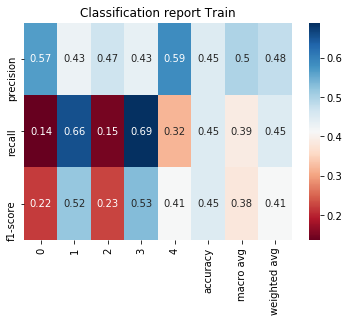

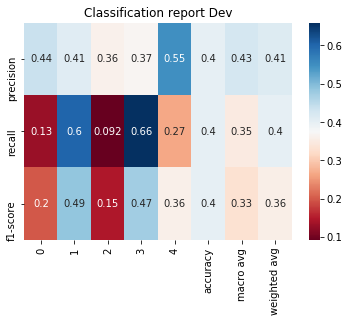

In [175]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

#model evaluation
def classification_rep(y_true, y_pred, title=''):
    sns.heatmap(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True))
                .drop(index=['support']), annot=True, cmap = 'RdBu')
    plt.title('Classification report ' + title)
    plt.show()

#Instantiate the model
logreg = LogisticRegression(C = 1, max_iter = 500)

#GridSearch for parameters tuning
param_grid = {'C': np.linspace(0.01,10, 20)}
gridsearch = GridSearchCV(logreg, param_grid=param_grid, cv=5, scoring='accuracy')

gridsearch.fit(X_train_encoded, y_train)

best_model = gridsearch.best_estimator_

y_pred_train = best_model.predict(X_train_encoded)
classification_rep(y_train, y_pred_train, title='Train')

y_pred_dev = best_model.predict(X_dev_encoded)
classification_rep(y_dev, y_pred_dev, title='Dev')

In [176]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

y_pred_test = best_model.predict(X_test_encoded)
np.savetxt('logreg_bov_y_test_sst.txt', y_pred_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] criterion=gini, max_depth=None, n_estimators=10 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. criterion=gini, max_depth=None, n_estimators=10, total=   1.1s
[CV] criterion=gini, max_depth=None, n_estimators=10 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .. criterion=gini, max_depth=None, n_estimators=10, total=   1.2s
[CV] criterion=gini, max_depth=None, n_estimators=10 .................
[CV] .. criterion=gini, max_depth=None, n_estimators=10, total=   1.0s
[CV] criterion=gini, max_depth=None, n_estimators=20 .................
[CV] .. criterion=gini, max_depth=None, n_estimators=20, total=   2.0s
[CV] criterion=gini, max_depth=None, n_estimators=20 .................
[CV] .. criterion=gini, max_depth=None, n_estimators=20, total=   1.9s
[CV] criterion=gini, max_depth=None, n_estimators=20 .................
[CV] .. criterion=gini, max_depth=None, n_estimators=20, total=   2.0s
[CV] criterion=gini, max_depth=None, n_estimators=50 .................
[CV] .. criterion=gini, max_depth=None, n_estimators=50, total=   4.8s
[CV] criterion=gini, max_depth=None, n_estimators=50 .................
[CV] .. criterion=gini, max_depth=None, n_estimators=50, total=   5.4s
[CV] criterion=gini, max_depth=None, n_estimators=50 .................
[CV] .

[CV] .. criterion=entropy, max_depth=5, n_estimators=20, total=   2.1s
[CV] criterion=entropy, max_depth=5, n_estimators=50 .................
[CV] .. criterion=entropy, max_depth=5, n_estimators=50, total=   5.4s
[CV] criterion=entropy, max_depth=5, n_estimators=50 .................
[CV] .. criterion=entropy, max_depth=5, n_estimators=50, total=   5.1s
[CV] criterion=entropy, max_depth=5, n_estimators=50 .................
[CV] .. criterion=entropy, max_depth=5, n_estimators=50, total=   5.4s
[CV] criterion=entropy, max_depth=10, n_estimators=10 ................
[CV] . criterion=entropy, max_depth=10, n_estimators=10, total=   1.9s
[CV] criterion=entropy, max_depth=10, n_estimators=10 ................
[CV] . criterion=entropy, max_depth=10, n_estimators=10, total=   2.0s
[CV] criterion=entropy, max_depth=10, n_estimators=10 ................
[CV] . criterion=entropy, max_depth=10, n_estimators=10, total=   2.0s
[CV] criterion=entropy, max_depth=10, n_estimators=20 ................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  5.9min finished


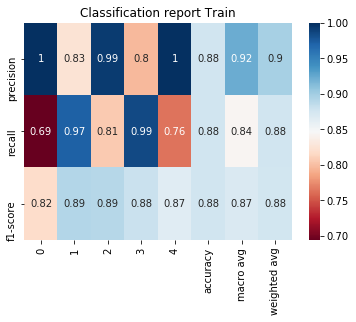

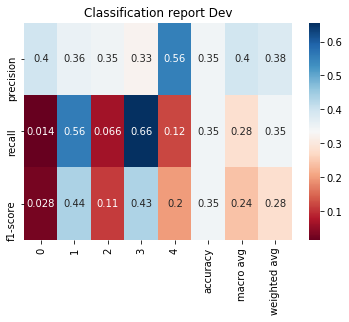

In [186]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# Instantiate the model with a new classifier
#Instantiate the model
other_model = RandomForestClassifier()

#GridSearch for parameters tuning
# param_grid_other = {'C': np.logspace(-2,2, 2), 'gamma': ['auto', 'scale'] + list(np.logspace(-2,2,2))}
param_grid_other = {'n_estimators': [10, 20, 50, 75, 100], 'criterion': ['entropy'], 'max_depth': [None, 5, 10, 15, 20]}
gridsearch_other = GridSearchCV(other_model, param_grid=param_grid_other, cv=3, scoring='accuracy', verbose=2)

gridsearch_other.fit(X_train_encoded, y_train)

best_other = gridsearch_other.best_estimator_

y_pred_train_other = best_other.predict(X_train_encoded)
classification_rep(y_train, y_pred_train_other, title='Train')

y_pred_dev_other = best_other.predict(X_dev_encoded)
classification_rep(y_dev, y_pred_dev_other, title='Dev')

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [207]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [257]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# Preprocessing of the training set
X_train_keras = []
for sent in X_train:
    X_train_keras.append(tf.keras.preprocessing.text.one_hot(sent, n = 50000))
    
# Preprocessing of the dev set
X_dev_keras = []
for sent in X_dev:
    X_dev_keras.append(tf.keras.preprocessing.text.one_hot(sent, n = 50000))
    
# Preprocessing of the test set
X_test_keras = []
for sent in X_test:
    X_test_keras.append(tf.keras.preprocessing.text.one_hot(sent, n = 50000))
    
#One-hot encoding of the label
encoder = OneHotEncoder(sparse=False)
y_train_ = encoder.fit_transform(pd.DataFrame(y_train))
y_dev_ = encoder.fit_transform(pd.DataFrame(y_dev))
print(y_train_.shape)

(8544, 5)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [218]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# Padding of the sequences
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train_keras, padding = 'post')
x_dev = tf.keras.preprocessing.sequence.pad_sequences(X_dev_keras, padding = 'post')
x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test_keras, padding = 'post')

## 4.2 - Design and train your model

In [268]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300 #32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

In [269]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  tf.keras.losses.categorical_crossentropy # find the right loss for multi-class classification
optimizer        =  tf.keras.optimizers.Adam(lr=0.01) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         15000000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 15,093,765
Trainable params: 15,093,765
Non-trainable params: 0
_________________________________________________________________
None


In [270]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 64
n_epochs = 6

history = model.fit(x_train, y_train_, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev_))

Train on 8544 samples, validate on 1101 samples
Epoch 1/6


AlreadyExistsError: Resource __per_step_1020/training_4/Adam/gradients/lstm_3/while/ReadVariableOp_4/Enter_grad/ArithmeticOptimizer/AddOpsRewrite_Add/tmp_var/struct tensorflow::TemporaryVariableOp::TmpVar
	 [[{{node training_4/Adam/gradients/lstm_3/while/ReadVariableOp_4/Enter_grad/ArithmeticOptimizer/AddOpsRewrite_Add/tmp_var}}]]

In [263]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# Generating prediction
y_pred_keras = model.predict(x_test)
np.savetxt("logreg_lstm_y_test_sst.txt", y_pred_keras)

## 4.3 - innovate !

In [ ]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE